This code creates and stores a single model ensemble created from a selection of models. We used a customized CNN, and pretrained models including VGG19, InceptionResnetV2 and SqueezeNet, with their ImageNet weights initialized and fine-tuned end-to-end. The optimal model ensemble is chosen and saved to make further predictions. Five fold cross validation is performed on a patient-specific case.

In [242]:
import tensorflow as tf
print('Tensorflow version : {}'.format(tf.__version__))
print('GPU : {}'.format(tf.config.list_physical_devices('GPU')))
#tf.config.experimental.list_physical_devices('GPU')
from tensorflow import keras
import tensorflow.keras.backend as K

Tensorflow version : 2.4.1
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [243]:
# Imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate, concatenate, Dense, Average, Dropout, LeakyReLU, Reshape, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Lambda, Activation, Flatten, Convolution1D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.utils import np_utils
#from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import Model, Input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras_squeezenet_tf2 import SqueezeNet
from keras_squeezenet_tf2 import SqueezeNet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [244]:
# custom function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [245]:
#%% Loading the data

img_width, img_height = 100, 100
train_data_dir = '../data/cell_images/train'
validation_data_dir = '../data/cell_images/test'
epochs = 200
batch_size = 32 
num_classes= 2

# Since the models work with the data of the same shape, we 
#define a single input layer that will be used by every model.

input_shape = (100,100,3)
model_input = Input(shape=input_shape)
print(model_input) 

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_12'), name='input_12', description="created by layer 'input_12'")


In [246]:
#%% declaring image data generators

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=2,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.5,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(100,100),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(100,100),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)

#identify the number of samples
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

#check the class indices
train_generator.class_indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [247]:
#%% assign class weights to balance model training and penalize over-represented classes

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
print(class_weights)

[1. 1.]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [248]:
#%% define custom model and instantiate it

def custom_cnn(model_input):
    x = BatchNormalization()(model_input)
    x = Conv2D(64, (5, 5), padding='same', activation='relu', name = 'custom_conv1')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name = 'maxpool1')(x)
    x = Dropout(0.25, name = 'conv_dropout1')(x)
    x = BatchNormalization(name = 'custom_batchnorm1')(x)
    x = Conv2D(128, (5, 5), padding='same', activation='relu', name = 'custom_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2), name = 'maxpool2')(x)
    x = Dropout(0.25, name = 'conv_dropout2')(x)
    x = BatchNormalization(name = 'custom_batchnorm2')(x)
    x = Conv2D(256, (5, 5), padding='same', activation='relu', name = 'custom_conv3')(x)
    x = MaxPooling2D(pool_size=(2, 2), name = 'maxpool3')(x)
    x = Dropout(0.25, name = 'conv_dropout3')(x)
    x = GlobalAveragePooling2D(name = 'custom_GAP')(x)
    x = Dense(256, activation='relu', name = 'custom_dense1')(x)
    x = Dropout(0.5, name = 'dense_dropout1')(x)
    x = Dense(num_classes, activation='softmax', name = 'custom_dense2')(x)
    model = Model(inputs=model_input, outputs=x, name='custom_cnn')
    return model

#instantiate the model
custom_model = custom_cnn(model_input)

#display model summary
custom_model.summary()

#plot the model
#plot_model(custom_model, to_file='custom_model.png',show_shapes=True, show_layer_names=False)


Model: "custom_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
batch_normalization_2246 (Ba (None, 100, 100, 3)       12        
_________________________________________________________________
custom_conv1 (Conv2D)        (None, 100, 100, 64)      4864      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 50, 50, 64)        0         
_________________________________________________________________
conv_dropout1 (Dropout)      (None, 50, 50, 64)        0         
_________________________________________________________________
custom_batchnorm1 (BatchNorm (None, 50, 50, 64)        256       
_________________________________________________________________
custom_conv2 (Conv2D)        (None, 50, 50, 128)       2

In [249]:
#%% VGG19 model 

def vgg19_cnn(model_input):
    vgg19_cnn = VGG19(weights='imagenet', include_top=False, input_tensor=model_input)
    x = vgg19_cnn.layers[-2].output 
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=vgg19_cnn.input, outputs=predictions, name='vgg19_custom')
    return model

#instantiate the model
vgg19_custom_model = vgg19_cnn(model_input)

#plot model summary
vgg19_custom_model.summary()
#plot_model(vgg19_custom_model, to_file='vgg19_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "vgg19_custom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

In [250]:
#%% SqueezeNet 

def squeeze_cnn(model_input):
    squeeze_cnn = SqueezeNet(weights='imagenet', include_top=False, input_tensor=model_input)
    x = squeeze_cnn.layers[-3].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=squeeze_cnn.input, outputs=predictions, name='squeeze_custom')
    return model

#instantiate the model
squeeze_custom_model = squeeze_cnn(model_input)

#display model summary
squeeze_custom_model.summary()

#plot model
#plot_model(squeeze_custom_model, to_file='squeeze_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "squeeze_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 49, 49, 64)   1792        input_12[0][0]                   
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 49, 49, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 24, 24, 64)   0           relu_conv1[0][0]                 
_____________________________________________________________________________________

In [251]:
#%% Inception ResnetV2 

def incepres_cnn(model_input):
    incepres_cnn = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=model_input)
    x = incepres_cnn.layers[-3].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=incepres_cnn.input, outputs=predictions, name='InceptionResnet_custom')
    return model

#instantiate the model
inceptionresnet_custom_model = incepres_cnn(model_input)

#display model summary
inceptionresnet_custom_model.summary()

#plot model
#plot_model(inceptionresnet_custom_model, to_file='inceptionresnet_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "InceptionResnet_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2233 (Conv2D)            (None, 49, 49, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2247 (Batch (None, 49, 49, 32)   96          conv2d_2233[0][0]                
__________________________________________________________________________________________________
activation_2233 (Activation)    (None, 49, 49, 32)   0           batch_normalization_2247[0][0]   
_____________________________________________________________________________

block17_19 (Lambda)             (None, 4, 4, 1088)   0           block17_18_ac[0][0]              
                                                                 block17_19_conv[0][0]            
__________________________________________________________________________________________________
block17_19_ac (Activation)      (None, 4, 4, 1088)   0           block17_19[0][0]                 
__________________________________________________________________________________________________
conv2d_2386 (Conv2D)            (None, 4, 4, 128)    139264      block17_19_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_2400 (Batch (None, 4, 4, 128)    384         conv2d_2386[0][0]                
__________________________________________________________________________________________________
activation_2386 (Activation)    (None, 4, 4, 128)    0           batch_normalization_2400[0][0]   
__________

In [252]:
#%% compile and train the custom model

adam = Adam(lr=0.001)  
metric = 'val_accuracy'
custom_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor=metric, factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1) 


Epoch 1/200
688/688 [==============================] - 67s 96ms/step - loss: 0.7161 - accuracy: 0.6425 - val_loss: 0.2277 - val_accuracy: 0.9317
Epoch 2/200
688/688 [==============================] - 61s 89ms/step - loss: 0.2770 - accuracy: 0.9049 - val_loss: 0.1776 - val_accuracy: 0.9459
Epoch 3/200
688/688 [==============================] - 61s 89ms/step - loss: 0.2560 - accuracy: 0.9124 - val_loss: 0.1463 - val_accuracy: 0.9528
Epoch 4/200
688/688 [==============================] - 62s 89ms/step - loss: 0.2273 - accuracy: 0.9236 - val_loss: 0.5343 - val_accuracy: 0.6726
Epoch 5/200
688/688 [==============================] - 62s 89ms/step - loss: 0.2205 - accuracy: 0.9262 - val_loss: 0.1441 - val_accuracy: 0.9513

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/200
688/688 [==============================] - 61s 89ms/step - loss: 0.2038 - accuracy: 0.9287 - val_loss: 0.1436 - val_accuracy: 0.9539
Epoch 7/200
688/688 [============================

688/688 [==============================] - 61s 89ms/step - loss: 0.1557 - accuracy: 0.9429 - val_loss: 0.1166 - val_accuracy: 0.9589
Epoch 54/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1592 - accuracy: 0.9418 - val_loss: 0.1174 - val_accuracy: 0.9586
Epoch 55/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1538 - accuracy: 0.9434 - val_loss: 0.1157 - val_accuracy: 0.9597
Epoch 56/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1581 - accuracy: 0.9405 - val_loss: 0.1164 - val_accuracy: 0.9593
Epoch 57/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1548 - accuracy: 0.9431 - val_loss: 0.1164 - val_accuracy: 0.9589
Epoch 58/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1526 - accuracy: 0.9443 - val_loss: 0.1153 - val_accuracy: 0.9593
Epoch 59/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1542 - accuracy: 0.9459 - val_loss: 0.1165 - val_accuracy

688/688 [==============================] - 61s 89ms/step - loss: 0.1522 - accuracy: 0.9452 - val_loss: 0.1123 - val_accuracy: 0.9604
Epoch 110/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1512 - accuracy: 0.9452 - val_loss: 0.1149 - val_accuracy: 0.9608
Epoch 111/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1510 - accuracy: 0.9458 - val_loss: 0.1145 - val_accuracy: 0.9608
Epoch 112/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1561 - accuracy: 0.9441 - val_loss: 0.1151 - val_accuracy: 0.9604
Epoch 113/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1548 - accuracy: 0.9431 - val_loss: 0.1173 - val_accuracy: 0.9604
Epoch 114/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1447 - accuracy: 0.9479 - val_loss: 0.1205 - val_accuracy: 0.9600
Epoch 115/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1474 - accuracy: 0.9479 - val_loss: 0.1144 - val_ac

Epoch 165/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1544 - accuracy: 0.9447 - val_loss: 0.1195 - val_accuracy: 0.9593
Epoch 166/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1449 - accuracy: 0.9480 - val_loss: 0.1165 - val_accuracy: 0.9608
Epoch 167/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1500 - accuracy: 0.9438 - val_loss: 0.1164 - val_accuracy: 0.9600
Epoch 168/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1427 - accuracy: 0.9478 - val_loss: 0.1162 - val_accuracy: 0.9593
Epoch 169/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1481 - accuracy: 0.9459 - val_loss: 0.1160 - val_accuracy: 0.9597
Epoch 170/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1463 - accuracy: 0.9477 - val_loss: 0.1168 - val_accuracy: 0.9593
Epoch 171/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1463 - accuracy: 0.9466 - val_loss: 0

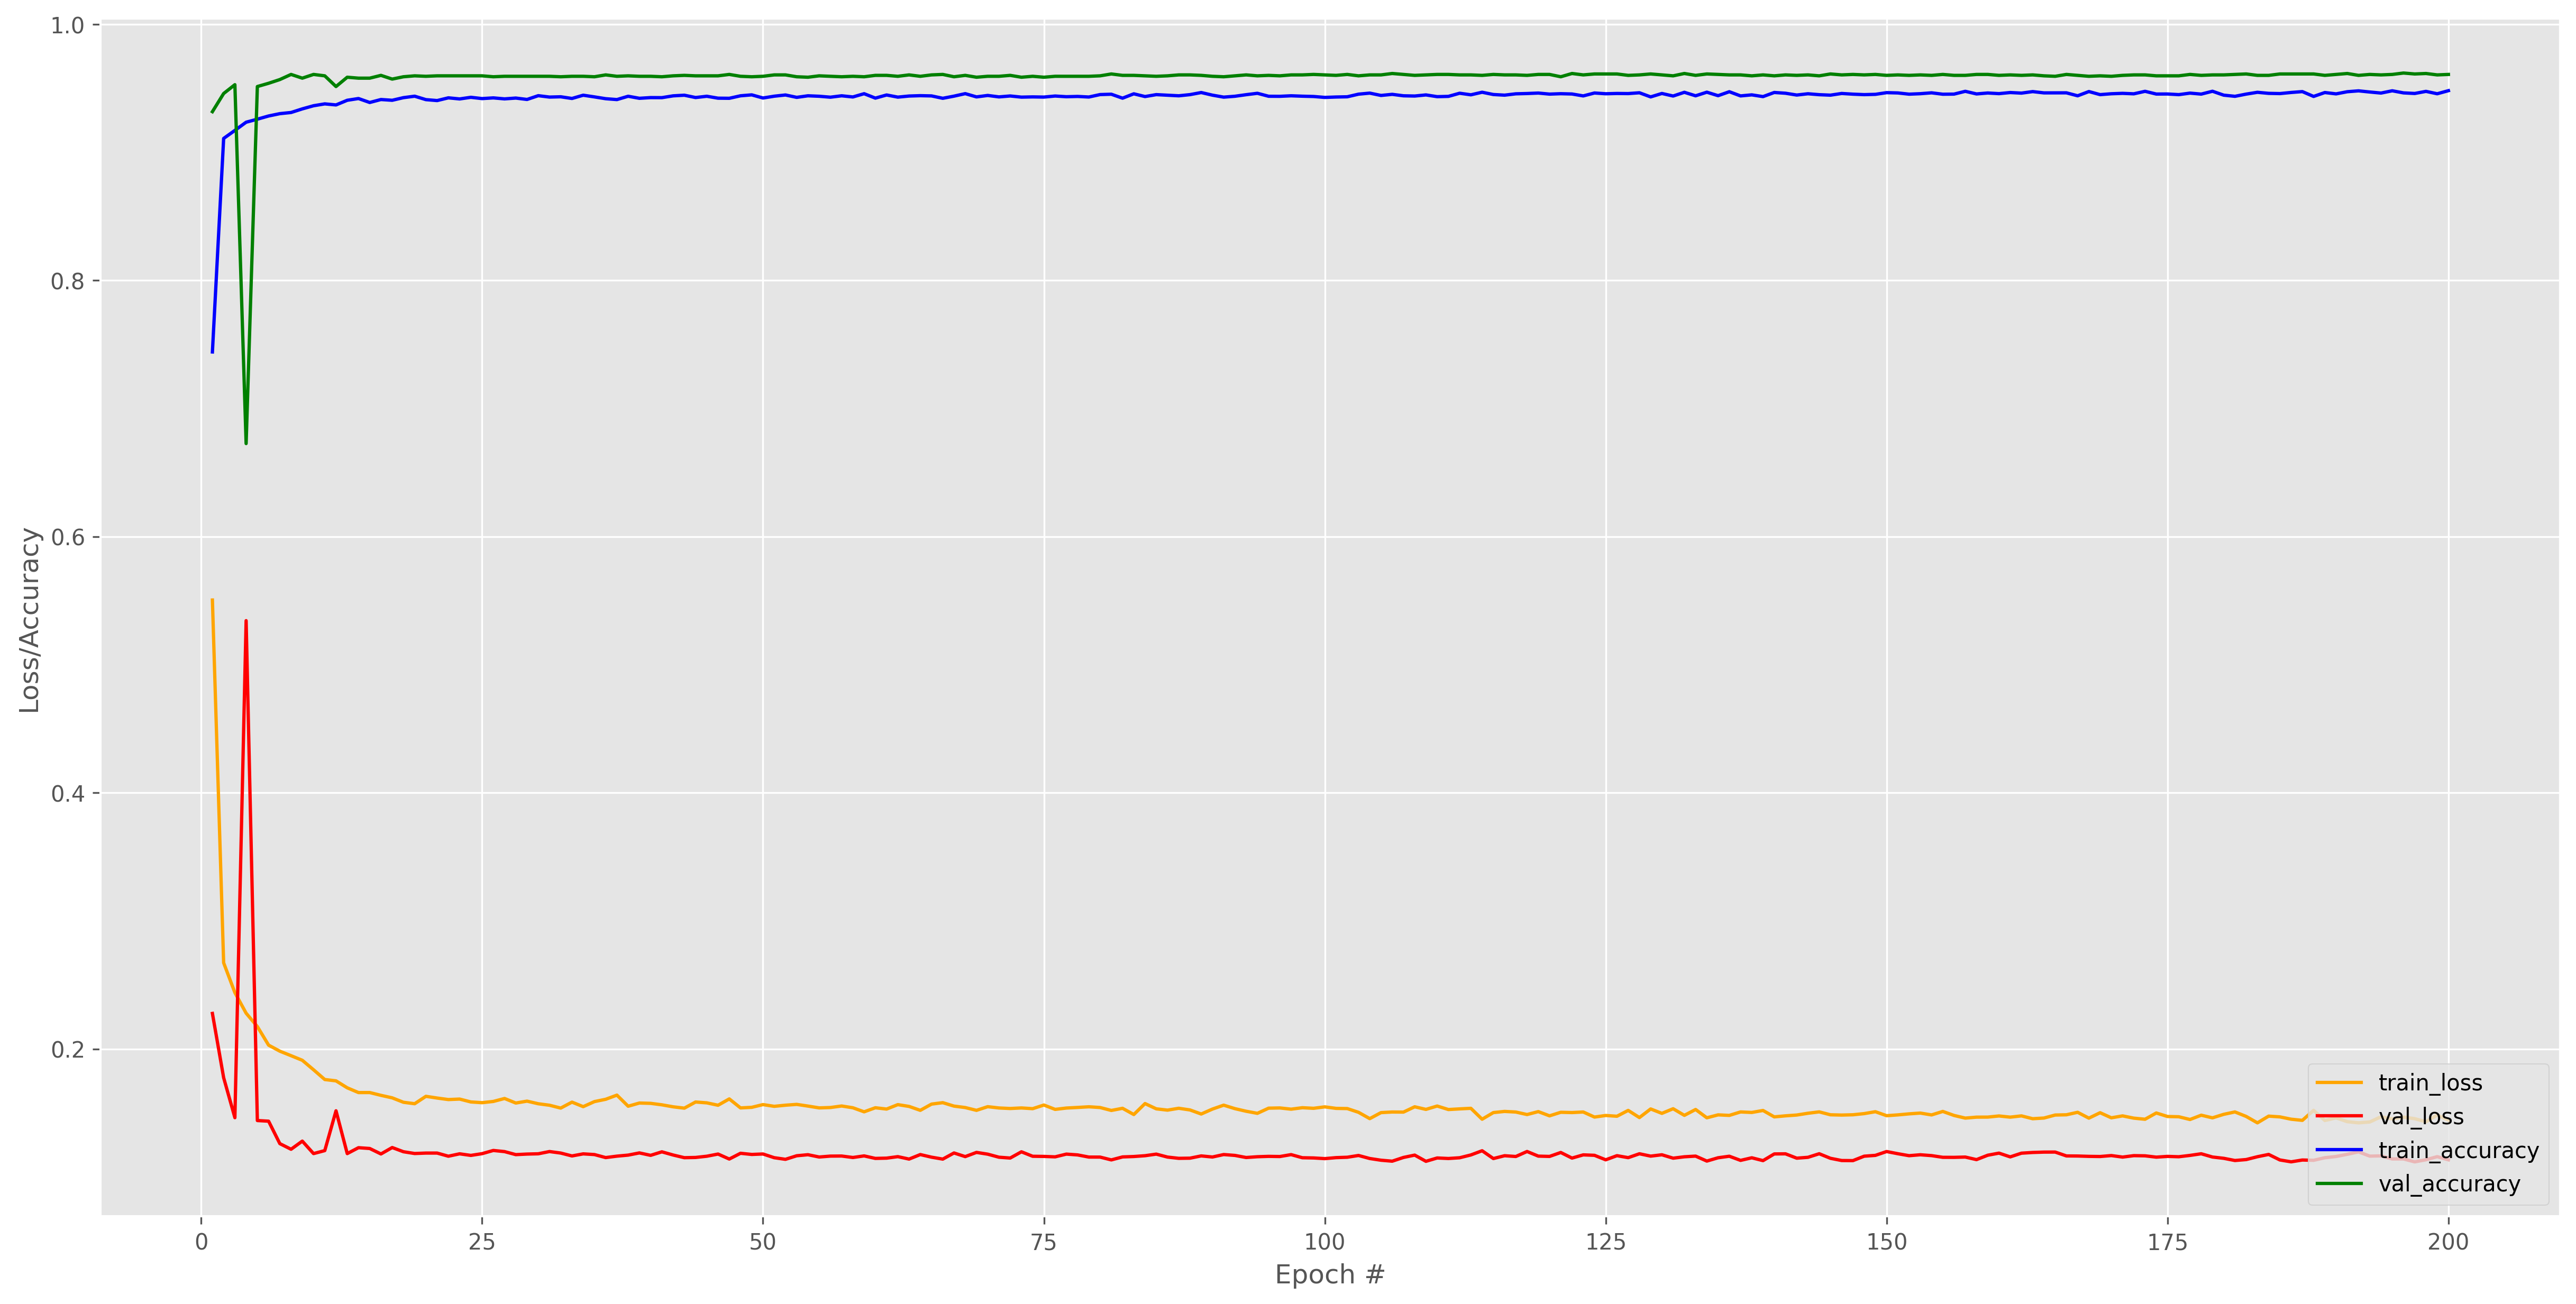

In [253]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("logs/custom_plot.png")

In [254]:
#%% compile and train the VGG19 model

adam = Adam(lr=0.0001)
metric = 'val_accuracy'
vgg19_custom_model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + vgg19_custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + vgg19_custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = vgg19_custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    


Epoch 1/200
688/688 [==============================] - 65s 92ms/step - loss: 0.4468 - accuracy: 0.7488 - val_loss: 0.1465 - val_accuracy: 0.9568
Epoch 2/200
688/688 [==============================] - 63s 91ms/step - loss: 0.2101 - accuracy: 0.9275 - val_loss: 0.1655 - val_accuracy: 0.9582
Epoch 3/200
688/688 [==============================] - 62s 91ms/step - loss: 0.1913 - accuracy: 0.9351 - val_loss: 0.1533 - val_accuracy: 0.9564
Epoch 4/200
688/688 [==============================] - 62s 91ms/step - loss: 0.1841 - accuracy: 0.9371 - val_loss: 0.1217 - val_accuracy: 0.9629
Epoch 5/200
688/688 [==============================] - 62s 91ms/step - loss: 0.1872 - accuracy: 0.9350 - val_loss: 0.1298 - val_accuracy: 0.9644
Epoch 6/200
688/688 [==============================] - 62s 91ms/step - loss: 0.1740 - accuracy: 0.9394 - val_loss: 0.1086 - val_accuracy: 0.9633
Epoch 7/200
688/688 [==============================] - 63s 91ms/step - loss: 0.1726 - accuracy: 0.9393 - val_loss: 0.1168 - val_ac

688/688 [==============================] - 62s 90ms/step - loss: 0.0991 - accuracy: 0.9626 - val_loss: 0.0747 - val_accuracy: 0.9757
Epoch 56/200
688/688 [==============================] - 62s 91ms/step - loss: 0.0944 - accuracy: 0.9654 - val_loss: 0.0745 - val_accuracy: 0.9738
Epoch 57/200
688/688 [==============================] - 62s 91ms/step - loss: 0.0977 - accuracy: 0.9648 - val_loss: 0.0772 - val_accuracy: 0.9727
Epoch 58/200
688/688 [==============================] - 62s 91ms/step - loss: 0.0995 - accuracy: 0.9634 - val_loss: 0.0748 - val_accuracy: 0.9738
Epoch 59/200
688/688 [==============================] - 62s 91ms/step - loss: 0.1063 - accuracy: 0.9610 - val_loss: 0.0752 - val_accuracy: 0.9746
Epoch 60/200
688/688 [==============================] - 62s 91ms/step - loss: 0.0992 - accuracy: 0.9628 - val_loss: 0.0756 - val_accuracy: 0.9746
Epoch 61/200
688/688 [==============================] - 62s 90ms/step - loss: 0.0984 - accuracy: 0.9625 - val_loss: 0.0769 - val_accuracy

688/688 [==============================] - 62s 90ms/step - loss: 0.0778 - accuracy: 0.9707 - val_loss: 0.0891 - val_accuracy: 0.9735
Epoch 112/200
688/688 [==============================] - 62s 90ms/step - loss: 0.0807 - accuracy: 0.9682 - val_loss: 0.0892 - val_accuracy: 0.9746
Epoch 113/200
688/688 [==============================] - 62s 90ms/step - loss: 0.0803 - accuracy: 0.9693 - val_loss: 0.0894 - val_accuracy: 0.9753
Epoch 114/200
688/688 [==============================] - 62s 90ms/step - loss: 0.0819 - accuracy: 0.9712 - val_loss: 0.0958 - val_accuracy: 0.9738
Epoch 115/200
688/688 [==============================] - 62s 91ms/step - loss: 0.0854 - accuracy: 0.9678 - val_loss: 0.0996 - val_accuracy: 0.9720
Epoch 116/200
688/688 [==============================] - 62s 90ms/step - loss: 0.0812 - accuracy: 0.9703 - val_loss: 0.0949 - val_accuracy: 0.9709
Epoch 117/200
688/688 [==============================] - 62s 91ms/step - loss: 0.0844 - accuracy: 0.9704 - val_loss: 0.0957 - val_ac

Epoch 167/200
688/688 [==============================] - 64s 93ms/step - loss: 0.0648 - accuracy: 0.9768 - val_loss: 0.1154 - val_accuracy: 0.9724
Epoch 168/200
688/688 [==============================] - 64s 93ms/step - loss: 0.0662 - accuracy: 0.9741 - val_loss: 0.1256 - val_accuracy: 0.9706
Epoch 169/200
688/688 [==============================] - 67s 97ms/step - loss: 0.0636 - accuracy: 0.9772 - val_loss: 0.1157 - val_accuracy: 0.9720
Epoch 170/200
688/688 [==============================] - 64s 92ms/step - loss: 0.0642 - accuracy: 0.9787 - val_loss: 0.1318 - val_accuracy: 0.9749
Epoch 171/200
688/688 [==============================] - 64s 93ms/step - loss: 0.0634 - accuracy: 0.9767 - val_loss: 0.1270 - val_accuracy: 0.9731
Epoch 172/200
688/688 [==============================] - 64s 93ms/step - loss: 0.0700 - accuracy: 0.9726 - val_loss: 0.1139 - val_accuracy: 0.9717
Epoch 173/200
688/688 [==============================] - 64s 93ms/step - loss: 0.0639 - accuracy: 0.9765 - val_loss: 0

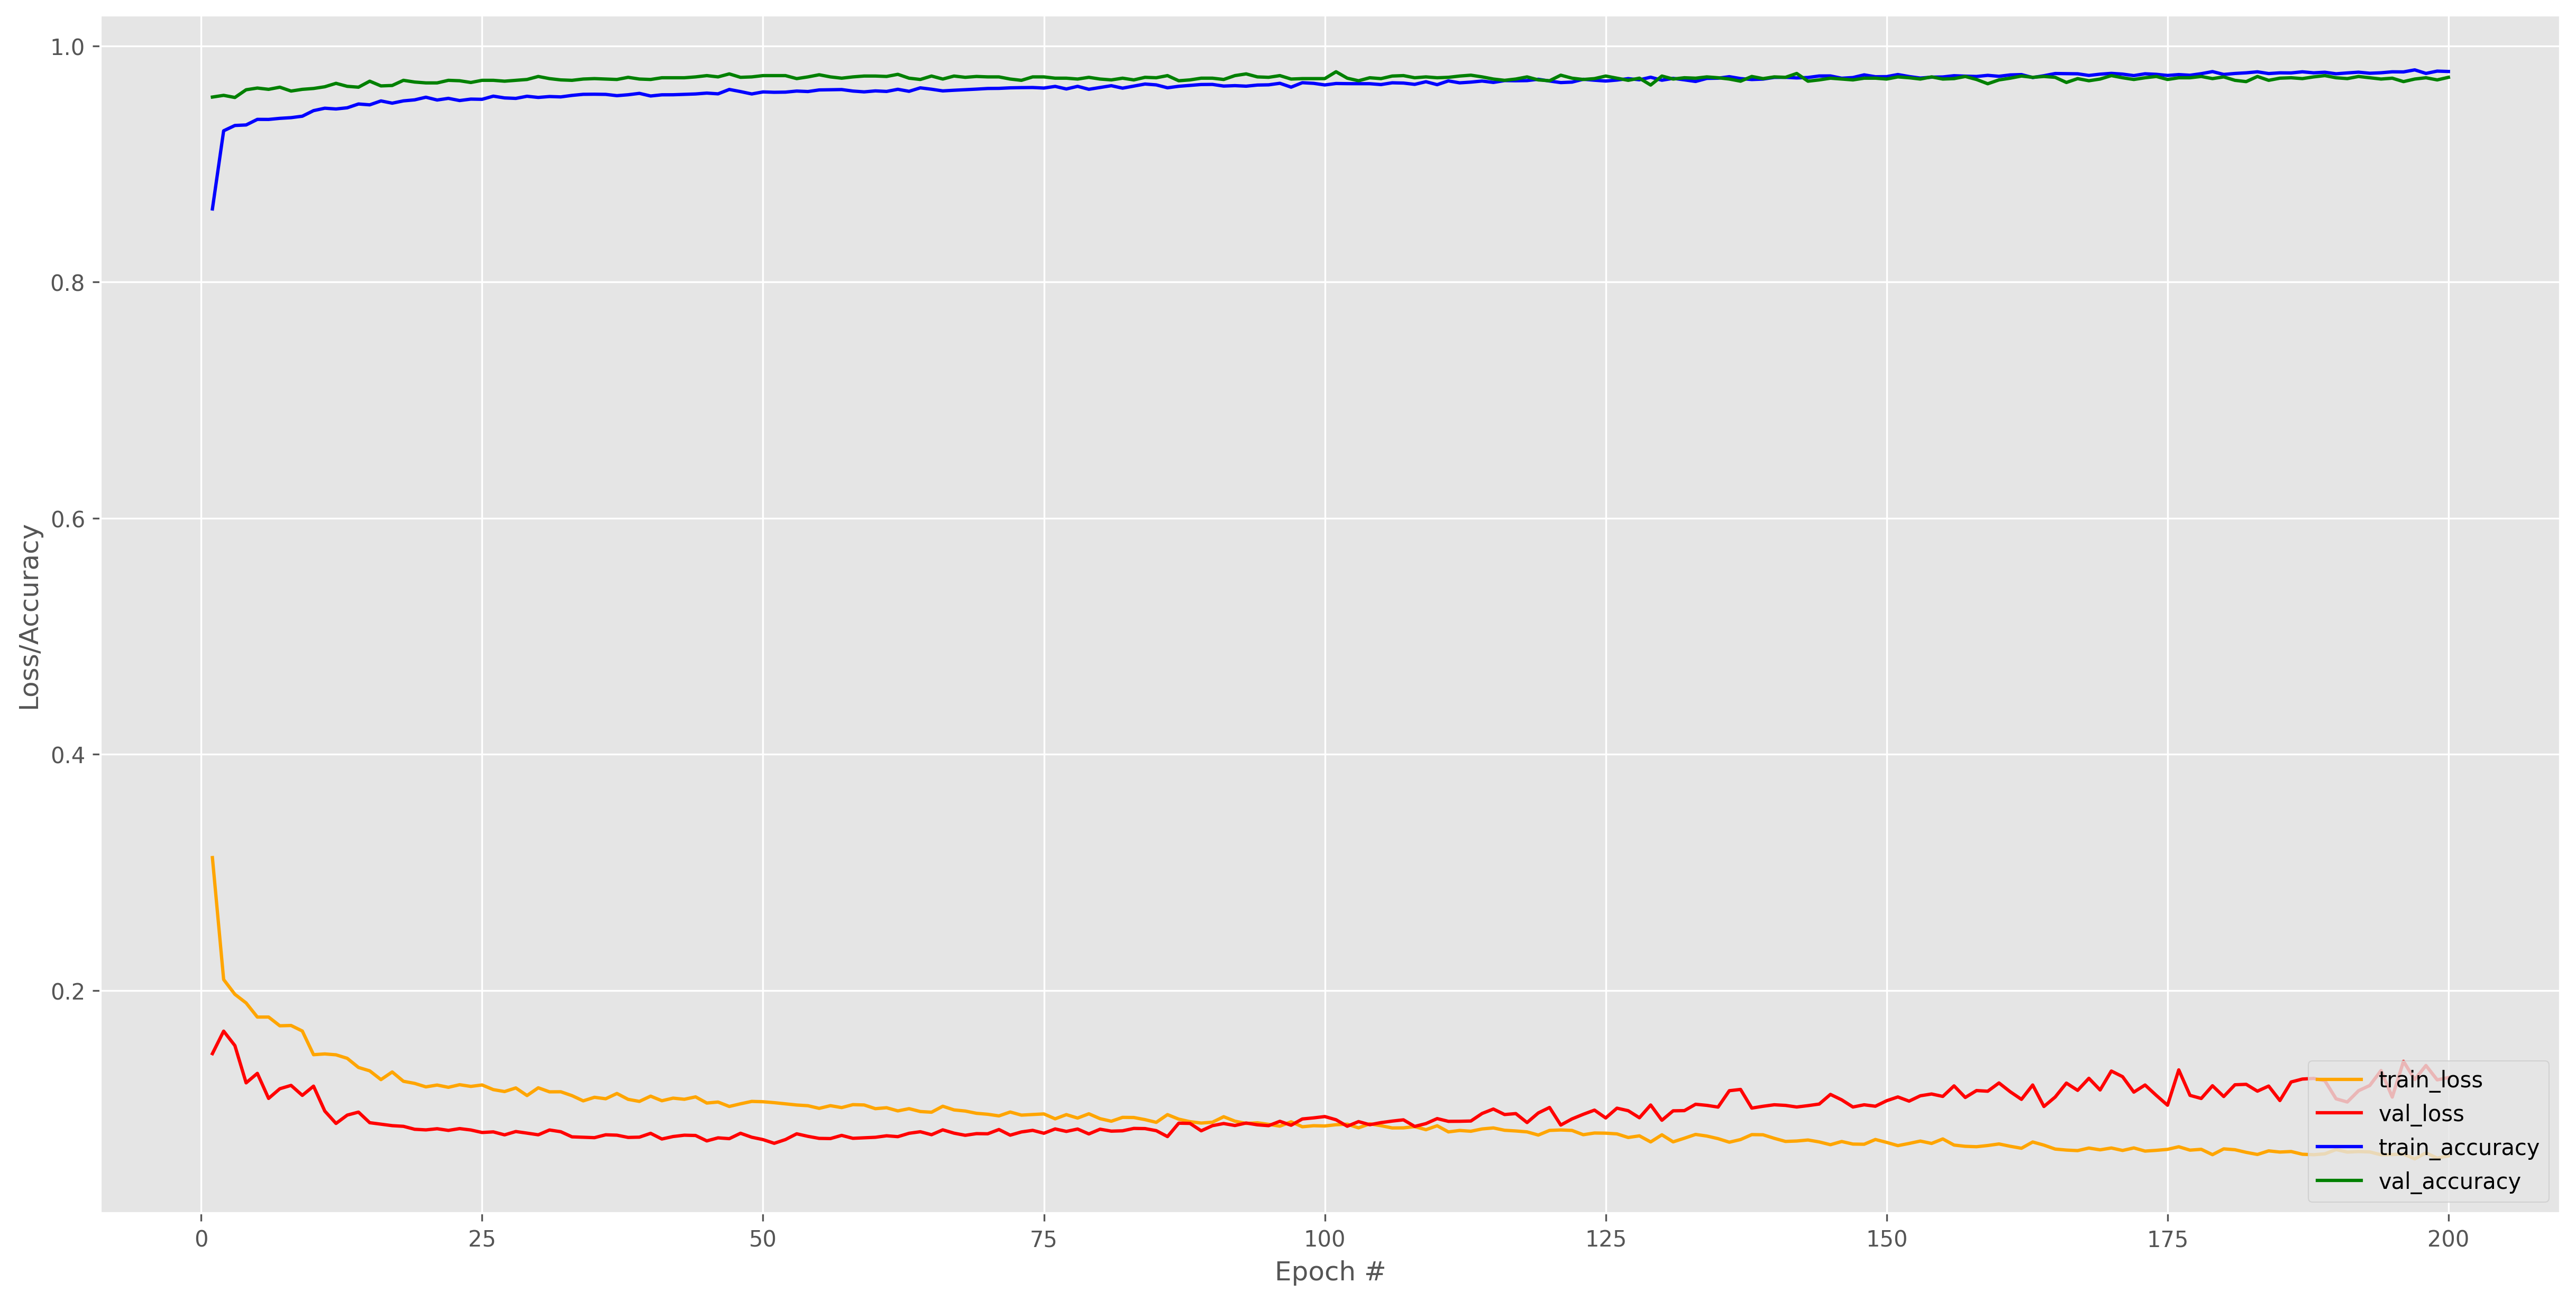

In [255]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("logs/VGG19_custom_plot.png")

In [256]:
#%% compile and train the squeezenet model

adam = Adam(lr=0.0001) 
squeeze_custom_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + squeeze_custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + squeeze_custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = squeeze_custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    

Epoch 1/200
688/688 [==============================] - 64s 90ms/step - loss: 0.3652 - accuracy: 0.8318 - val_loss: 0.1467 - val_accuracy: 0.9557
Epoch 2/200
688/688 [==============================] - 61s 89ms/step - loss: 0.2127 - accuracy: 0.9251 - val_loss: 0.1216 - val_accuracy: 0.9600
Epoch 3/200
688/688 [==============================] - 61s 89ms/step - loss: 0.2004 - accuracy: 0.9283 - val_loss: 0.1272 - val_accuracy: 0.9597
Epoch 4/200
688/688 [==============================] - 62s 90ms/step - loss: 0.1904 - accuracy: 0.9304 - val_loss: 0.1101 - val_accuracy: 0.9615
Epoch 5/200
688/688 [==============================] - 62s 90ms/step - loss: 0.1852 - accuracy: 0.9336 - val_loss: 0.1068 - val_accuracy: 0.9626
Epoch 6/200
688/688 [==============================] - 62s 90ms/step - loss: 0.1778 - accuracy: 0.9318 - val_loss: 0.1161 - val_accuracy: 0.9589
Epoch 7/200
688/688 [==============================] - 62s 90ms/step - loss: 0.1749 - accuracy: 0.9371 - val_loss: 0.1084 - val_ac

688/688 [==============================] - 61s 89ms/step - loss: 0.1310 - accuracy: 0.9509 - val_loss: 0.0829 - val_accuracy: 0.9713
Epoch 56/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1286 - accuracy: 0.9513 - val_loss: 0.0877 - val_accuracy: 0.9695
Epoch 57/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1325 - accuracy: 0.9486 - val_loss: 0.0857 - val_accuracy: 0.9698
Epoch 58/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1341 - accuracy: 0.9502 - val_loss: 0.0856 - val_accuracy: 0.9698
Epoch 59/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1249 - accuracy: 0.9533 - val_loss: 0.0850 - val_accuracy: 0.9709
Epoch 60/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1347 - accuracy: 0.9488 - val_loss: 0.0842 - val_accuracy: 0.9698
Epoch 61/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1366 - accuracy: 0.9479 - val_loss: 0.0845 - val_accuracy

688/688 [==============================] - 61s 88ms/step - loss: 0.1196 - accuracy: 0.9553 - val_loss: 0.0827 - val_accuracy: 0.9702
Epoch 112/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1232 - accuracy: 0.9537 - val_loss: 0.0804 - val_accuracy: 0.9706
Epoch 113/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1205 - accuracy: 0.9552 - val_loss: 0.0811 - val_accuracy: 0.9706
Epoch 114/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1234 - accuracy: 0.9545 - val_loss: 0.0796 - val_accuracy: 0.9720
Epoch 115/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1247 - accuracy: 0.9531 - val_loss: 0.0802 - val_accuracy: 0.9709
Epoch 116/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1229 - accuracy: 0.9540 - val_loss: 0.0801 - val_accuracy: 0.9709
Epoch 117/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1245 - accuracy: 0.9522 - val_loss: 0.0798 - val_ac

Epoch 167/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1161 - accuracy: 0.9557 - val_loss: 0.0850 - val_accuracy: 0.9695
Epoch 168/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1204 - accuracy: 0.9553 - val_loss: 0.0789 - val_accuracy: 0.9731
Epoch 169/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1205 - accuracy: 0.9554 - val_loss: 0.0781 - val_accuracy: 0.9720
Epoch 170/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1196 - accuracy: 0.9556 - val_loss: 0.0875 - val_accuracy: 0.9684
Epoch 171/200
688/688 [==============================] - 61s 89ms/step - loss: 0.1156 - accuracy: 0.9553 - val_loss: 0.0818 - val_accuracy: 0.9695
Epoch 172/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1141 - accuracy: 0.9549 - val_loss: 0.0809 - val_accuracy: 0.9713
Epoch 173/200
688/688 [==============================] - 61s 88ms/step - loss: 0.1170 - accuracy: 0.9568 - val_loss: 0

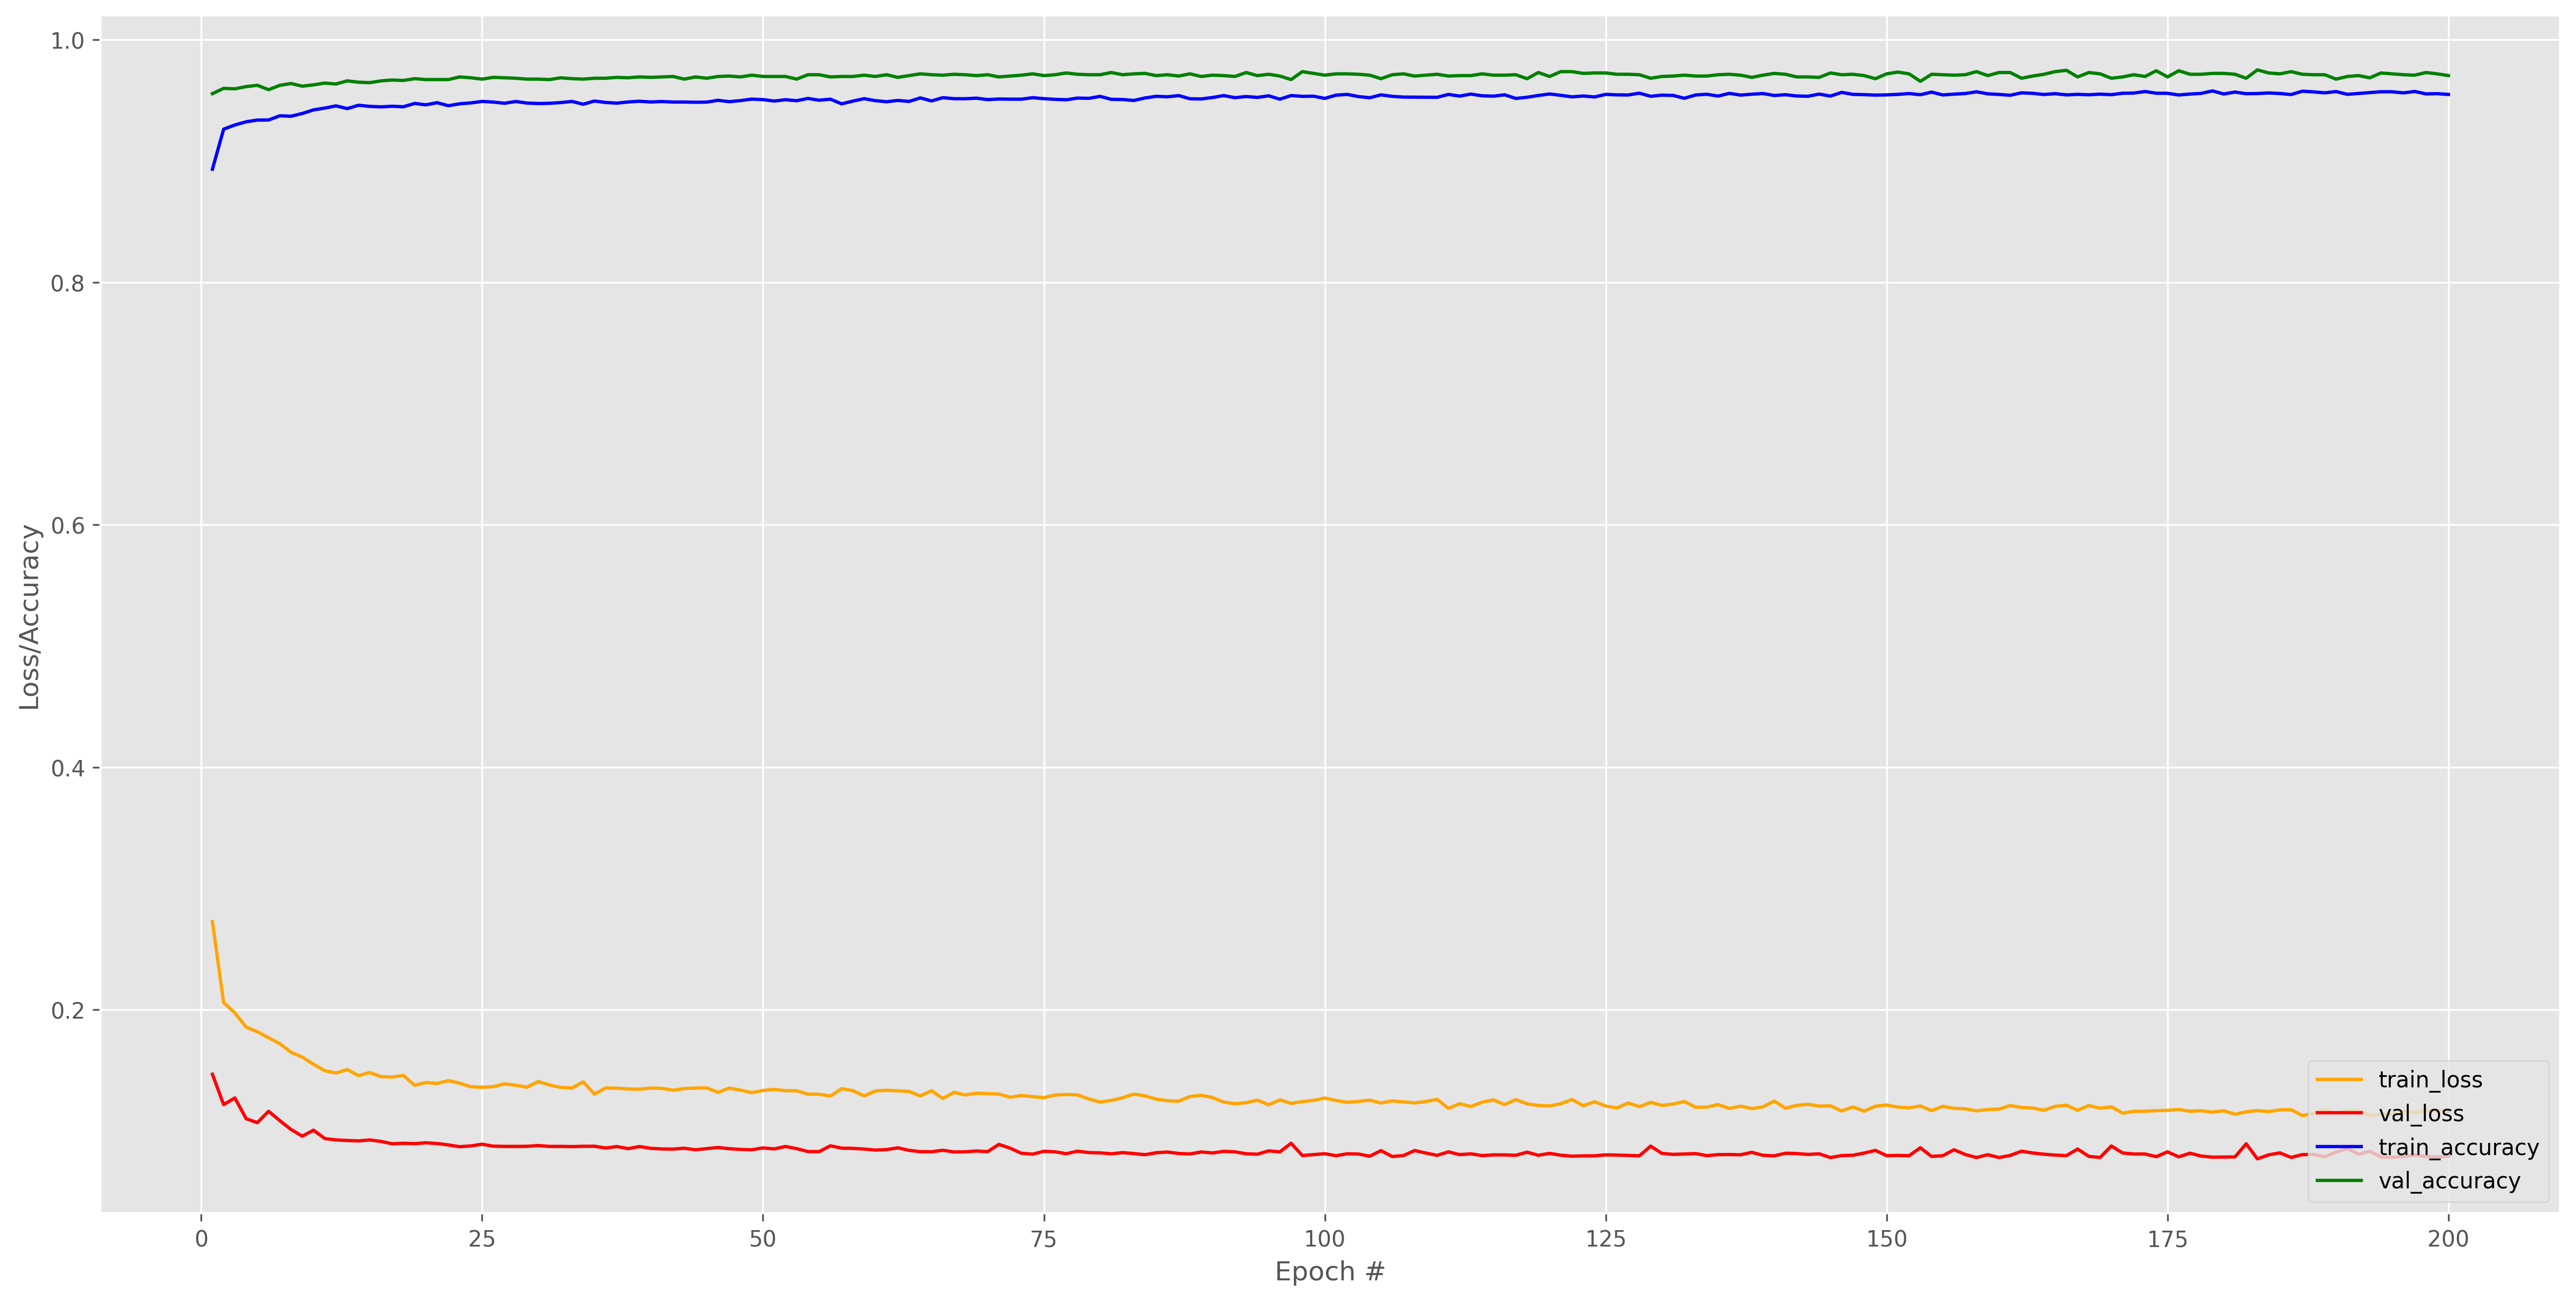

In [257]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("logs/SqueezeNet_custom_plot.png")

In [258]:
#%% compile and train the InceptionResnetV2 model

adam = Adam(lr=0.0001)  
inceptionresnet_custom_model.compile(optimizer=adam,
                                     loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + inceptionresnet_custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + inceptionresnet_custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = inceptionresnet_custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    

Epoch 1/200
688/688 [==============================] - 96s 117ms/step - loss: 0.3628 - accuracy: 0.8406 - val_loss: 0.6246 - val_accuracy: 0.9306
Epoch 2/200
688/688 [==============================] - 75s 109ms/step - loss: 0.1969 - accuracy: 0.9229 - val_loss: 0.2915 - val_accuracy: 0.9480
Epoch 3/200
688/688 [==============================] - 74s 108ms/step - loss: 0.1740 - accuracy: 0.9331 - val_loss: 0.2392 - val_accuracy: 0.9371
Epoch 4/200
688/688 [==============================] - 75s 109ms/step - loss: 0.1624 - accuracy: 0.9416 - val_loss: 0.1200 - val_accuracy: 0.9651
Epoch 5/200
688/688 [==============================] - 74s 108ms/step - loss: 0.1544 - accuracy: 0.9397 - val_loss: 0.1177 - val_accuracy: 0.9593
Epoch 6/200
688/688 [==============================] - 75s 108ms/step - loss: 0.1427 - accuracy: 0.9456 - val_loss: 0.0951 - val_accuracy: 0.9673
Epoch 7/200
688/688 [==============================] - 75s 108ms/step - loss: 0.1369 - accuracy: 0.9486 - val_loss: 0.1032 -

Epoch 55/200
688/688 [==============================] - 75s 108ms/step - loss: 0.0733 - accuracy: 0.9700 - val_loss: 0.1293 - val_accuracy: 0.9677
Epoch 56/200
688/688 [==============================] - 75s 109ms/step - loss: 0.0707 - accuracy: 0.9745 - val_loss: 0.1300 - val_accuracy: 0.9702
Epoch 57/200
688/688 [==============================] - 75s 109ms/step - loss: 0.0760 - accuracy: 0.9727 - val_loss: 0.1279 - val_accuracy: 0.9695
Epoch 58/200
688/688 [==============================] - 75s 109ms/step - loss: 0.0740 - accuracy: 0.9717 - val_loss: 0.1265 - val_accuracy: 0.9684
Epoch 59/200
688/688 [==============================] - 75s 109ms/step - loss: 0.0718 - accuracy: 0.9729 - val_loss: 0.1225 - val_accuracy: 0.9688
Epoch 60/200
688/688 [==============================] - 75s 109ms/step - loss: 0.0693 - accuracy: 0.9749 - val_loss: 0.1289 - val_accuracy: 0.9702
Epoch 61/200
688/688 [==============================] - 75s 108ms/step - loss: 0.0634 - accuracy: 0.9754 - val_loss: 0

688/688 [==============================] - 75s 109ms/step - loss: 0.0552 - accuracy: 0.9792 - val_loss: 0.5409 - val_accuracy: 0.9499
Epoch 111/200
688/688 [==============================] - 75s 108ms/step - loss: 0.0542 - accuracy: 0.9815 - val_loss: 1.0040 - val_accuracy: 0.9408
Epoch 112/200
688/688 [==============================] - 75s 109ms/step - loss: 0.0507 - accuracy: 0.9815 - val_loss: 0.3823 - val_accuracy: 0.9491
Epoch 113/200
688/688 [==============================] - 75s 108ms/step - loss: 0.0596 - accuracy: 0.9788 - val_loss: 0.2829 - val_accuracy: 0.9520
Epoch 114/200
688/688 [==============================] - 75s 109ms/step - loss: 0.0539 - accuracy: 0.9803 - val_loss: 0.2122 - val_accuracy: 0.9626
Epoch 115/200
688/688 [==============================] - 75s 109ms/step - loss: 0.0491 - accuracy: 0.9804 - val_loss: 0.2789 - val_accuracy: 0.9560
Epoch 116/200
688/688 [==============================] - 75s 108ms/step - loss: 0.0538 - accuracy: 0.9810 - val_loss: 0.3406 -

688/688 [==============================] - 75s 108ms/step - loss: 0.0381 - accuracy: 0.9859 - val_loss: 3.2889 - val_accuracy: 0.9426
Epoch 166/200
688/688 [==============================] - 75s 109ms/step - loss: 0.0403 - accuracy: 0.9857 - val_loss: 1.9105 - val_accuracy: 0.9448
Epoch 167/200
688/688 [==============================] - 75s 108ms/step - loss: 0.0456 - accuracy: 0.9841 - val_loss: 1.0097 - val_accuracy: 0.9422
Epoch 168/200
688/688 [==============================] - 75s 108ms/step - loss: 0.0435 - accuracy: 0.9852 - val_loss: 0.7211 - val_accuracy: 0.9462
Epoch 169/200
688/688 [==============================] - 75s 108ms/step - loss: 0.0432 - accuracy: 0.9837 - val_loss: 0.5487 - val_accuracy: 0.9531
Epoch 170/200
688/688 [==============================] - 75s 109ms/step - loss: 0.0393 - accuracy: 0.9871 - val_loss: 0.3143 - val_accuracy: 0.9593
Epoch 171/200
688/688 [==============================] - 75s 108ms/step - loss: 0.0339 - accuracy: 0.9870 - val_loss: 1.2889 -

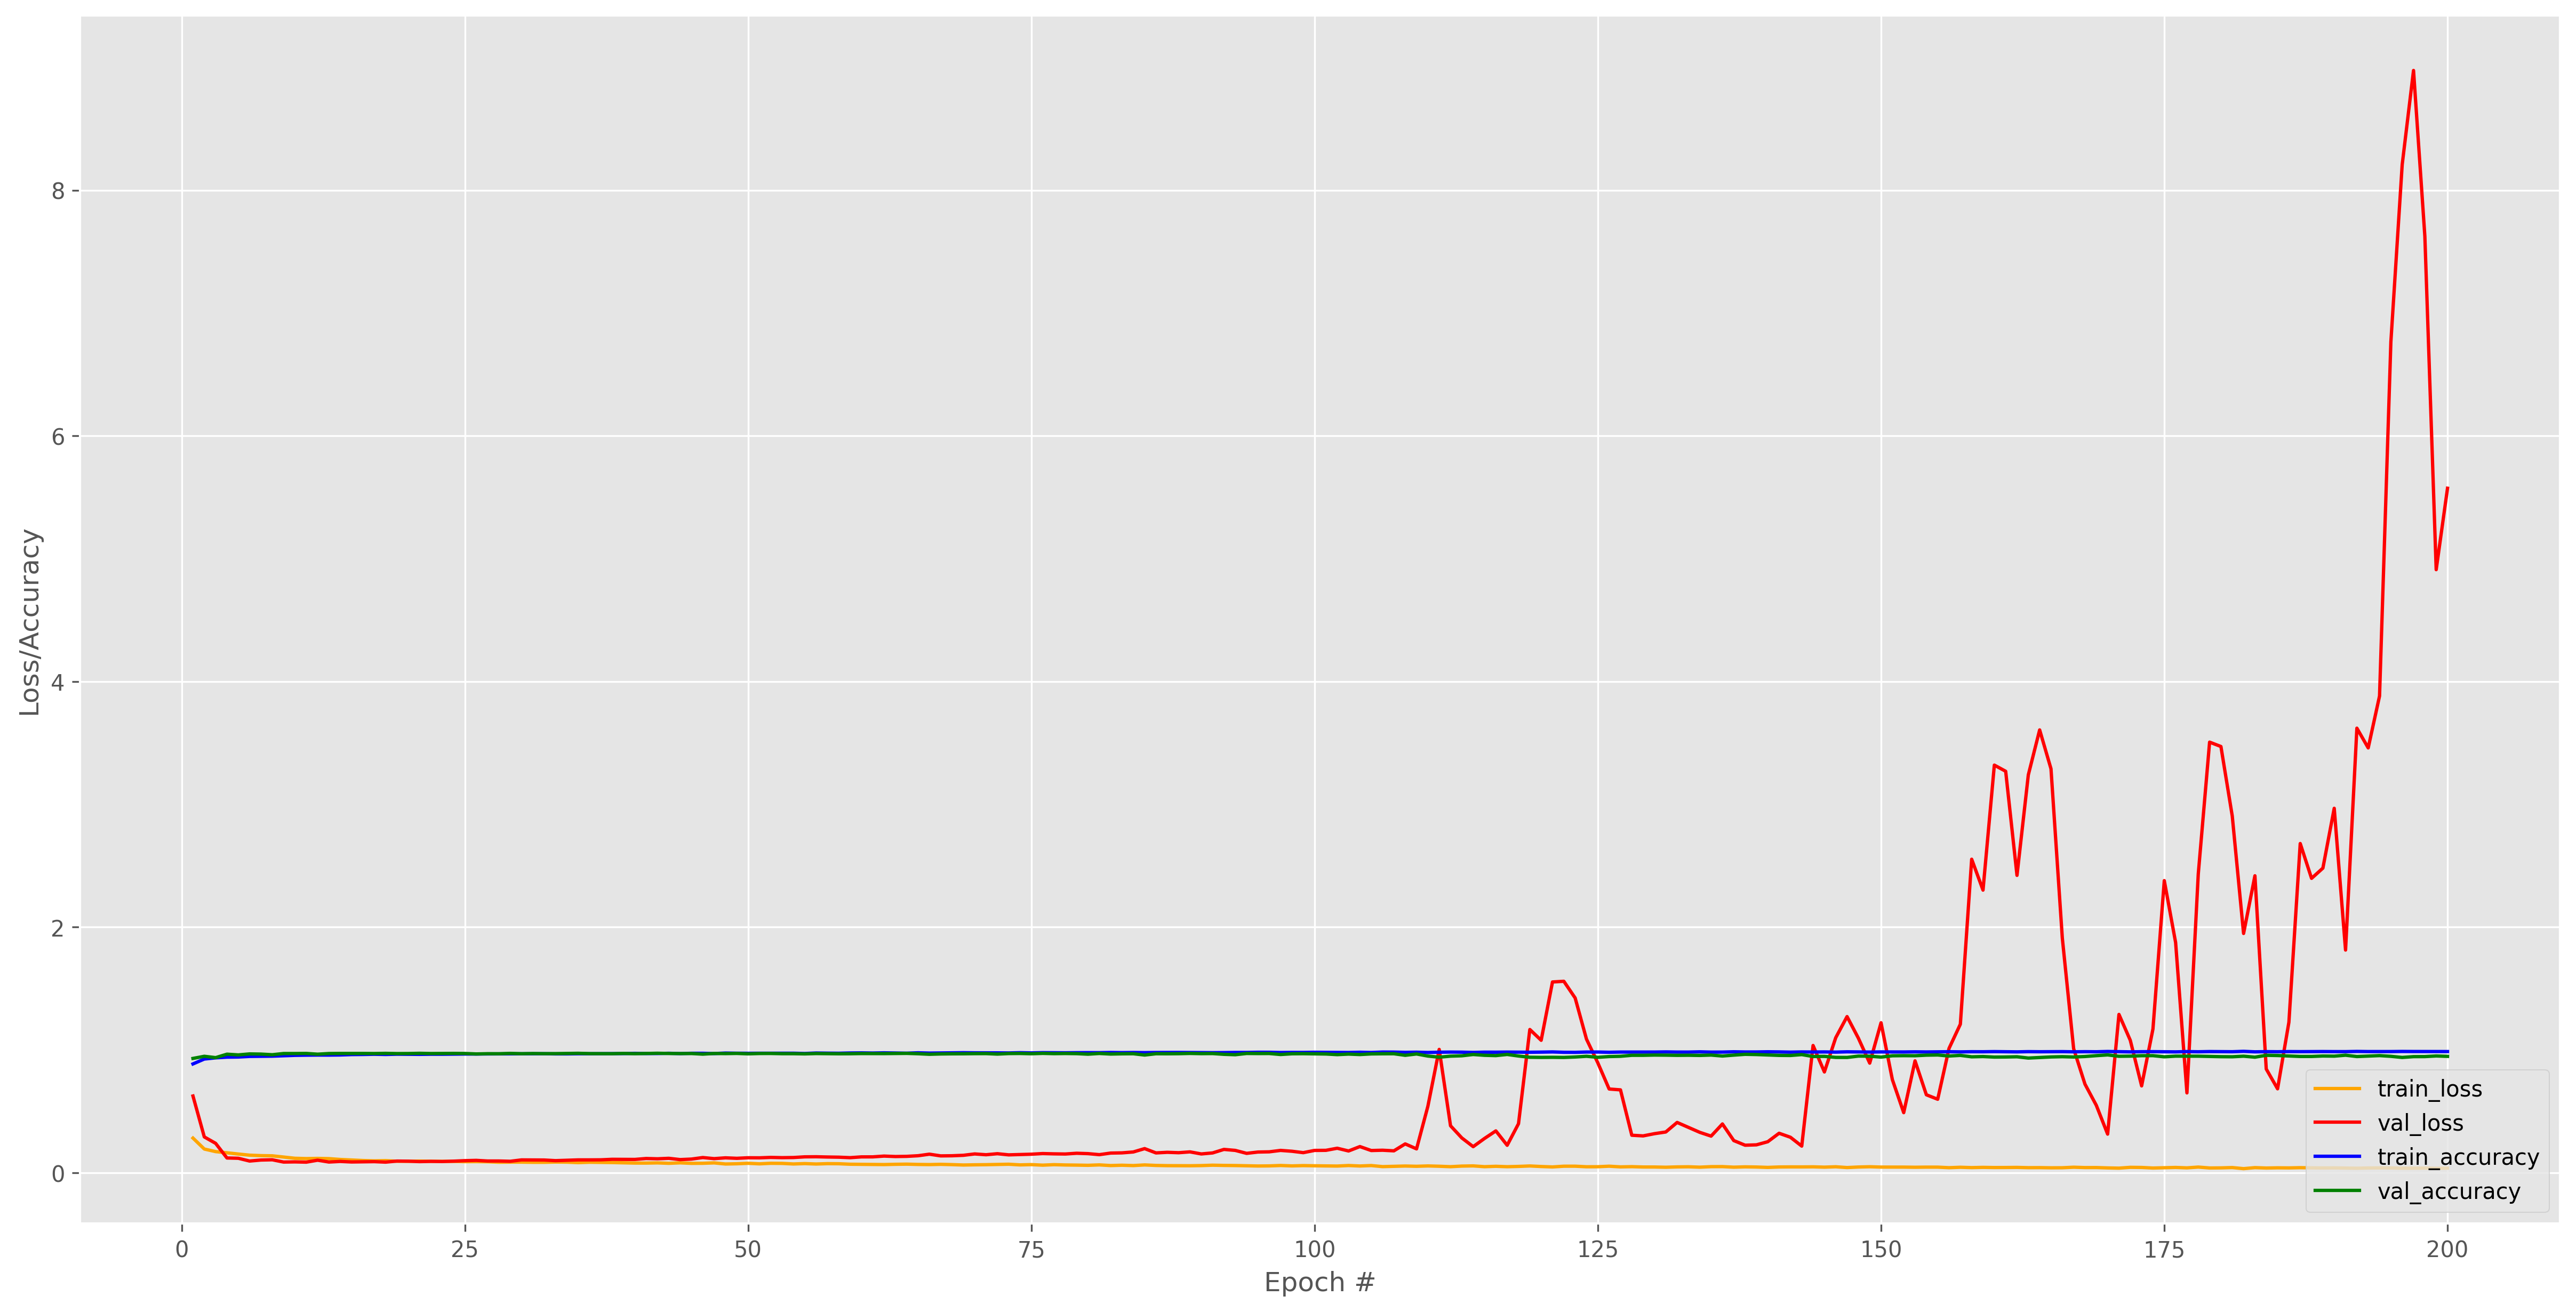

In [259]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("logs/InceptionResnet_custom_plot.png")

In [260]:
#Evaluate the model by loading the best weights
custom_model.load_weights('weights/custom_cnn.h5')

#evaluate accuracy
custom_y_pred = custom_model.predict(validation_generator,
                                               nb_validation_samples/batch_size, workers=1)
accuracy = accuracy_score(Y_test,custom_y_pred.argmax(axis=-1))
print('The accuracy of the Custom model is: ', accuracy)

#evaluate mean squared error
custom_mse = mean_squared_error(Y_test,custom_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Custom model is: ', custom_mse)

#evaluate mean squared log error
custom_msle = mean_squared_log_error(Y_test,custom_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Custom model is: ', custom_msle)

The accuracy of the Custom model is:  0.9619013062409288
The Mean Squared Error of the Custom model is:  0.038098693759071114
The Mean Squared Log Error of the Custom model is:  0.018304632242892287


                   precision    recall  f1-score   support

class 0(abnormal)     0.9782    0.9448    0.9612      1378
  class 1(normal)     0.9467    0.9790    0.9625      1378

         accuracy                         0.9619      2756
        macro avg     0.9624    0.9619    0.9619      2756
     weighted avg     0.9624    0.9619    0.9619      2756

Confusion matrix, without normalization
[[1302   76]
 [  29 1349]]


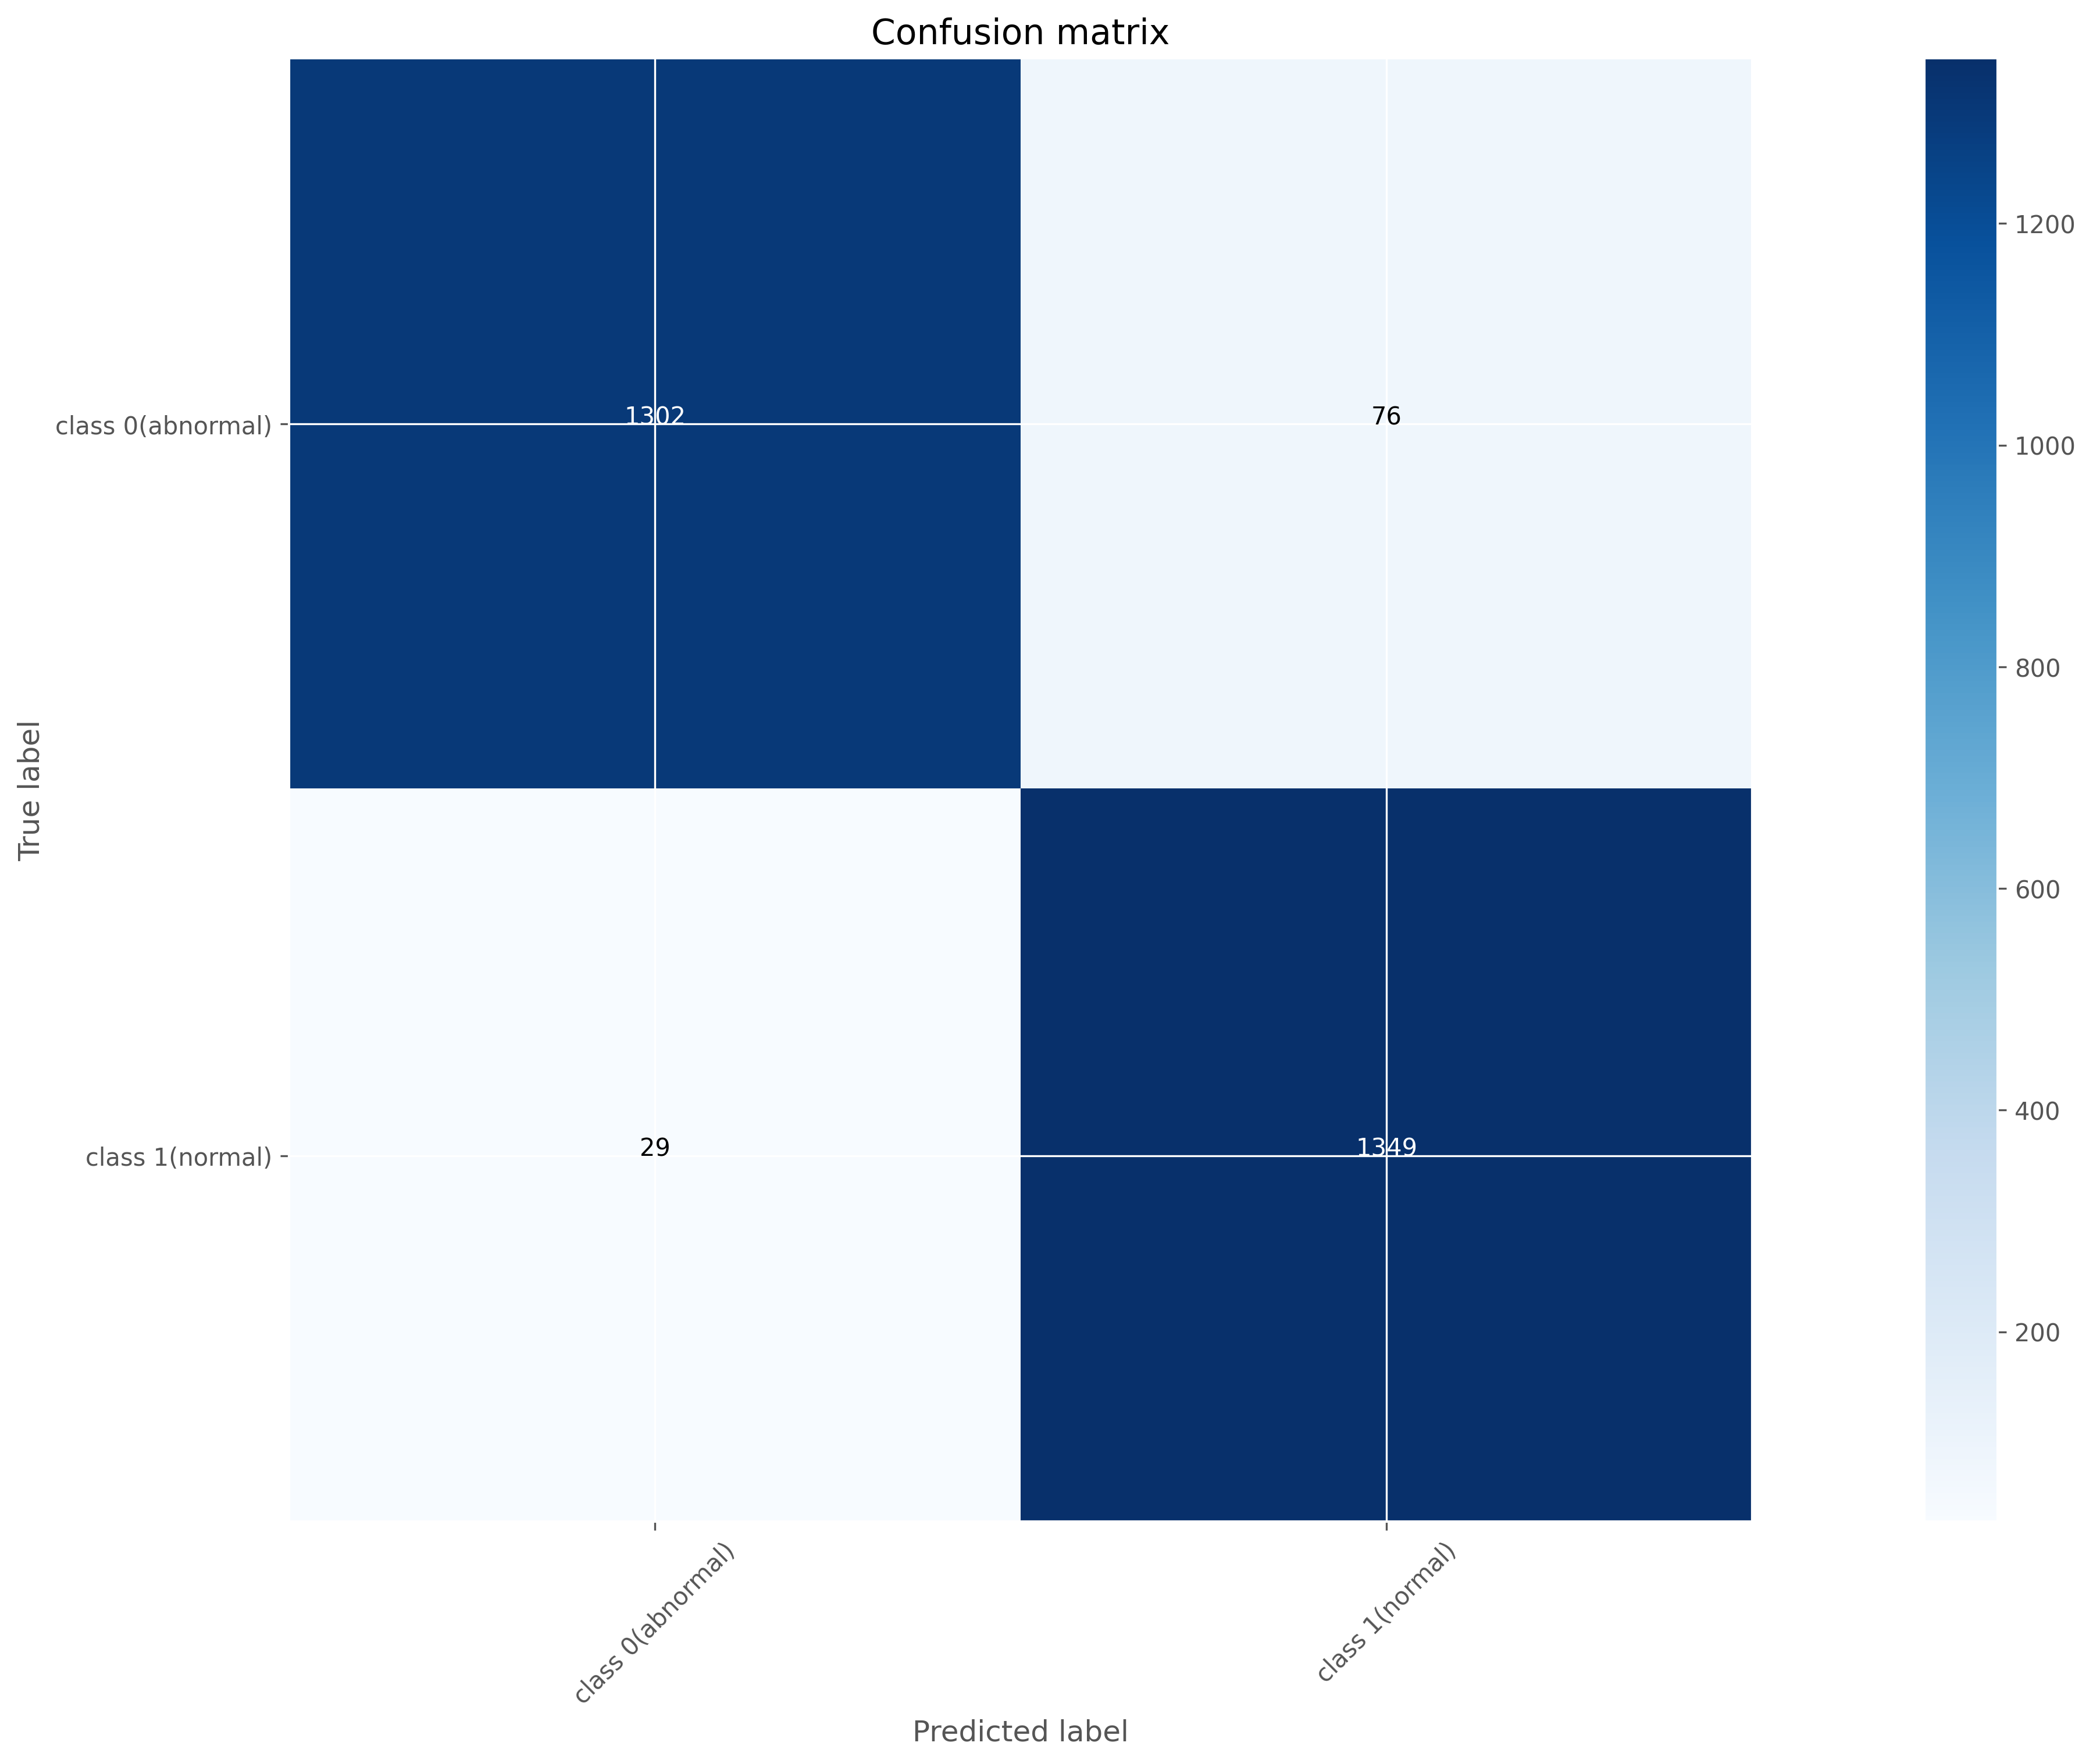

In [261]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


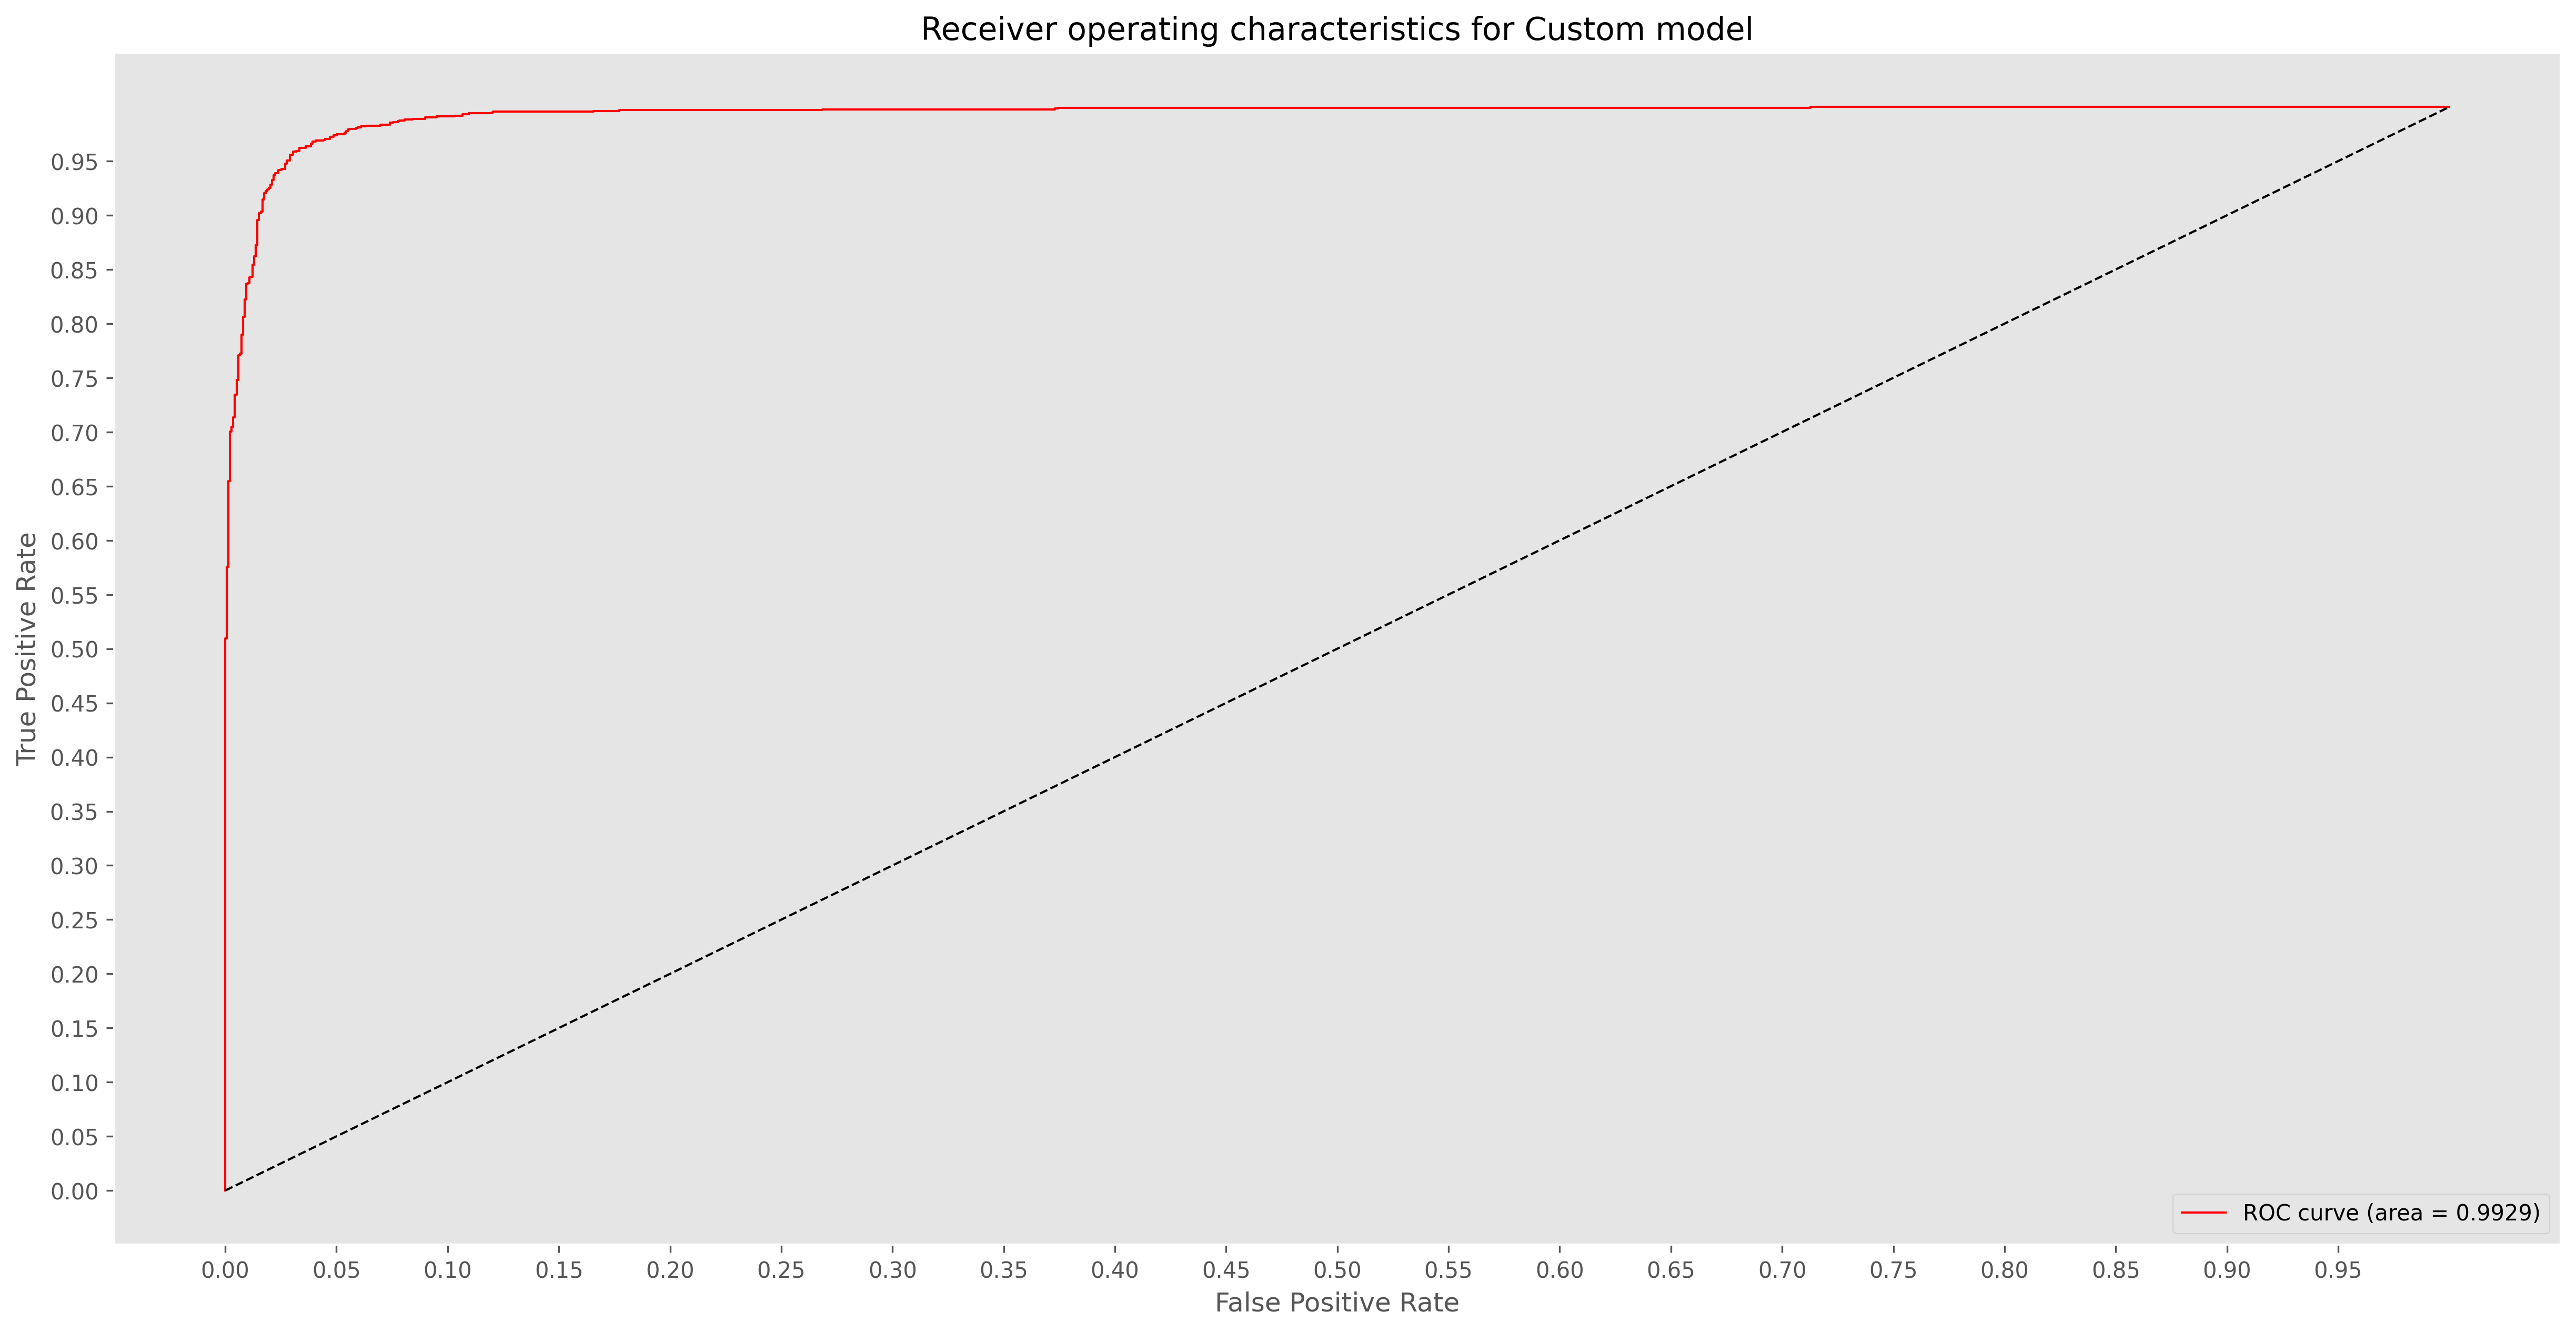

In [262]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, custom_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for Custom model')
plt.legend(loc="lower right")
plt.show()

In [263]:
#Evaluate the model by loading the best weights 
vgg19_custom_model.load_weights('weights/vgg19_custom.h5')

#evaluate accuracy
vgg19_custom_y_pred = vgg19_custom_model.predict(validation_generator,
                                                           nb_validation_samples/batch_size, workers=1)
vgg19_accuracy = accuracy_score(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
print('The accuracy of the VGG19 Custom model is: ', vgg19_accuracy)

#evaluate mean squared error
vgg19_custom_mse = mean_squared_error(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the VGG19 Custom model is: ', vgg19_custom_mse)

#evaluate mean squared log error
vgg19_custom_msle = mean_squared_log_error(Y_test,vgg19_custom_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the VGG19 Custom model is: ', vgg19_custom_msle)

The accuracy of the VGG19 Custom model is:  0.9782293178519593
The Mean Squared Error of the VGG19 Custom model is:  0.02177068214804064
The Mean Squared Log Error of the VGG19 Custom model is:  0.010459789853081308


                   precision    recall  f1-score   support

class 0(abnormal)     0.9817    0.9746    0.9782      1378
  class 1(normal)     0.9748    0.9819    0.9783      1378

         accuracy                         0.9782      2756
        macro avg     0.9783    0.9782    0.9782      2756
     weighted avg     0.9783    0.9782    0.9782      2756

Confusion matrix, without normalization
[[1343   35]
 [  25 1353]]


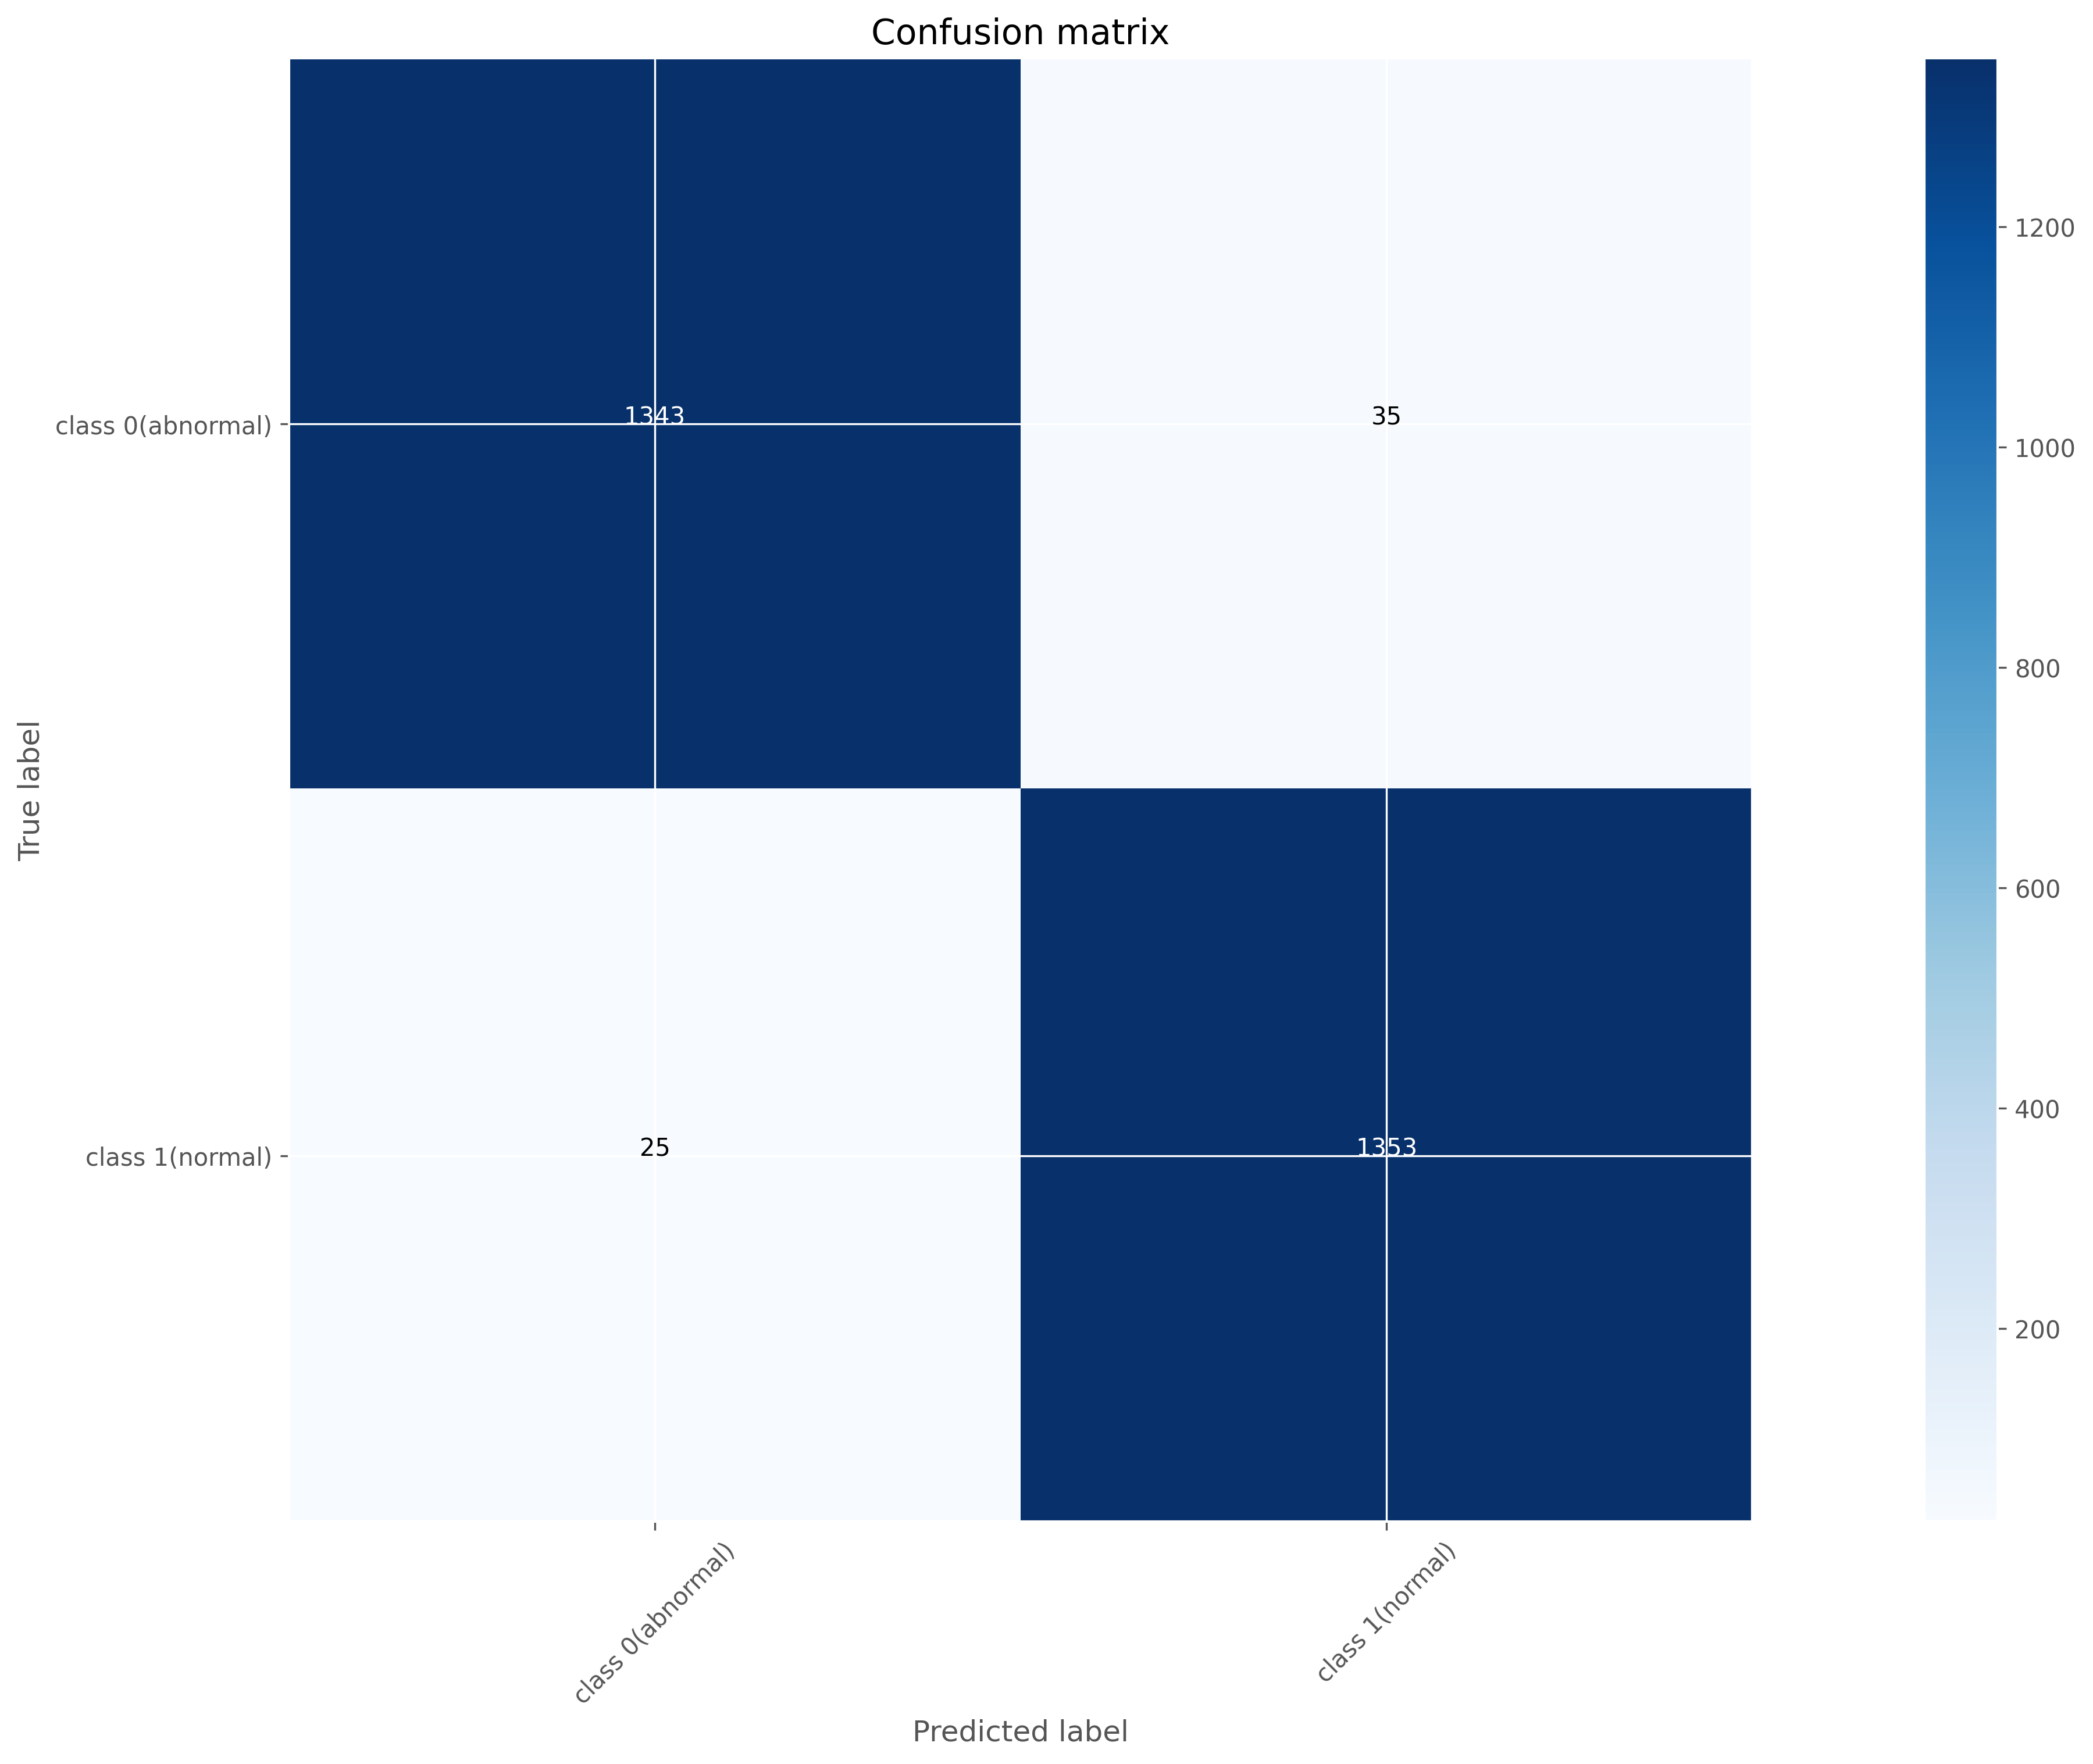

In [264]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,vgg19_custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


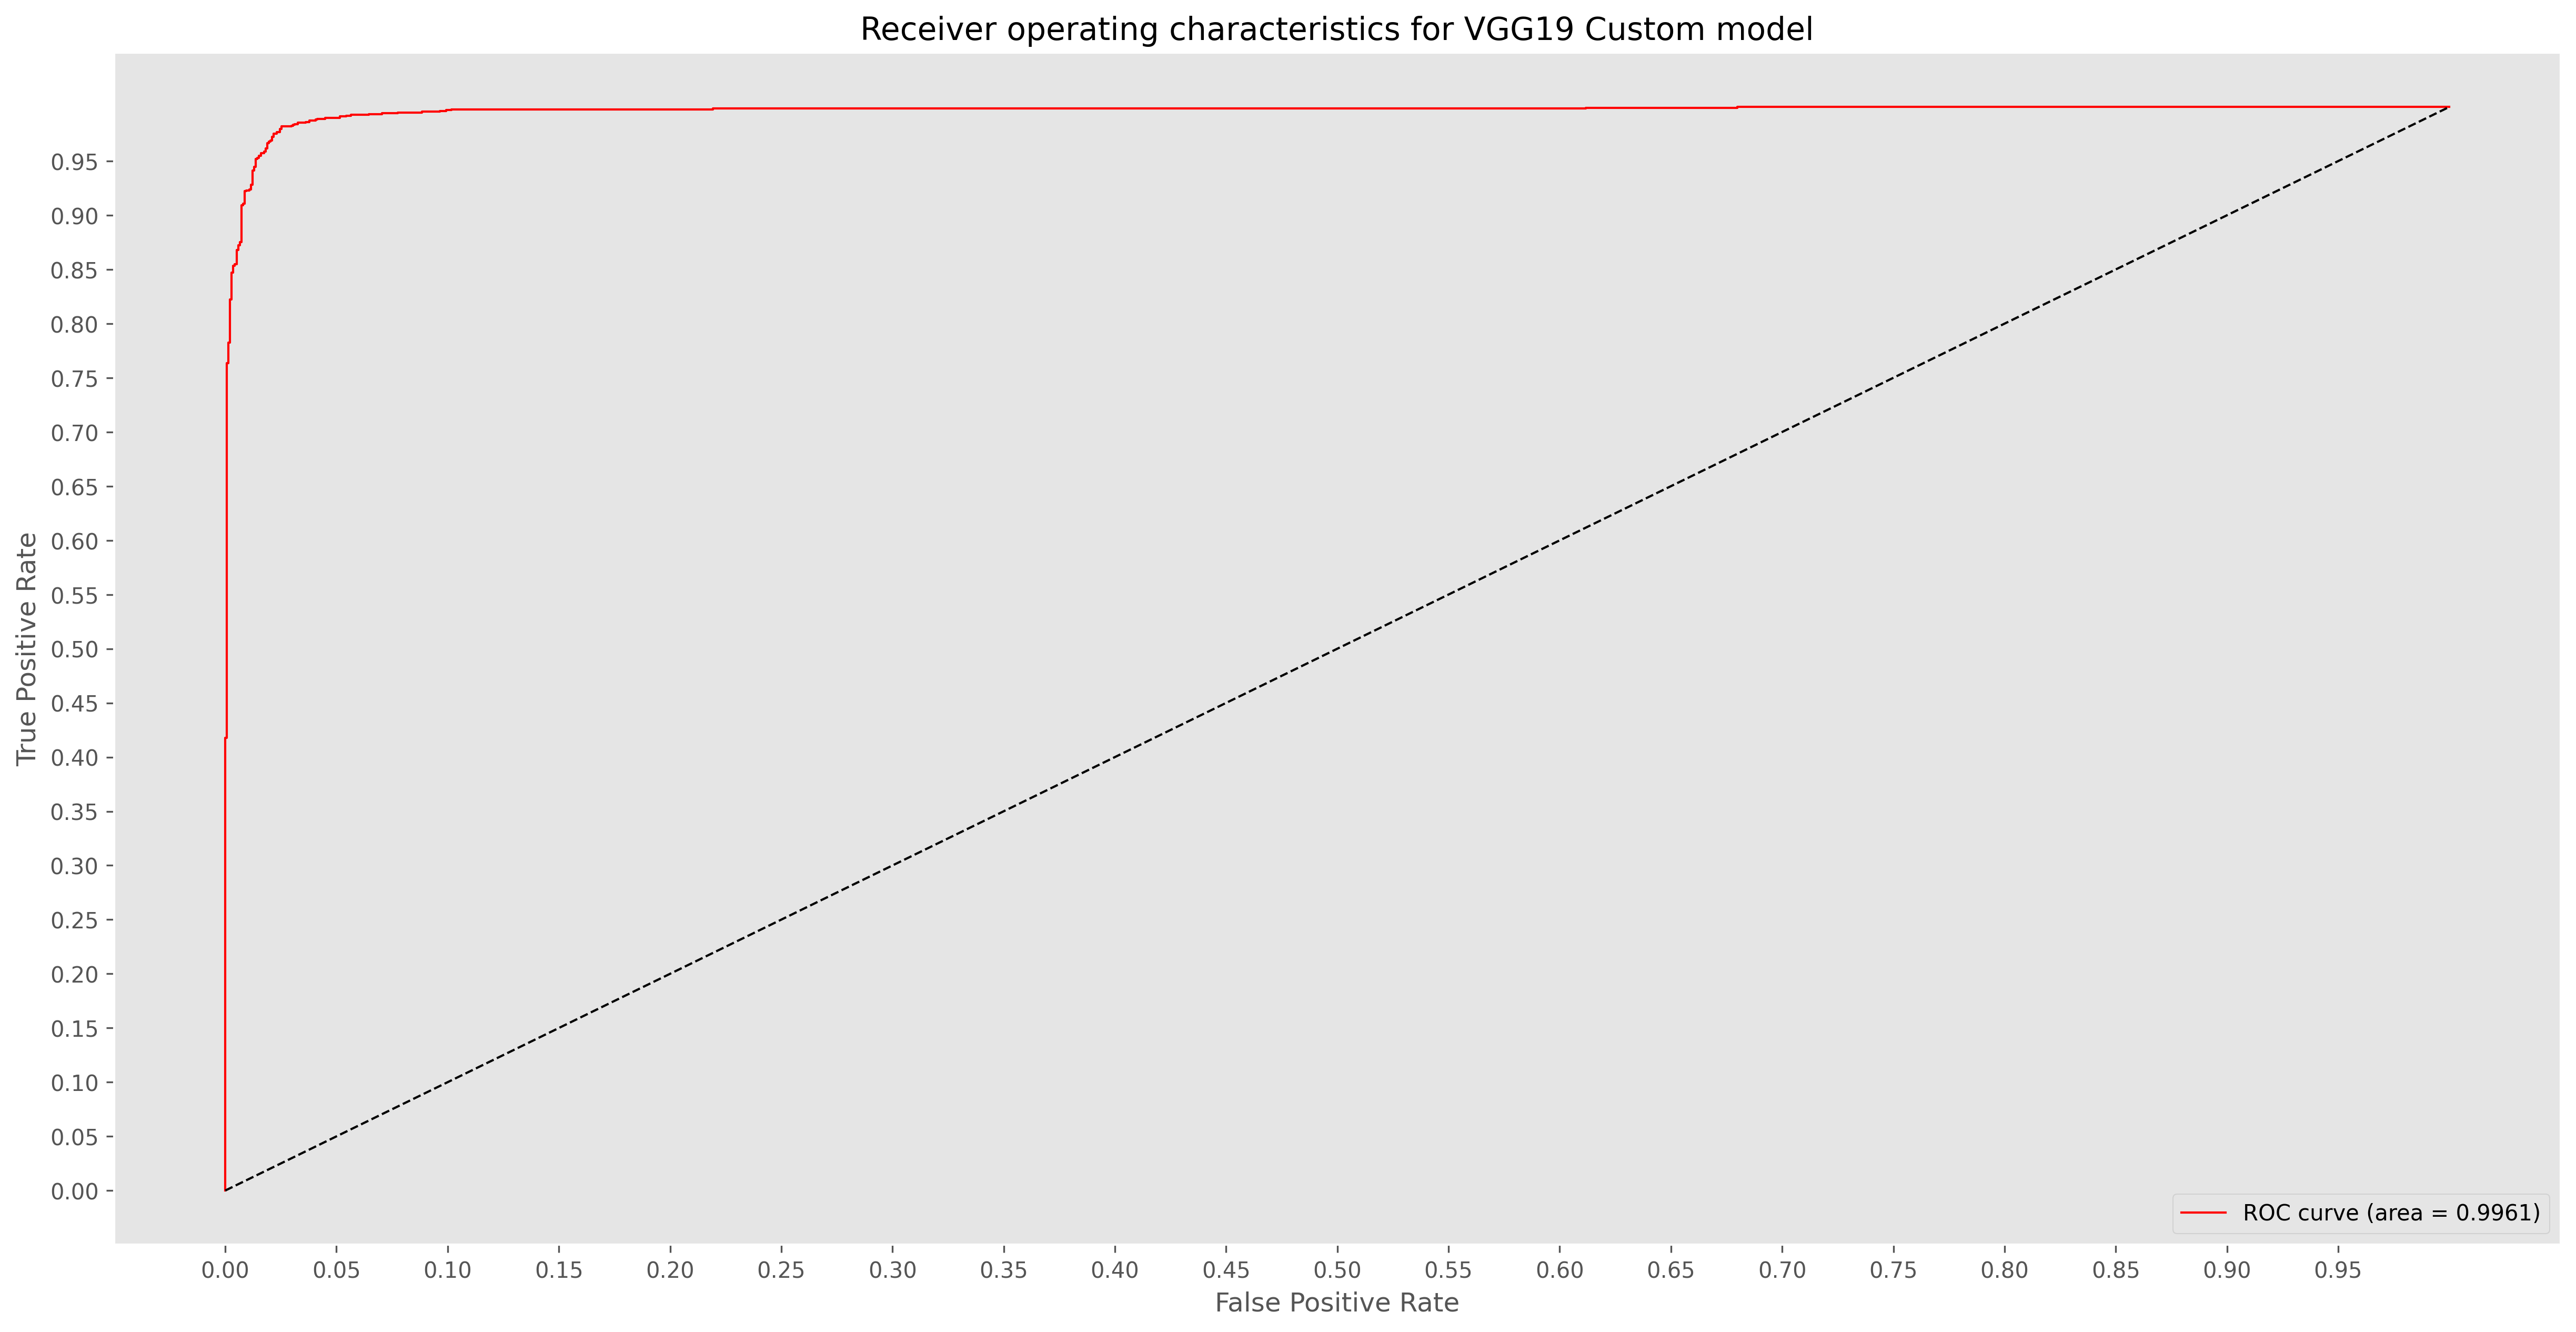

In [265]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, vgg19_custom_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for VGG19 Custom model')
plt.legend(loc="lower right")
plt.show()


In [266]:
#Evaluate the model by loading the best weights 
squeeze_custom_model.load_weights('weights/squeeze_custom.h5')

#evaluate accuracy

squeeze_y_pred = squeeze_custom_model.predict(validation_generator,
                                                        nb_validation_samples/batch_size, workers=1)
squeeze_accuracy = accuracy_score(Y_test,squeeze_y_pred.argmax(axis=-1))
print('The accuracy of the SqueezeNet Custom model is: ', squeeze_accuracy)

#evaluate mean squared error

squeeze_custom_mse = mean_squared_error(Y_test,squeeze_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the SqueezeNet Custom model is: ', squeeze_custom_mse)

#evaluate mean squared log error

squeeze_custom_msle = mean_squared_log_error(Y_test,squeeze_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the SqueezeNet Custom model is: ', squeeze_custom_msle)

The accuracy of the SqueezeNet Custom model is:  0.9753265602322206
The Mean Squared Error of the SqueezeNet Custom model is:  0.02467343976777939
The Mean Squared Log Error of the SqueezeNet Custom model is:  0.011854428500158814


                   precision    recall  f1-score   support

class 0(abnormal)     0.9788    0.9717    0.9752      1378
  class 1(normal)     0.9719    0.9790    0.9754      1378

         accuracy                         0.9753      2756
        macro avg     0.9754    0.9753    0.9753      2756
     weighted avg     0.9754    0.9753    0.9753      2756

Confusion matrix, without normalization
[[1339   39]
 [  29 1349]]


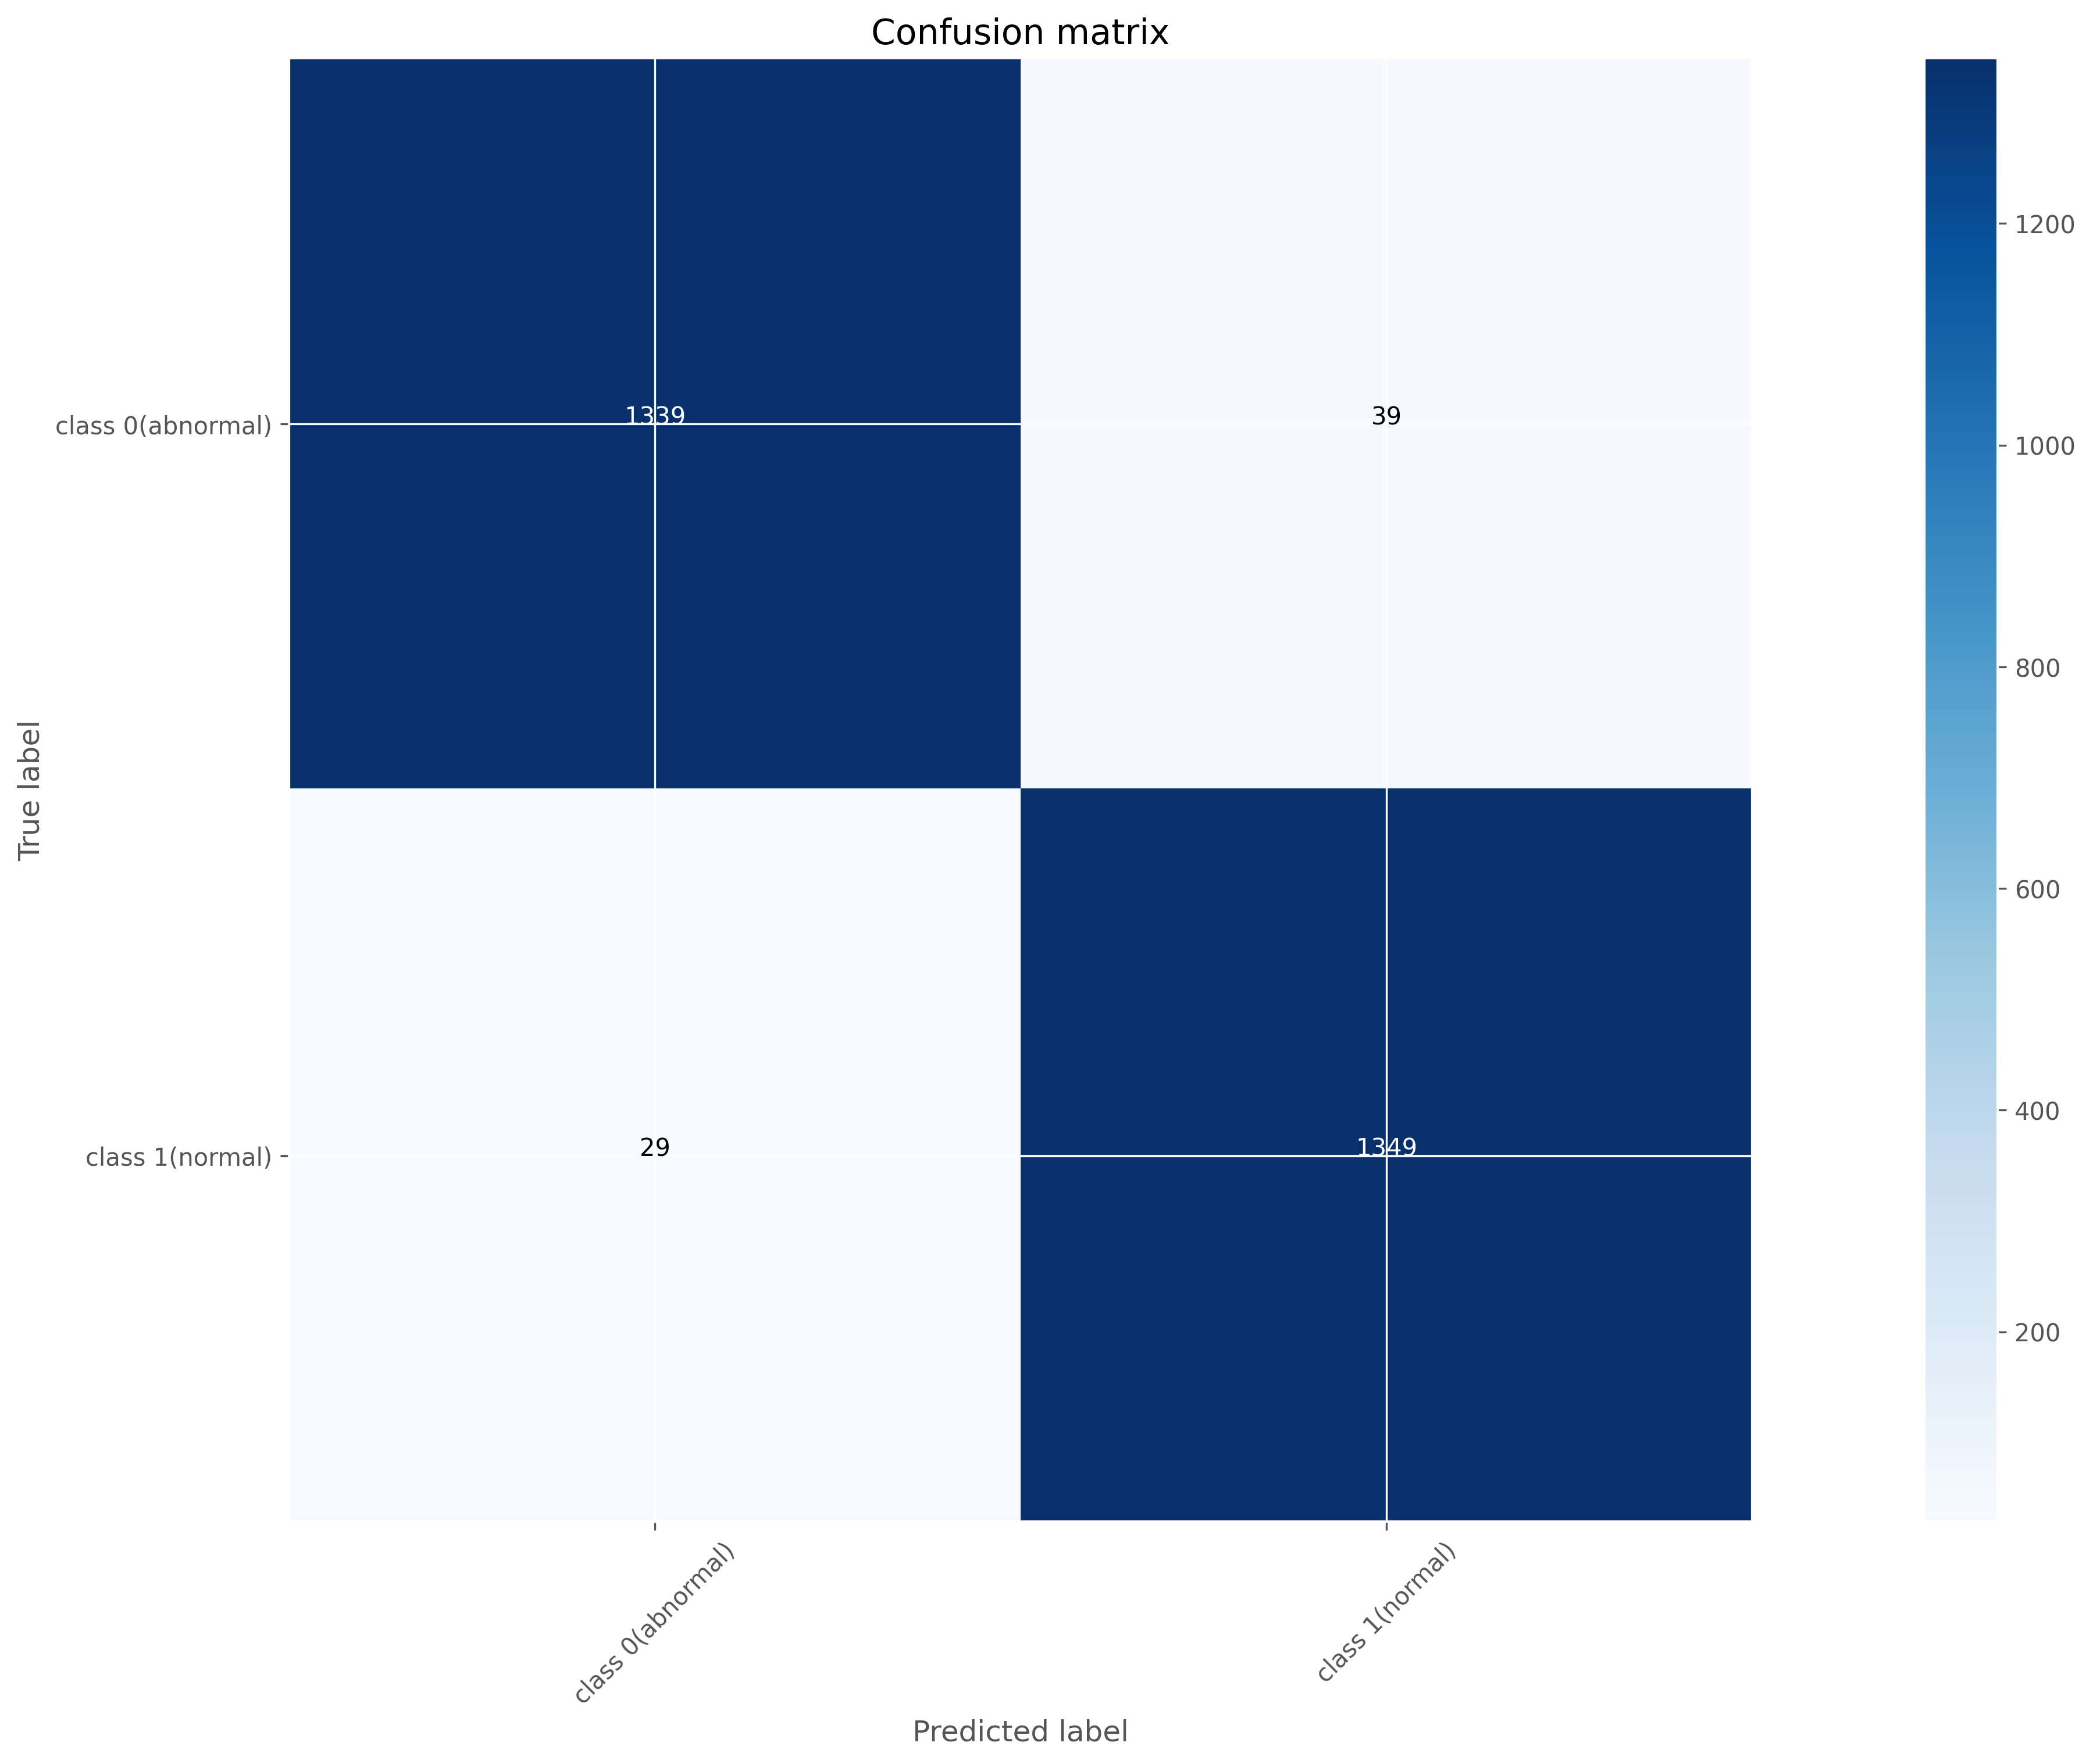

In [267]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,squeeze_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,squeeze_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


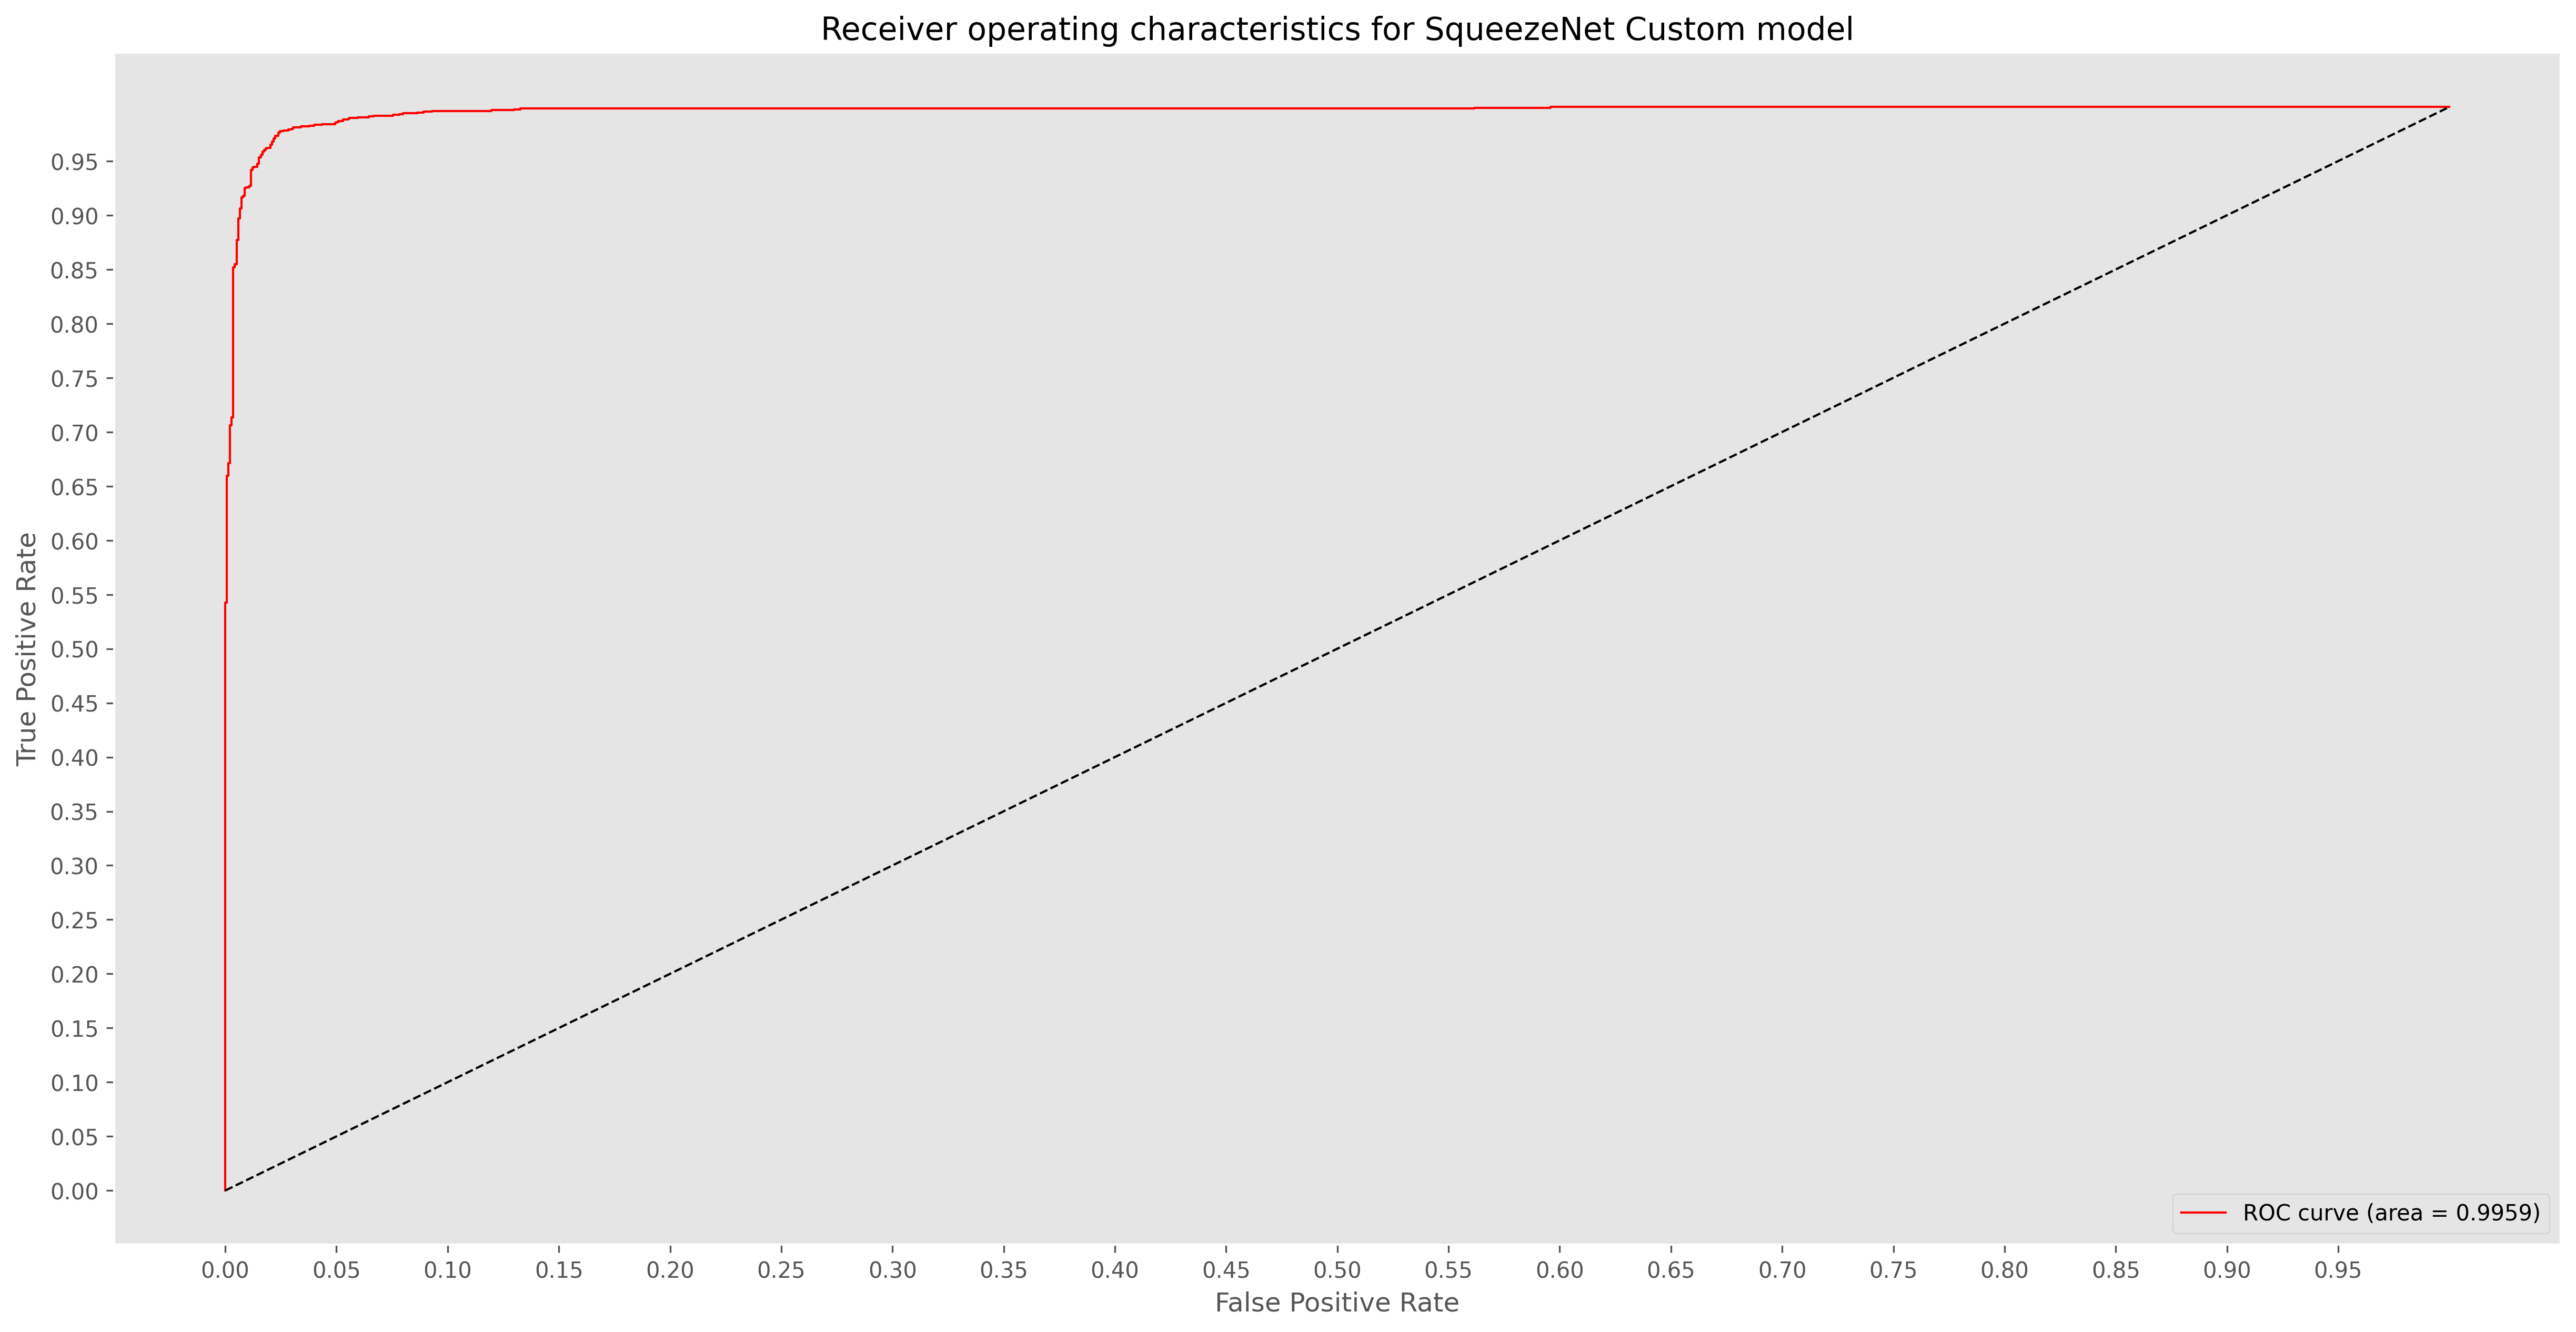

In [268]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, squeeze_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for SqueezeNet Custom model')
plt.legend(loc="lower right")
plt.show()


In [269]:
#Evaluate the model by loading the best weights 
inceptionresnet_custom_model.load_weights('weights/InceptionResnet_custom.h5')

#evaluate accuracy
incepres_y_pred = inceptionresnet_custom_model.predict(validation_generator,
                                                                 nb_validation_samples/batch_size, workers=1)
incepres_accuracy = accuracy_score(Y_test,incepres_y_pred.argmax(axis=-1))
print('The accuracy of the InceptionResNetV2 Custom model is: ', incepres_accuracy)

#evaluate mean squared error
incepres_custom_mse = mean_squared_error(Y_test,incepres_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the InceptionResNetv2 Custom model is: ', incepres_custom_mse)

#evaluate mean squared log error
incepres_custom_msle = mean_squared_log_error(Y_test,incepres_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the InceptionResNetv2 Custom model is: ', incepres_custom_msle)

The accuracy of the InceptionResNetV2 Custom model is:  0.9727866473149492
The Mean Squared Error of the InceptionResNetv2 Custom model is:  0.027213352685050797
The Mean Squared Log Error of the InceptionResNetv2 Custom model is:  0.013074737316351637


                   precision    recall  f1-score   support

class 0(abnormal)     0.9822    0.9630    0.9725      1378
  class 1(normal)     0.9637    0.9826    0.9731      1378

         accuracy                         0.9728      2756
        macro avg     0.9730    0.9728    0.9728      2756
     weighted avg     0.9730    0.9728    0.9728      2756

Confusion matrix, without normalization
[[1327   51]
 [  24 1354]]


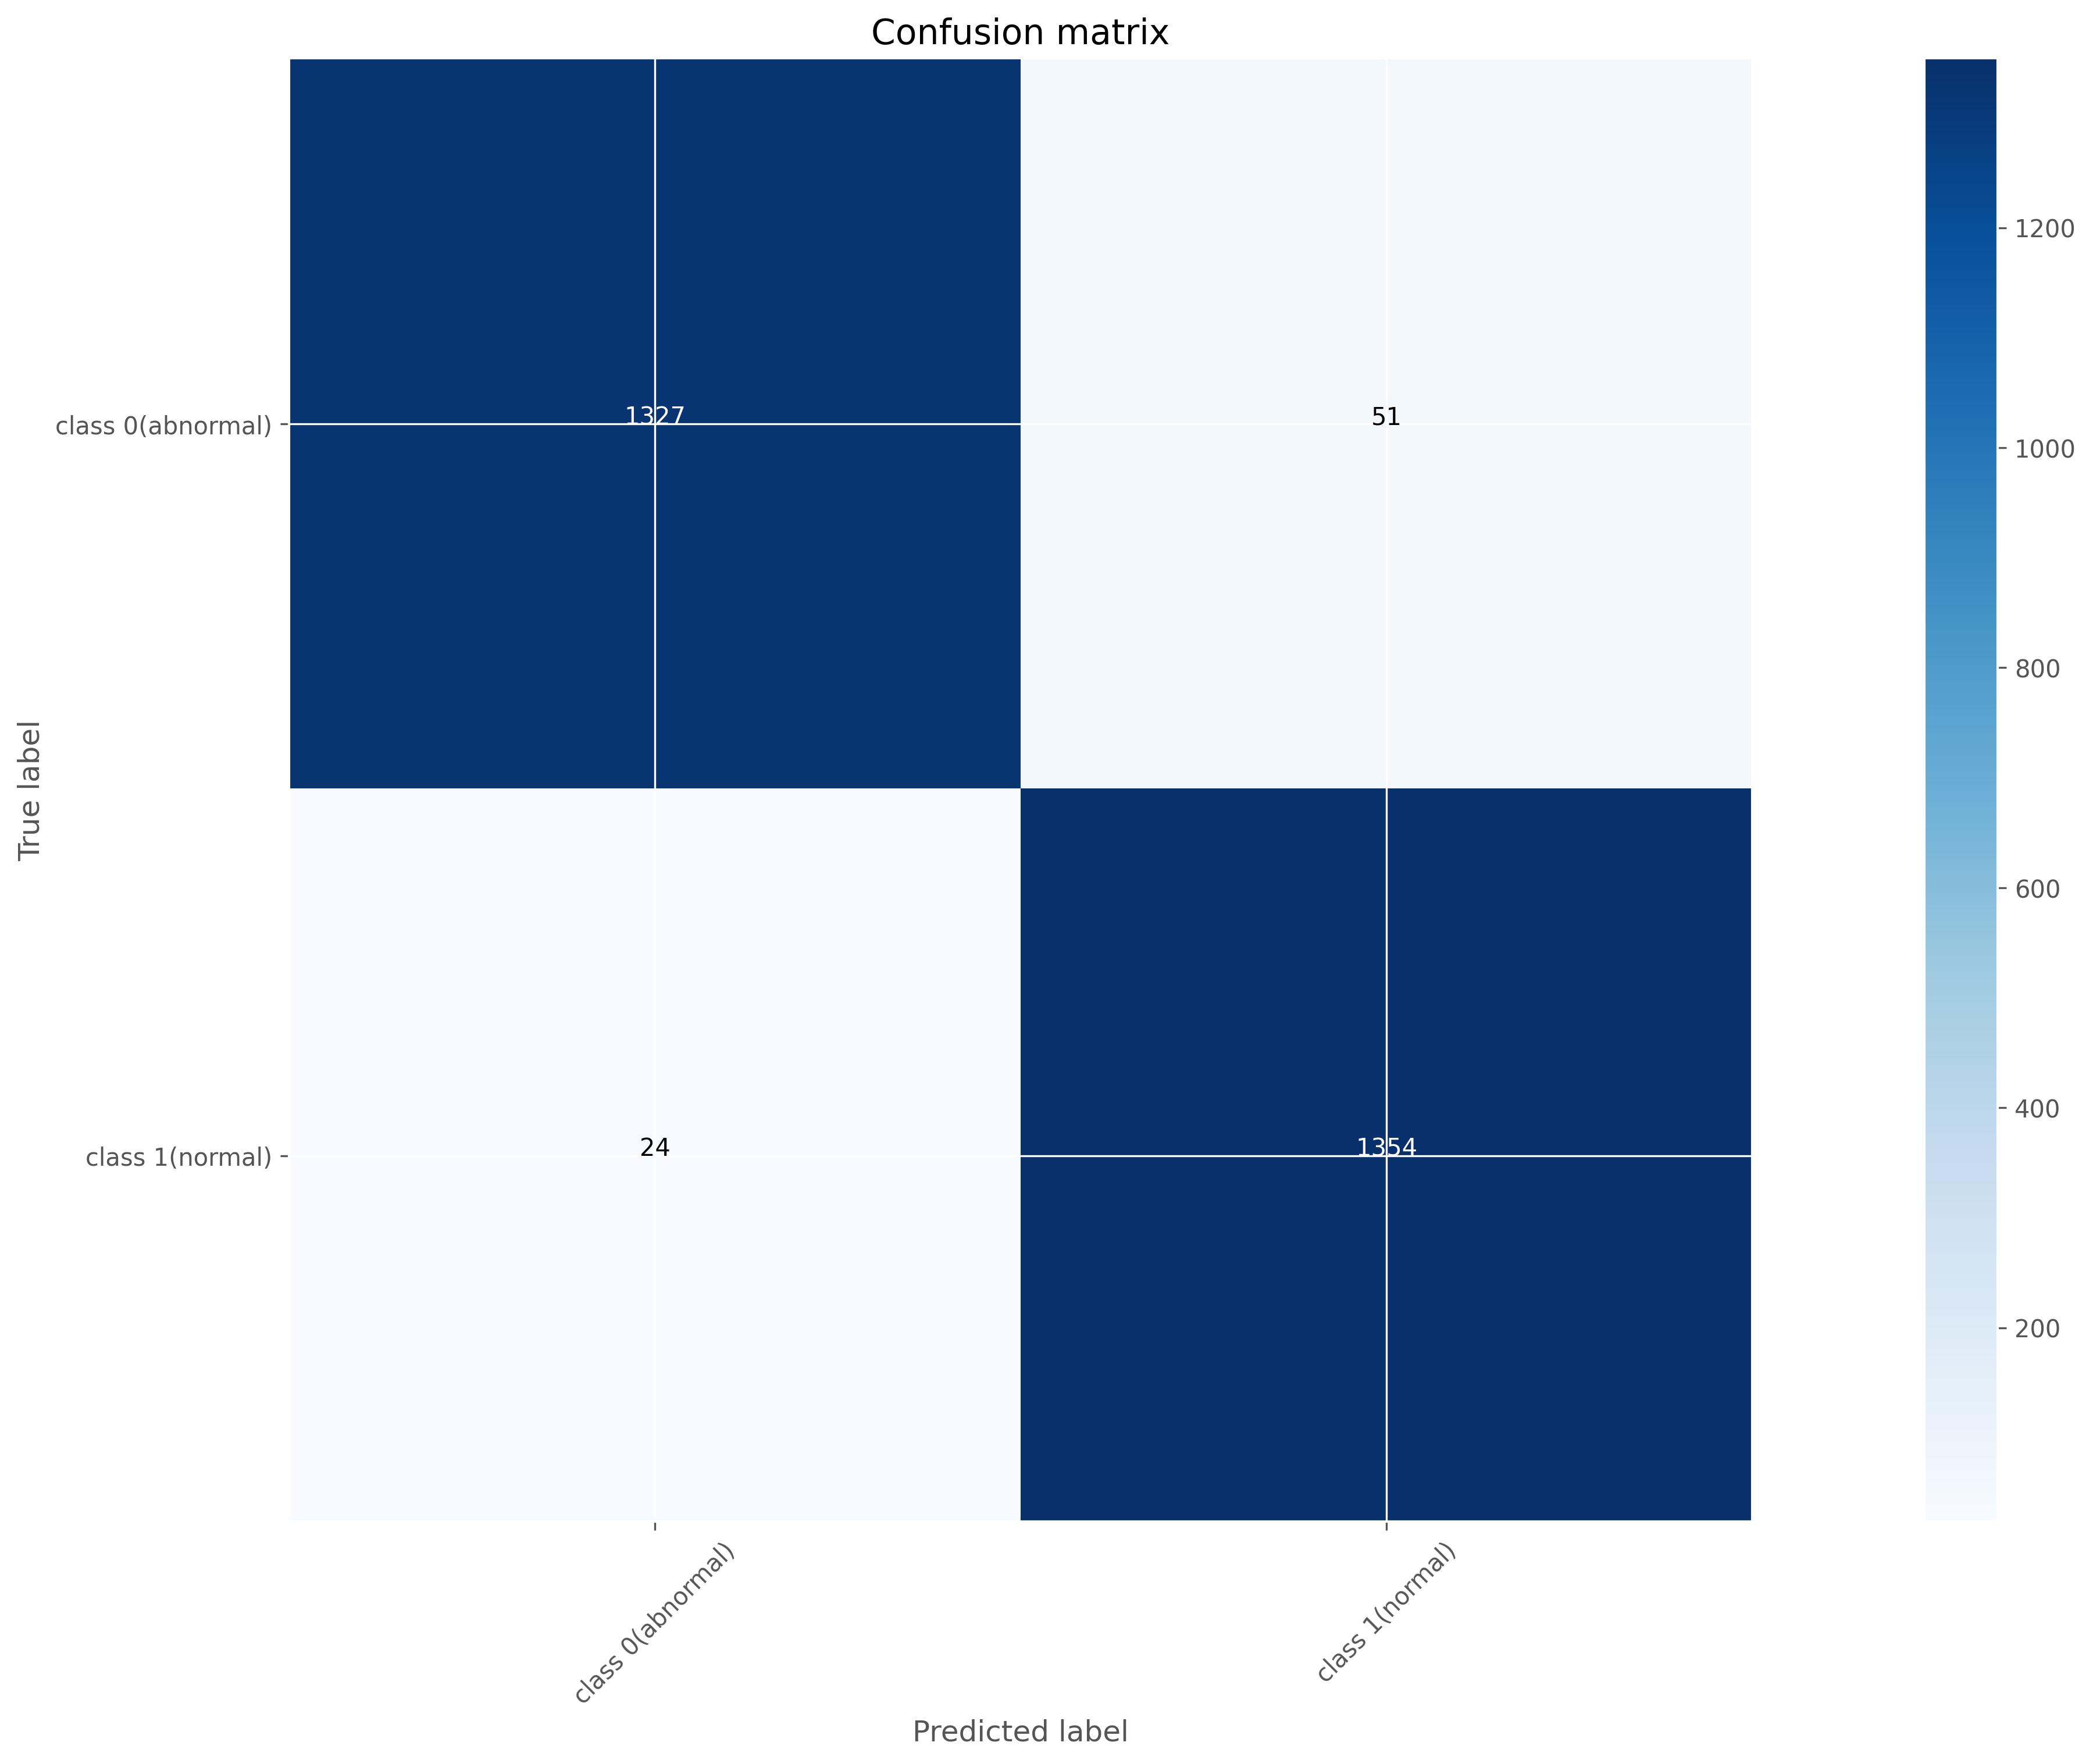

In [270]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,incepres_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,incepres_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


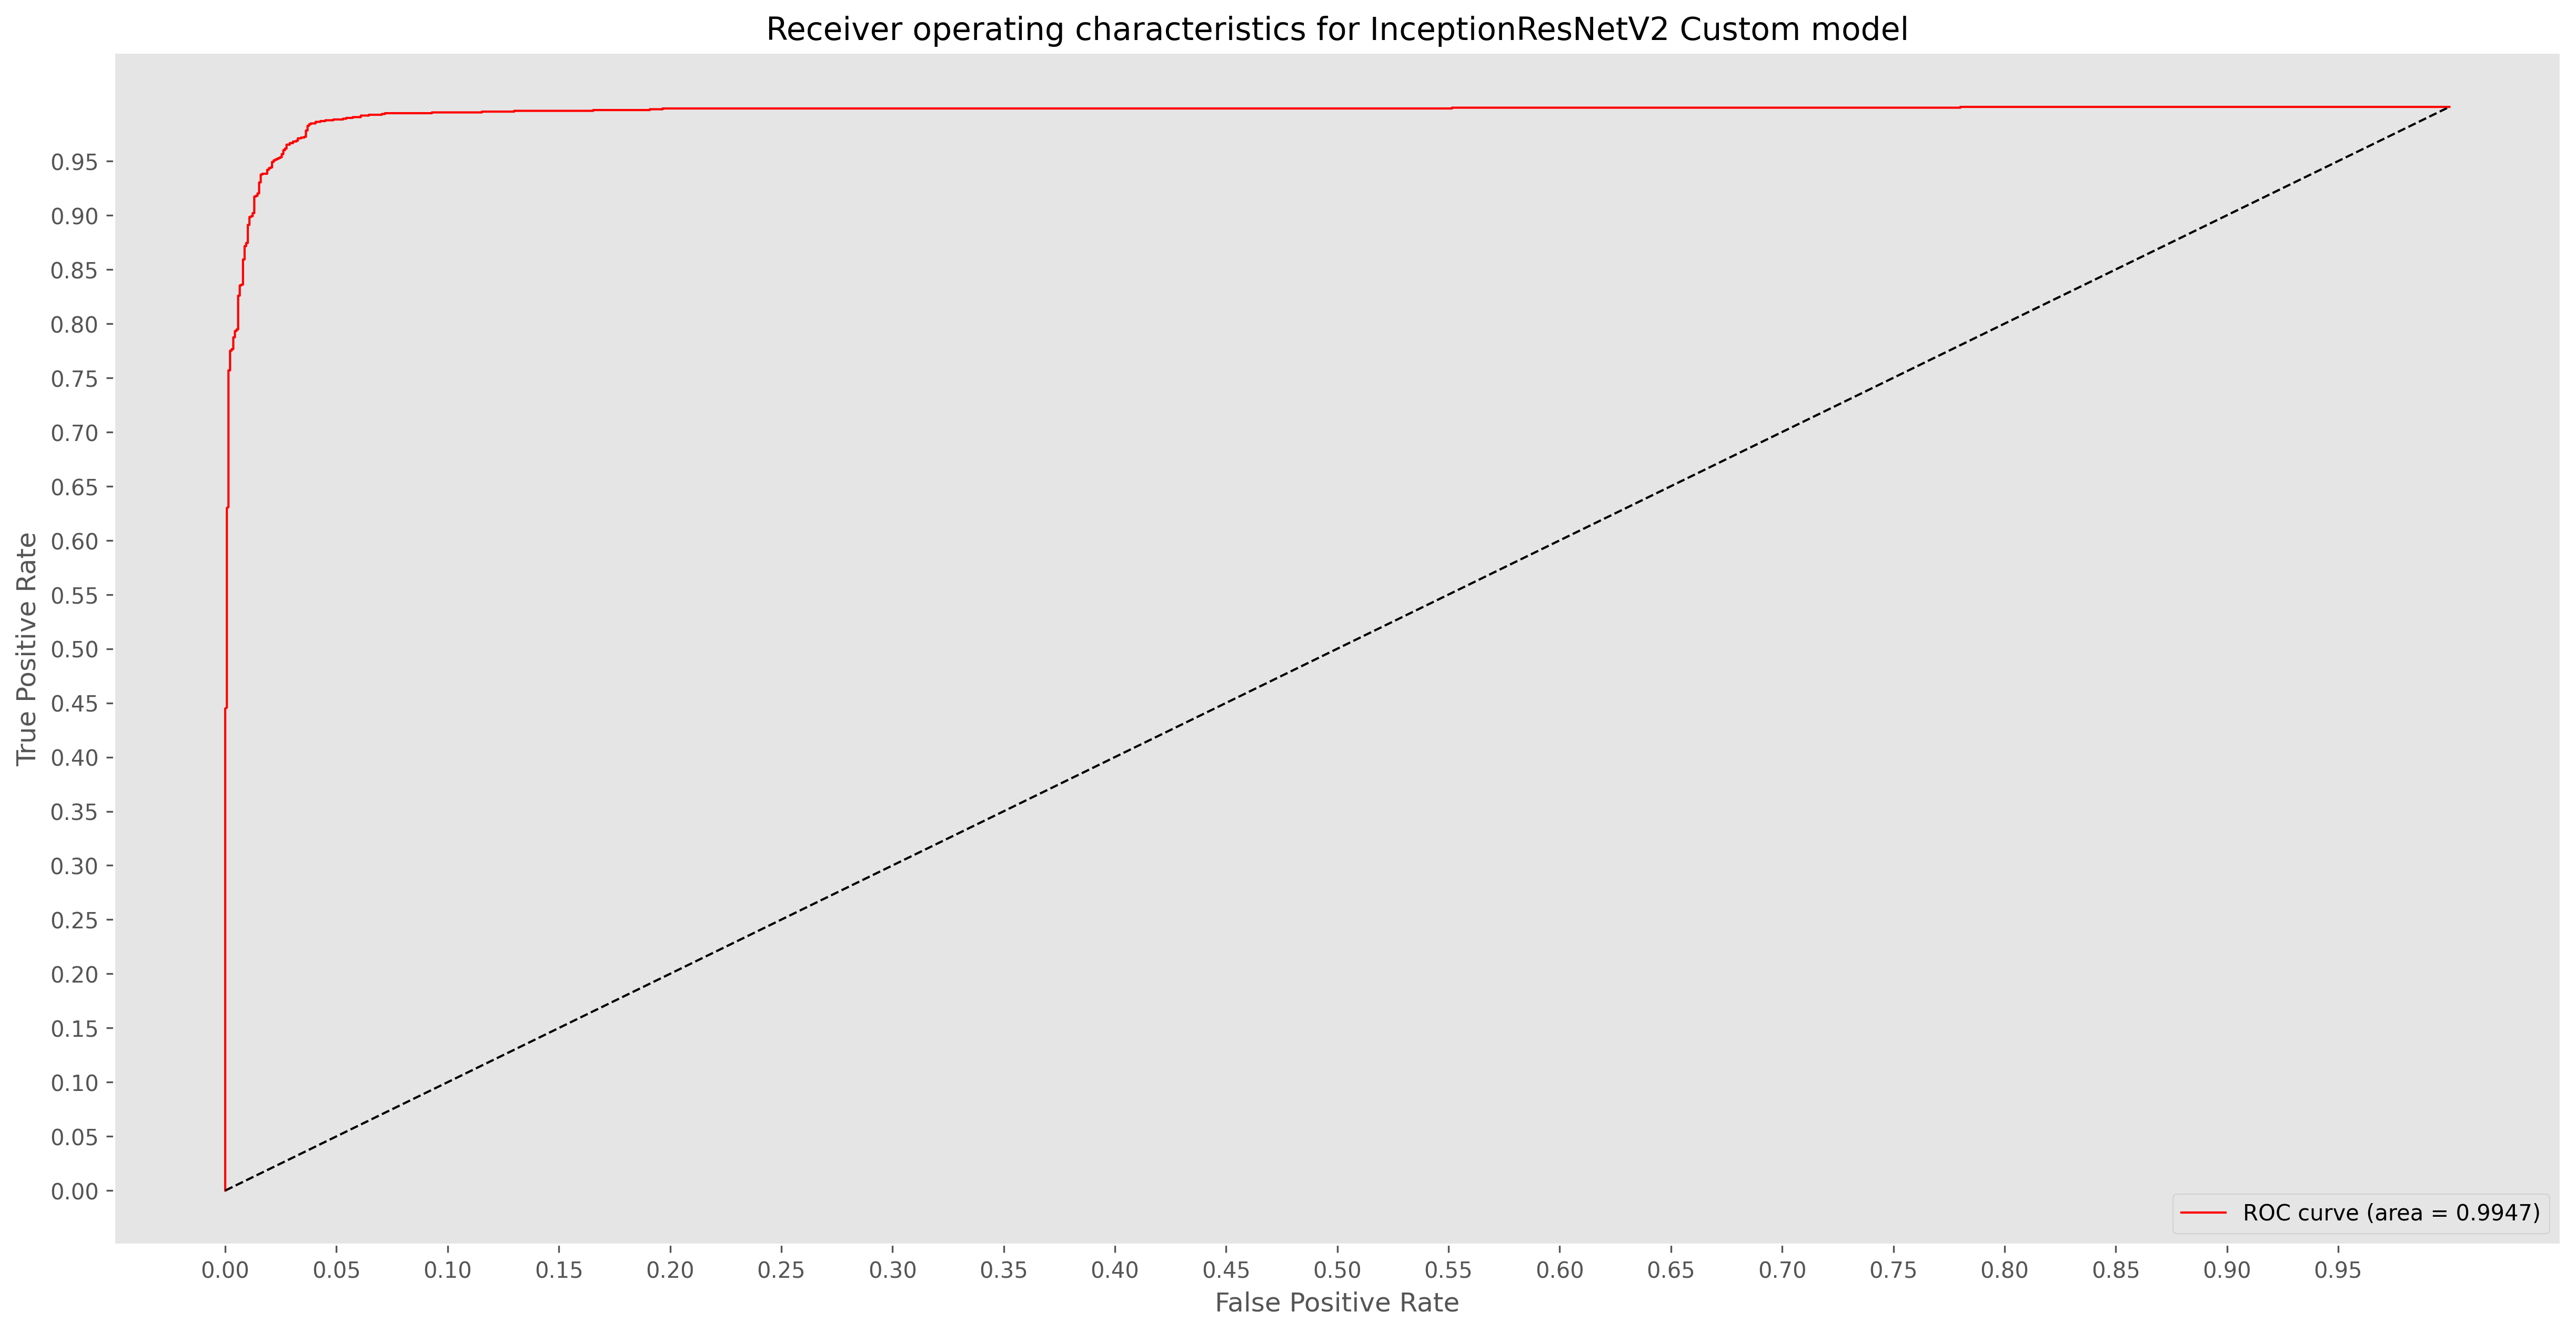

In [271]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, incepres_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for InceptionResNetV2 Custom model')
plt.legend(loc="lower right")
plt.show()


In [272]:
#%% construct the ensemble model
custom_model = custom_cnn(model_input)
vgg19_custom_model = vgg19_cnn(model_input)
squeeze_custom_model = squeeze_cnn(model_input)
inceptionresnet_custom_model = incepres_cnn(model_input)

#load the best weights
custom_model.load_weights('weights/custom_cnn.h5')
vgg19_custom_model.load_weights('weights/vgg19_custom.h5')
squeeze_custom_model.load_weights('weights/squeeze_custom.h5')
inceptionresnet_custom_model.load_weights('weights/InceptionResnet_custom.h5')

In [273]:
#append the models to the list

models = [custom_model, vgg19_custom_model, squeeze_custom_model, inceptionresnet_custom_model]

Ensemble model definition is very straightforward. It uses the same input layer thas is shared between all previous models. 
In the top layer, the ensemble computes the average of three models' outputs (predictions) by using Average() layer. The ensemble is expected to have a lower error rate than any single model and better accuracy.

In [274]:
def ensemble(models, model_input):
    
    outputs = [m.output for m in models]
    print(outputs)
    y = Average()(outputs) 
    model = Model(model_input, y, name='ensemble')
    return model

#istantitate the ensemble model and report the summary
ensemble_model = ensemble(models,model_input)

#save the ensemble model with the architecture and the weights together
ensemble_model.save('weights/ensemblemodel.h5')
print('The Ensemble Model is Saved')

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_39')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_40')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_41')>]
The Ensemble Model is Saved


In [275]:
#%% load the ensemble model and make predictions on the test data
ensemble_model=load_model('weights/ensemblemodel.h5')
ensemble_model.summary()
#plot_model(ensemble_model, to_file='ensemble_model.png',show_shapes=True, show_layer_names=False)

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2436 (Conv2D)            (None, 49, 49, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2451 (Batch (None, 49, 49, 32)   96          conv2d_2436[0][0]                
__________________________________________________________________________________________________
activation_2436 (Activation)    (None, 49, 49, 32)   0           batch_normalization_2451[0][0]   
___________________________________________________________________________________________

batch_normalization_2598 (Batch (None, 4, 4, 192)    576         conv2d_2583[0][0]                
__________________________________________________________________________________________________
activation_2580 (Activation)    (None, 4, 4, 192)    0           batch_normalization_2595[0][0]   
__________________________________________________________________________________________________
activation_2583 (Activation)    (None, 4, 4, 192)    0           batch_normalization_2598[0][0]   
__________________________________________________________________________________________________
block17_18_mixed (Concatenate)  (None, 4, 4, 384)    0           activation_2580[0][0]            
                                                                 activation_2583[0][0]            
__________________________________________________________________________________________________
block17_18_conv (Conv2D)        (None, 4, 4, 1088)   418880      block17_18_mixed[0][0]           
__________

__________________________________________________________________________________________________
conv2d_2601 (Conv2D)            (None, 1, 1, 224)    129024      activation_2600[0][0]            
__________________________________________________________________________________________________
batch_normalization_2616 (Batch (None, 1, 1, 224)    672         conv2d_2601[0][0]                
__________________________________________________________________________________________________
activation_2601 (Activation)    (None, 1, 1, 224)    0           batch_normalization_2616[0][0]   
__________________________________________________________________________________________________
conv2d_2599 (Conv2D)            (None, 1, 1, 192)    399360      mixed_7a[0][0]                   
__________________________________________________________________________________________________
conv2d_2602 (Conv2D)            (None, 1, 1, 256)    172032      activation_2601[0][0]            
__________

In [276]:
#evaluate accuracy
ensem_y_pred = ensemble_model.predict(validation_generator,
                                                nb_validation_samples/batch_size, workers=1)
ensemble_model_accuracy = accuracy_score(Y_test,ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Ensemble model is: ', ensemble_model_accuracy)

#evaluate mean squared error
ensemble_model_custom_mse = mean_squared_error(Y_test,ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Ensemble model is: ', ensemble_model_custom_mse)

#evaluate mean squared log error
ensemble_model_custom_msle = mean_squared_log_error(Y_test,ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Ensemble model is: ', ensemble_model_custom_msle)

The accuracy of the Ensemble model is:  0.974600870827286
The Mean Squared Error of the Ensemble model is:  0.02539912917271408
The Mean Squared Log Error of the Ensemble model is:  0.01220308816192819


                   precision    recall  f1-score   support

class 0(abnormal)     0.9837    0.9652    0.9744      1378
  class 1(normal)     0.9658    0.9840    0.9748      1378

         accuracy                         0.9746      2756
        macro avg     0.9748    0.9746    0.9746      2756
     weighted avg     0.9748    0.9746    0.9746      2756

Confusion matrix, without normalization
[[1330   48]
 [  22 1356]]


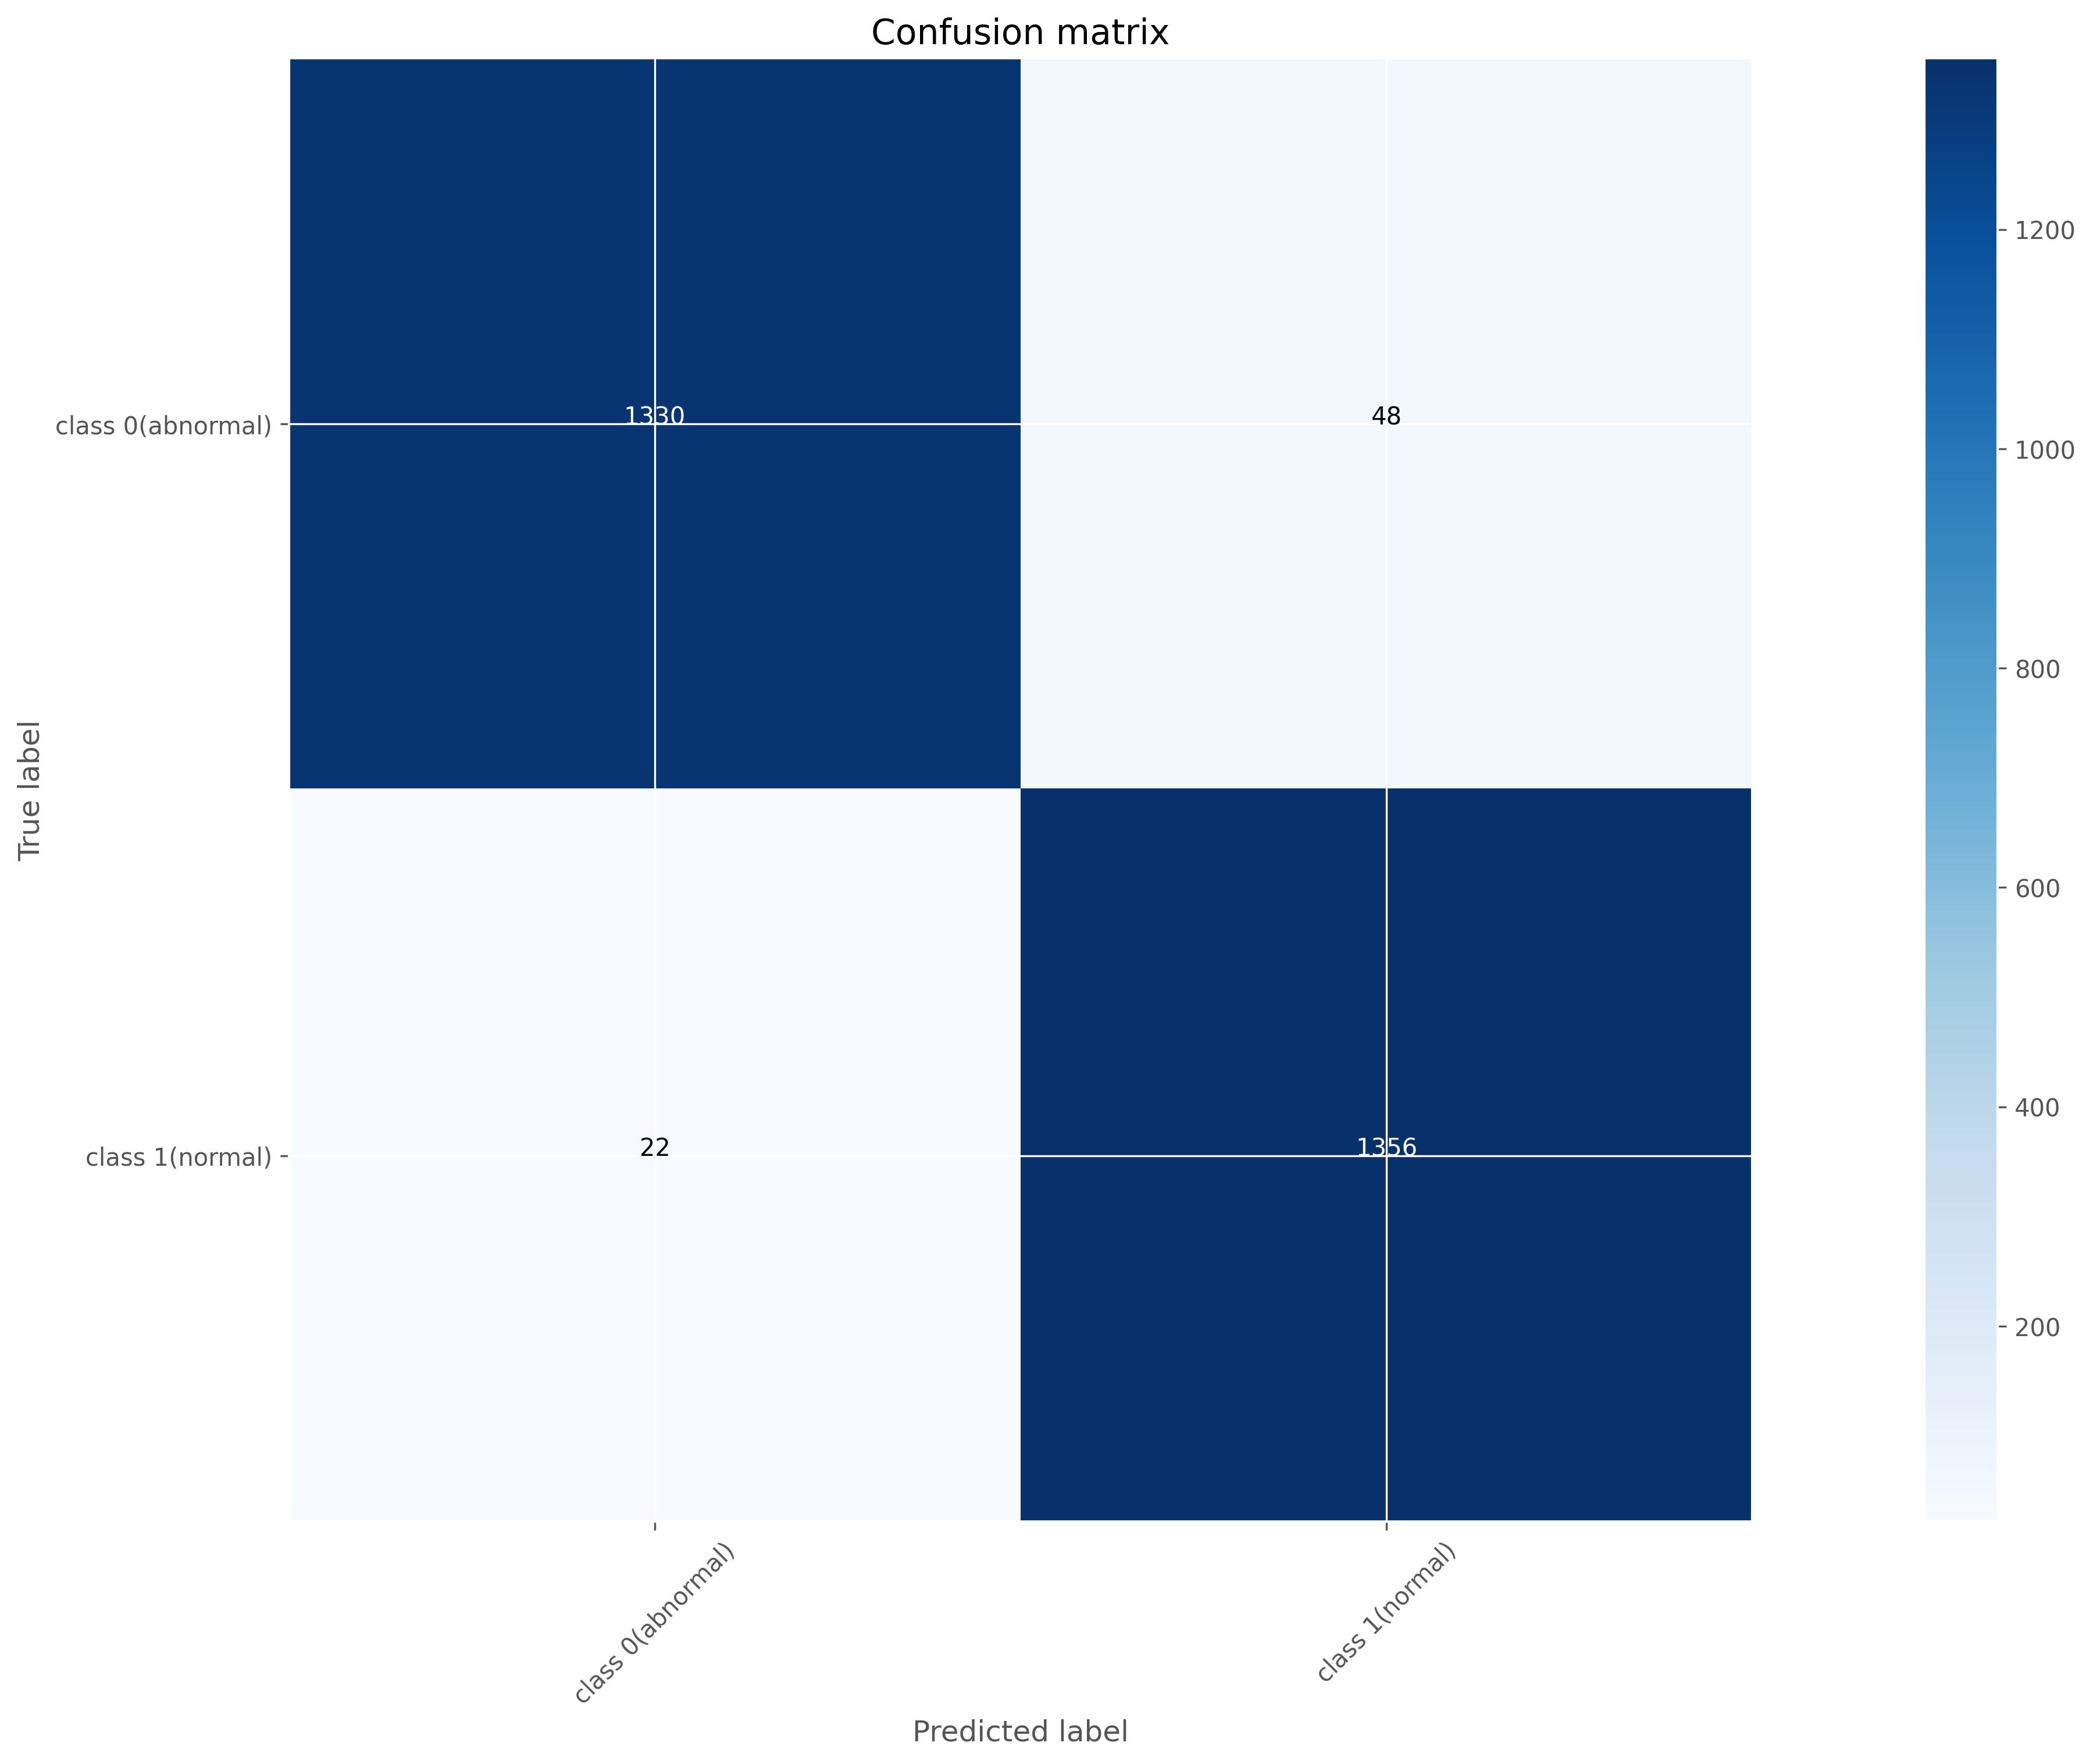

In [277]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


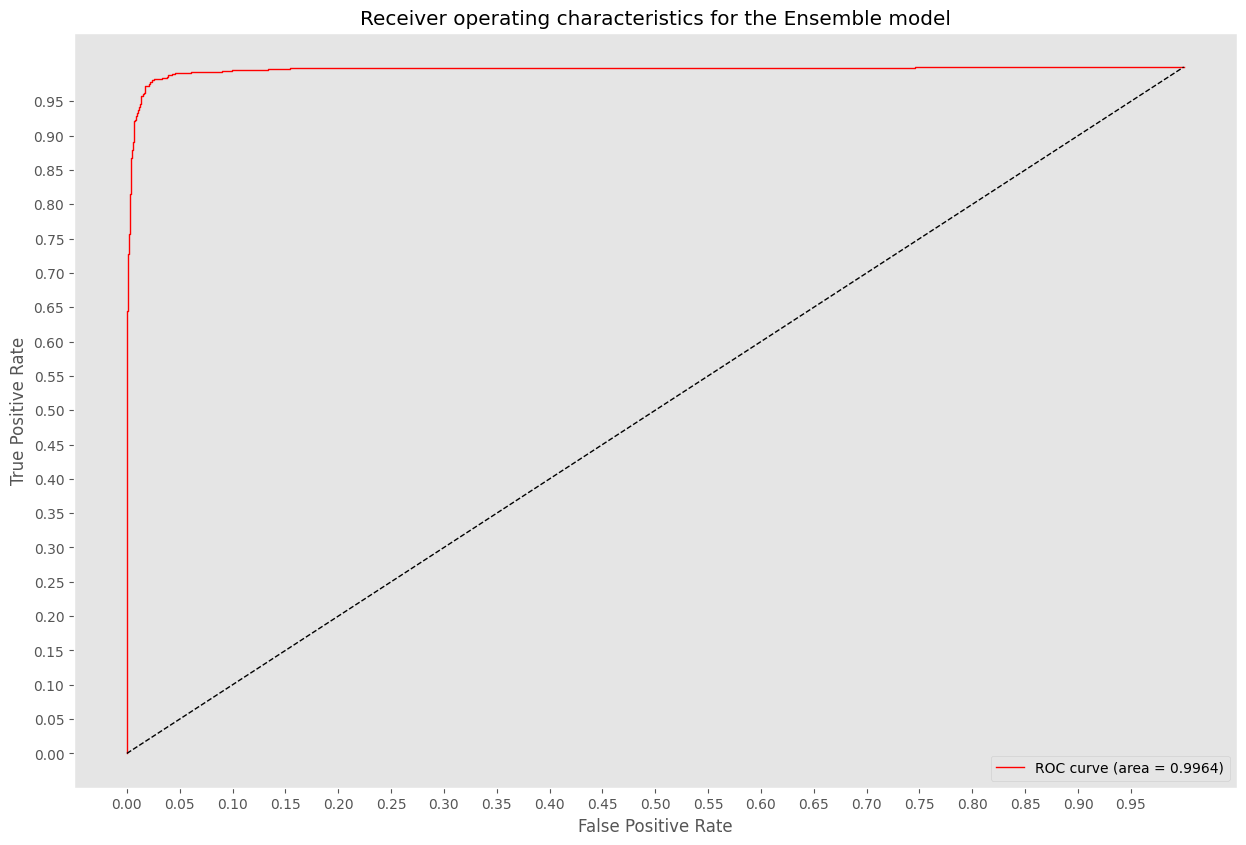

In [278]:
#%% compute the ROC-AUC values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for the Ensemble model')
plt.legend(loc="lower right")
plt.show()


In [279]:
#%% Other Possible Ensembles: 
# We can select the optimal ensemble from the collection of model combinations

pair_A = [custom_model, vgg19_custom_model]
pair_B = [custom_model, squeeze_custom_model]
pair_C = [custom_model, inceptionresnet_custom_model]
pair_D = [vgg19_custom_model, squeeze_custom_model]
pair_E = [vgg19_custom_model, inceptionresnet_custom_model]
pair_F = [squeeze_custom_model, inceptionresnet_custom_model]
pair_G = [custom_model, vgg19_custom_model, squeeze_custom_model]
pair_H = [custom_model, vgg19_custom_model, inceptionresnet_custom_model]
pair_I = [vgg19_custom_model, squeeze_custom_model, inceptionresnet_custom_model]

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_39')>]
The Ensemble Model is Saved
The accuracy of the Pair A Ensemble model is:  0.9724238026124818
The Mean Squared Error of the Pair A Ensemble model is:  0.027576197387518143
The Mean Squared Log Error of the Pair A Ensemble model is:  0.013249067147236322
                   precision    recall  f1-score   support

class 0(abnormal)     0.9822    0.9623    0.9721      1378
  class 1(normal)     0.9630    0.9826    0.9727      1378

         accuracy                         0.9724      2756
        macro avg     0.9726    0.9724    0.9724      2756
     weighted avg     0.9726    0.9724    0.9724      2756

Confusion matrix, without normalization
[[1326   52]
 [  24 1354]]


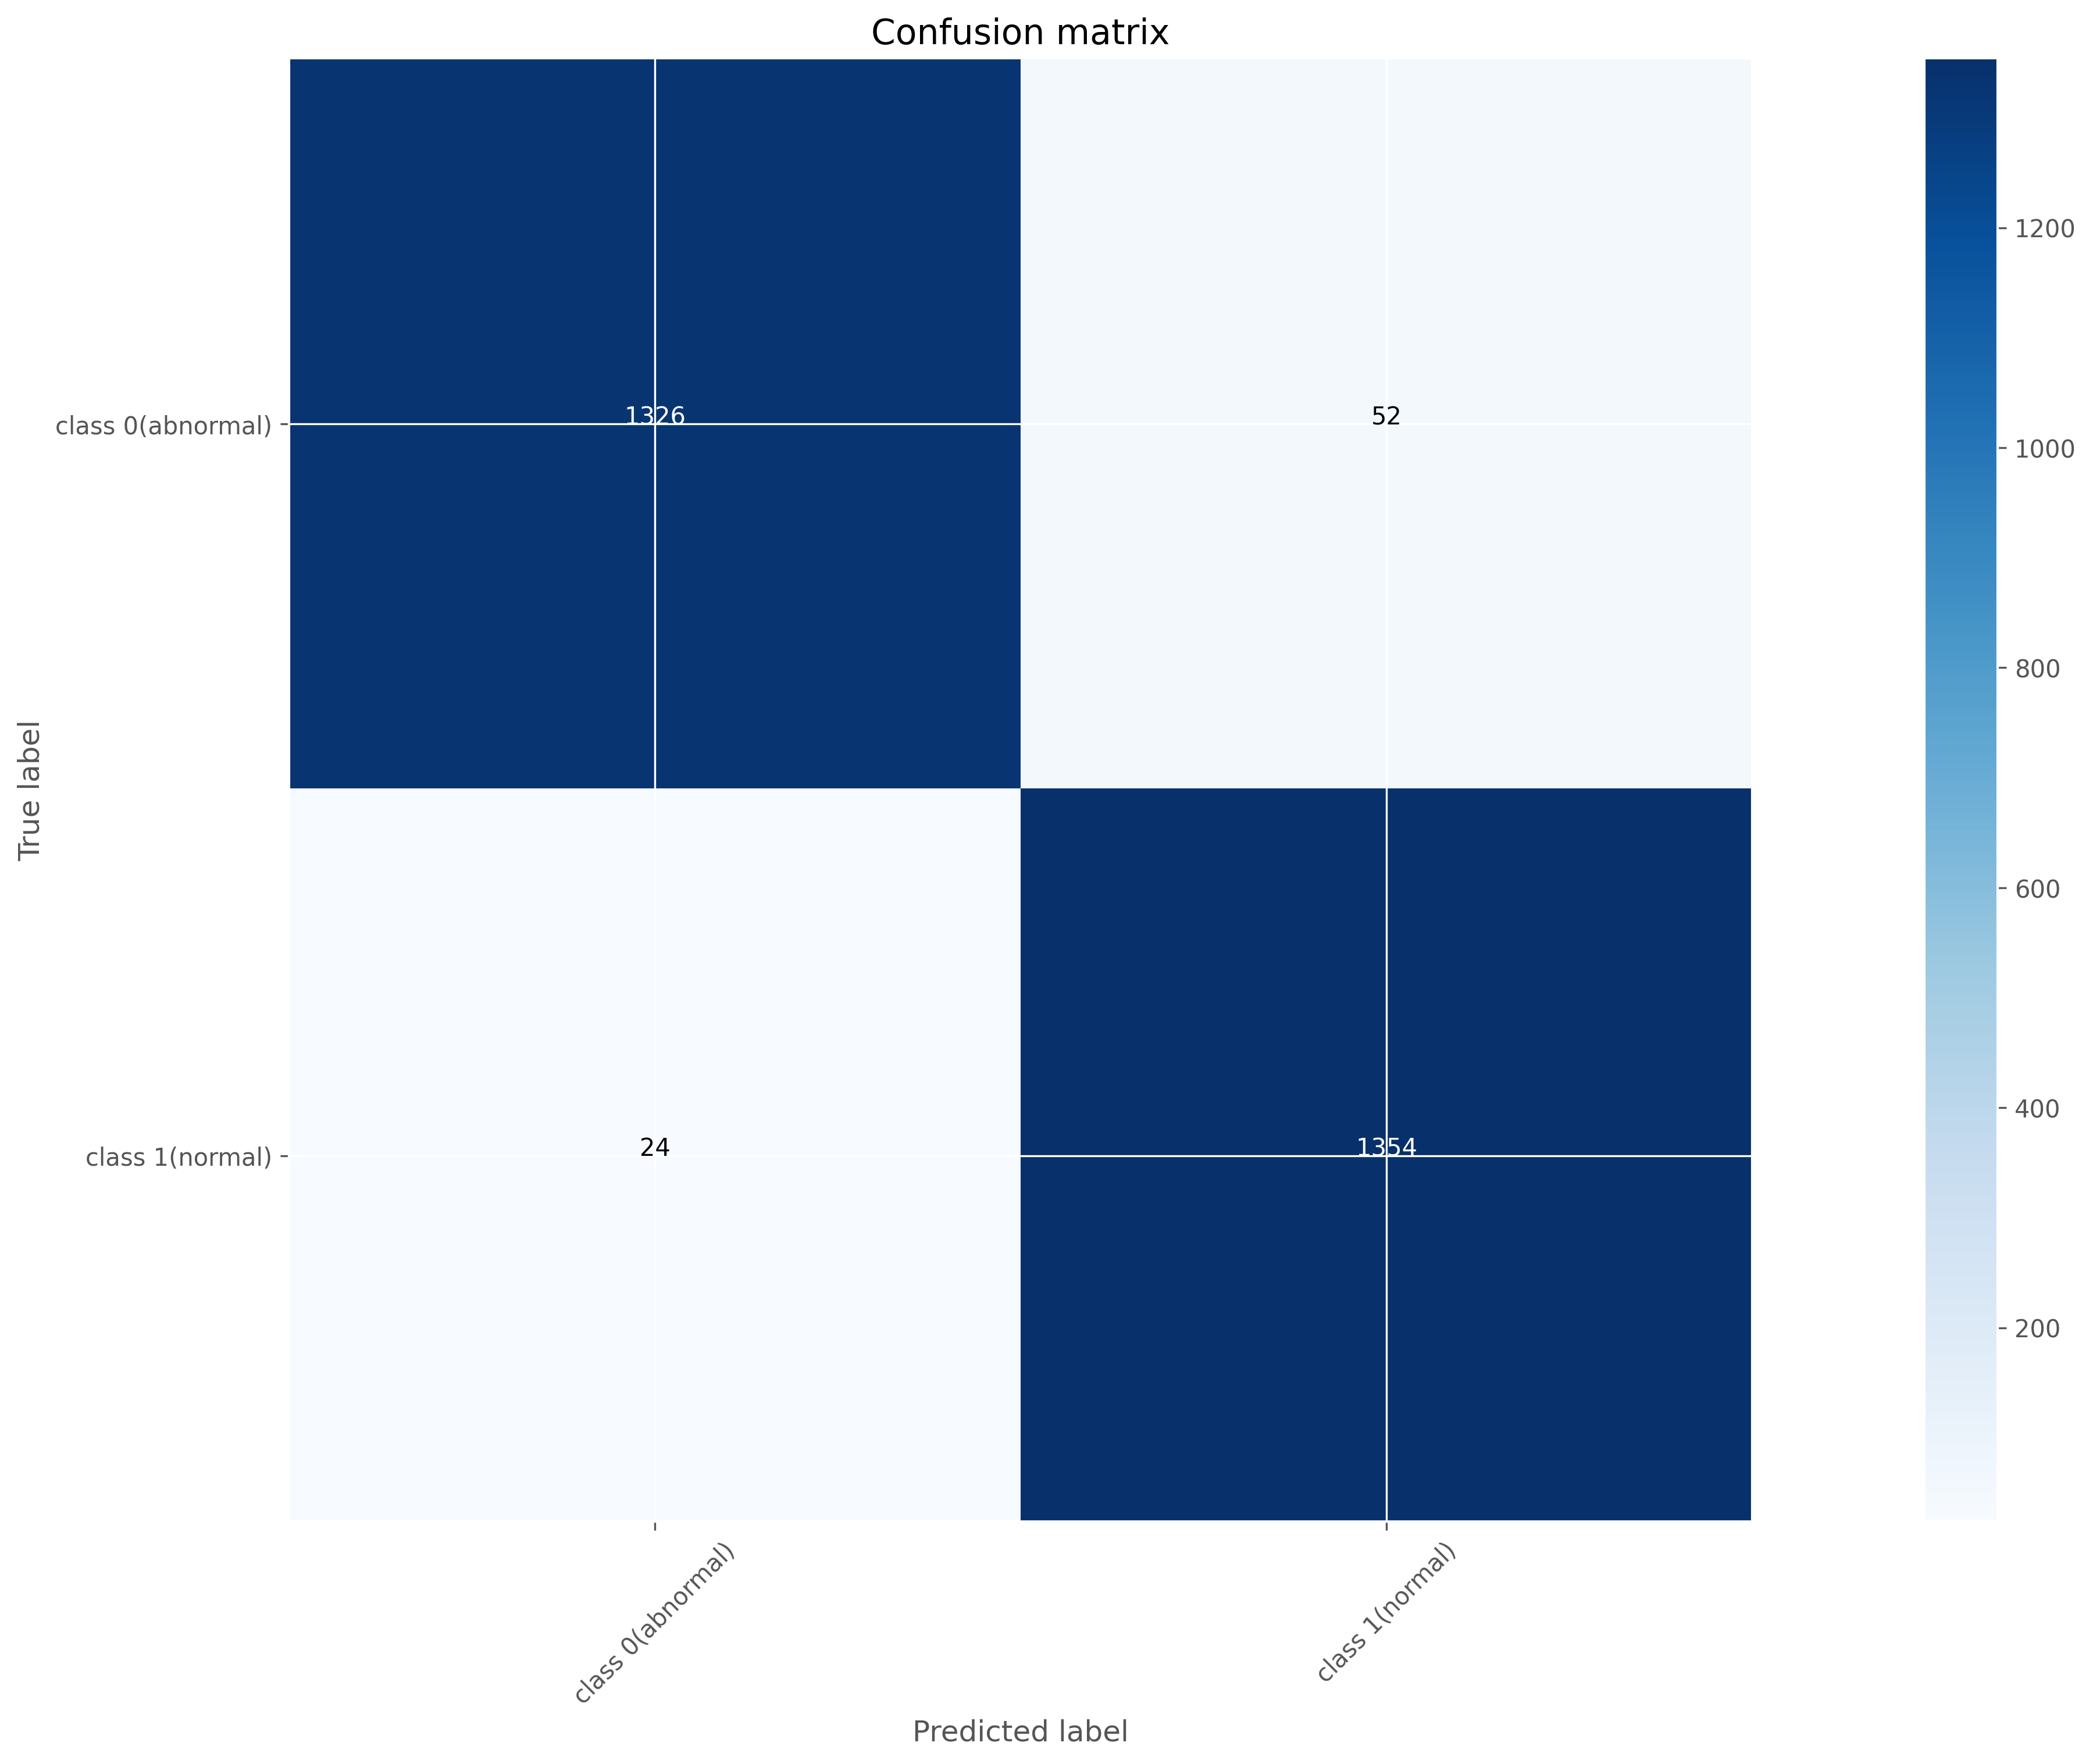

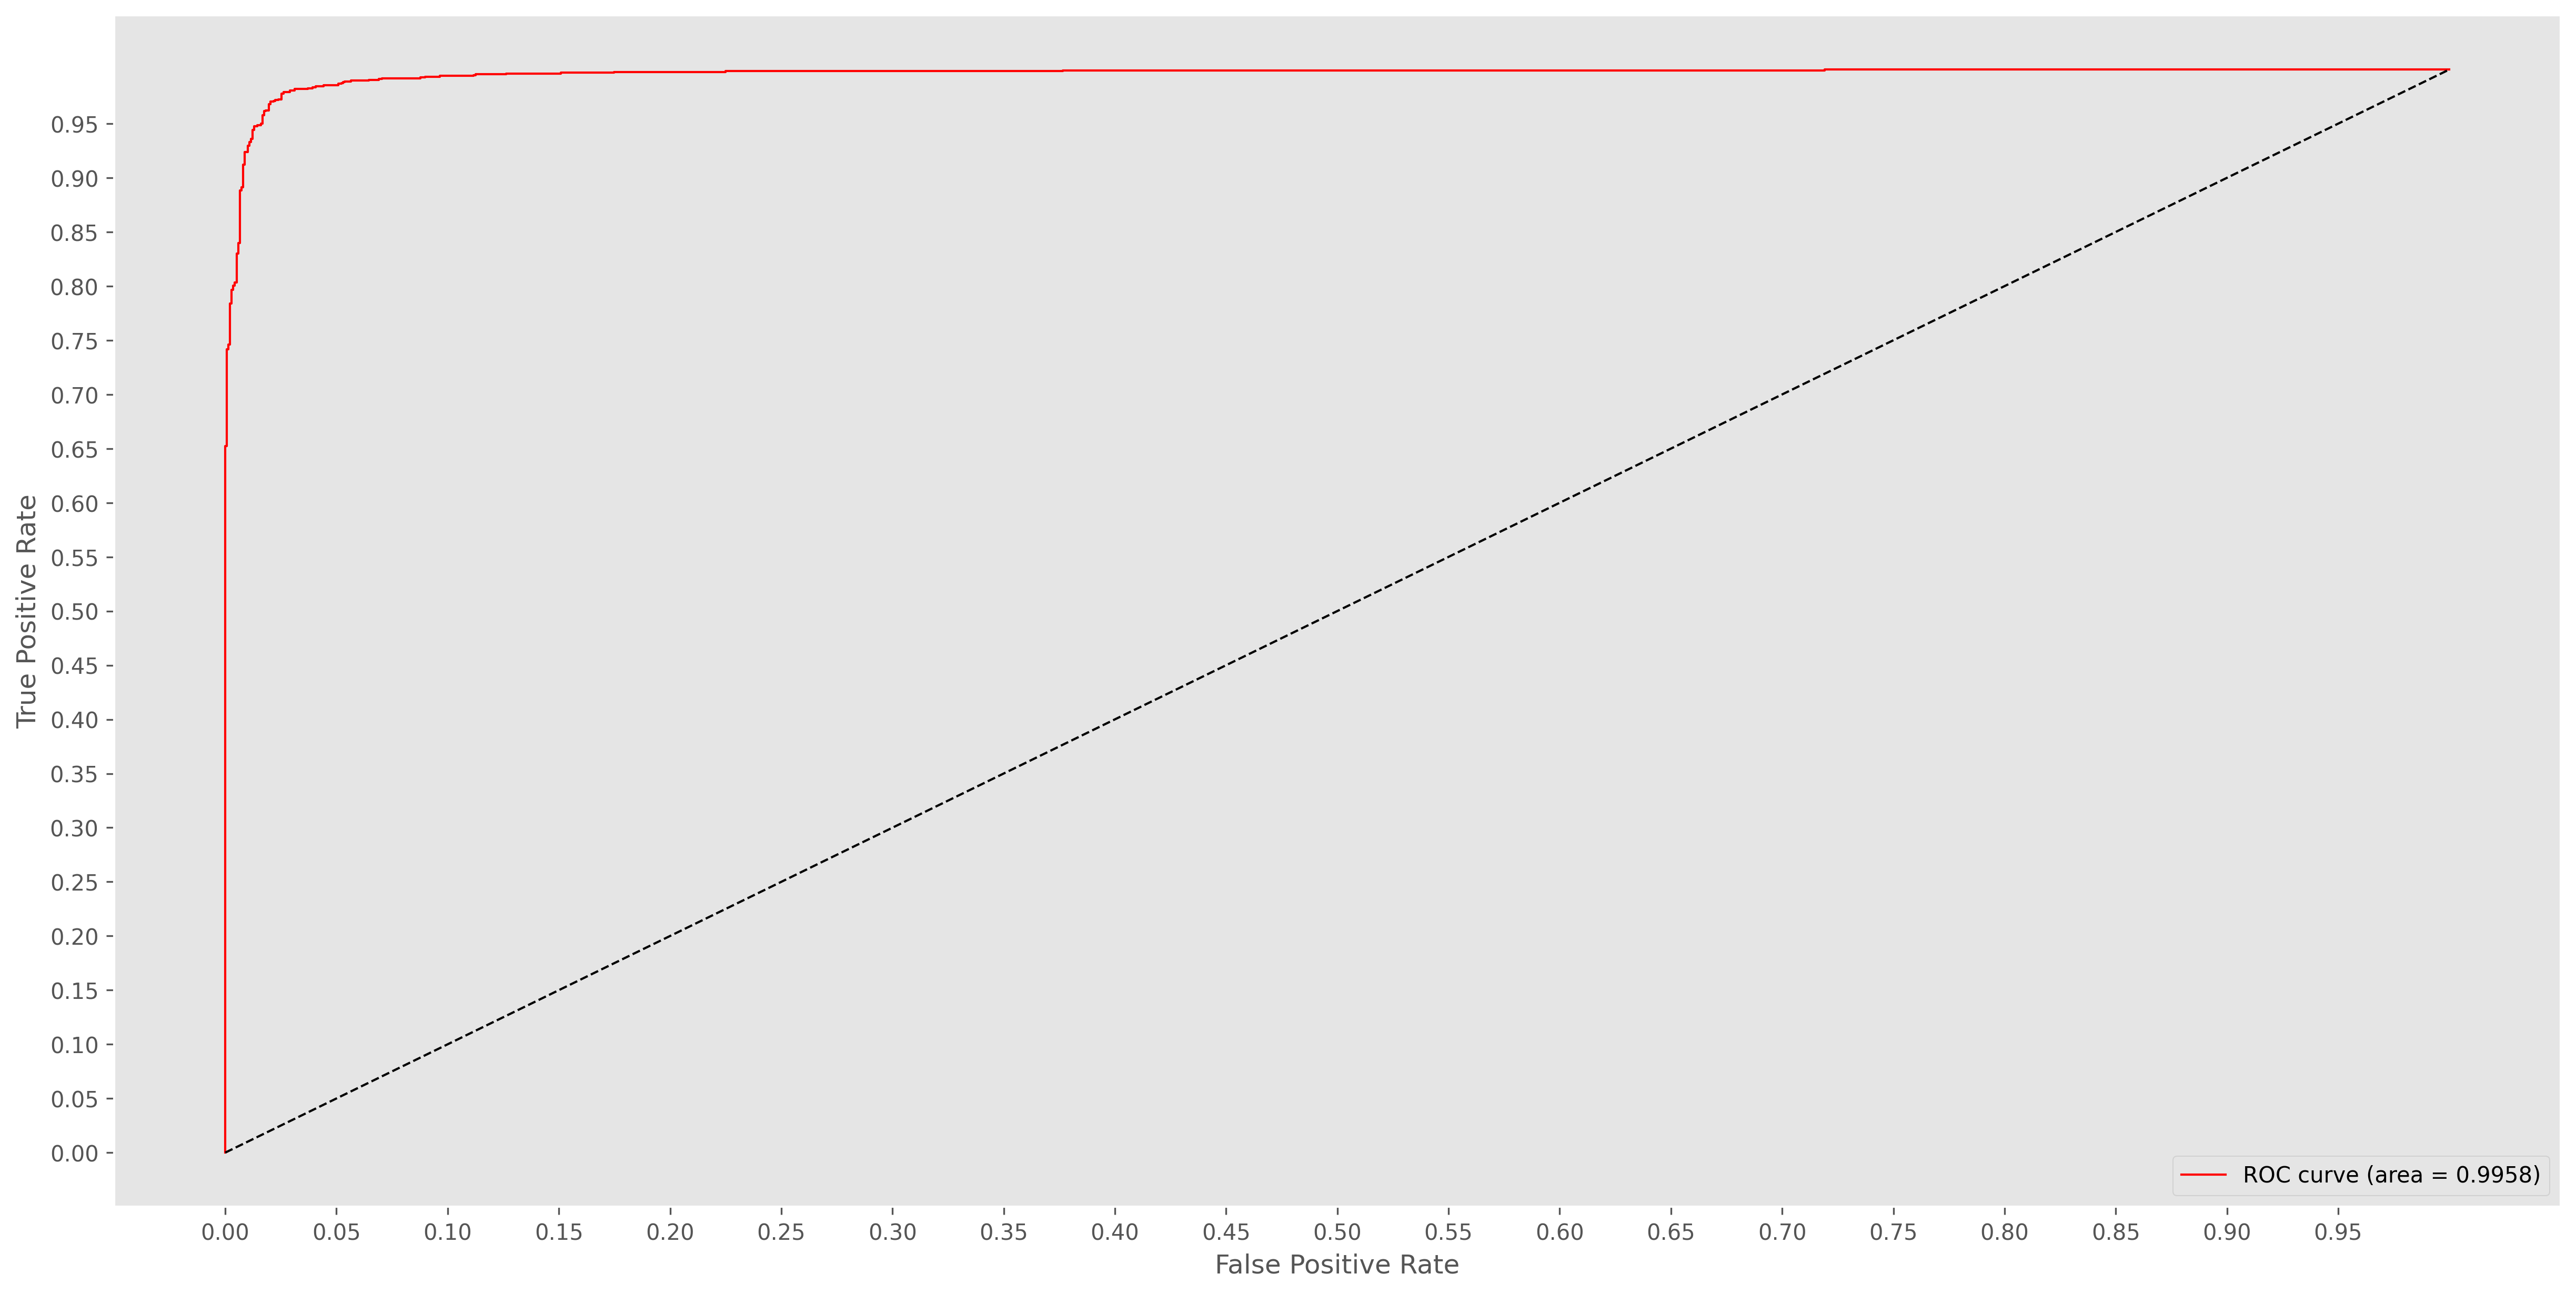

In [280]:
#%% evaluate the performance of these paired ensembles

pair_A_ensemble_model = ensemble(pair_A, model_input)
pair_A_ensemble_model.save('weights/ensemblemodel_pairA.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
A_ensem_y_pred = pair_A_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
A_ensemble_model_accuracy = accuracy_score(Y_test,A_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair A Ensemble model is: ', A_ensemble_model_accuracy)

#evaluate mean squared error
A_ensemble_model_custom_mse = mean_squared_error(Y_test,A_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair A Ensemble model is: ', A_ensemble_model_custom_mse)

#evaluate mean squared log error
A_ensemble_model_custom_msle = mean_squared_log_error(Y_test,A_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair A Ensemble model is: ', A_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)']
print(classification_report(Y_test,A_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,A_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, A_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_40')>]
The Ensemble Model is Saved
The accuracy of the Pair B Ensemble model is:  0.9709724238026125
The Mean Squared Error of the Pair B Ensemble model is:  0.02902757619738752
The Mean Squared Log Error of the Pair B Ensemble model is:  0.013946386470775075
                   precision    recall  f1-score   support

class 0(abnormal)     0.9815    0.9601    0.9707      1378
  class 1(normal)     0.9609    0.9819    0.9713      1378

         accuracy                         0.9710      2756
        macro avg     0.9712    0.9710    0.9710      2756
     weighted avg     0.9712    0.9710    0.9710      2756

Confusion matrix, without normalization
[[1323   55]
 [  25 1353]]


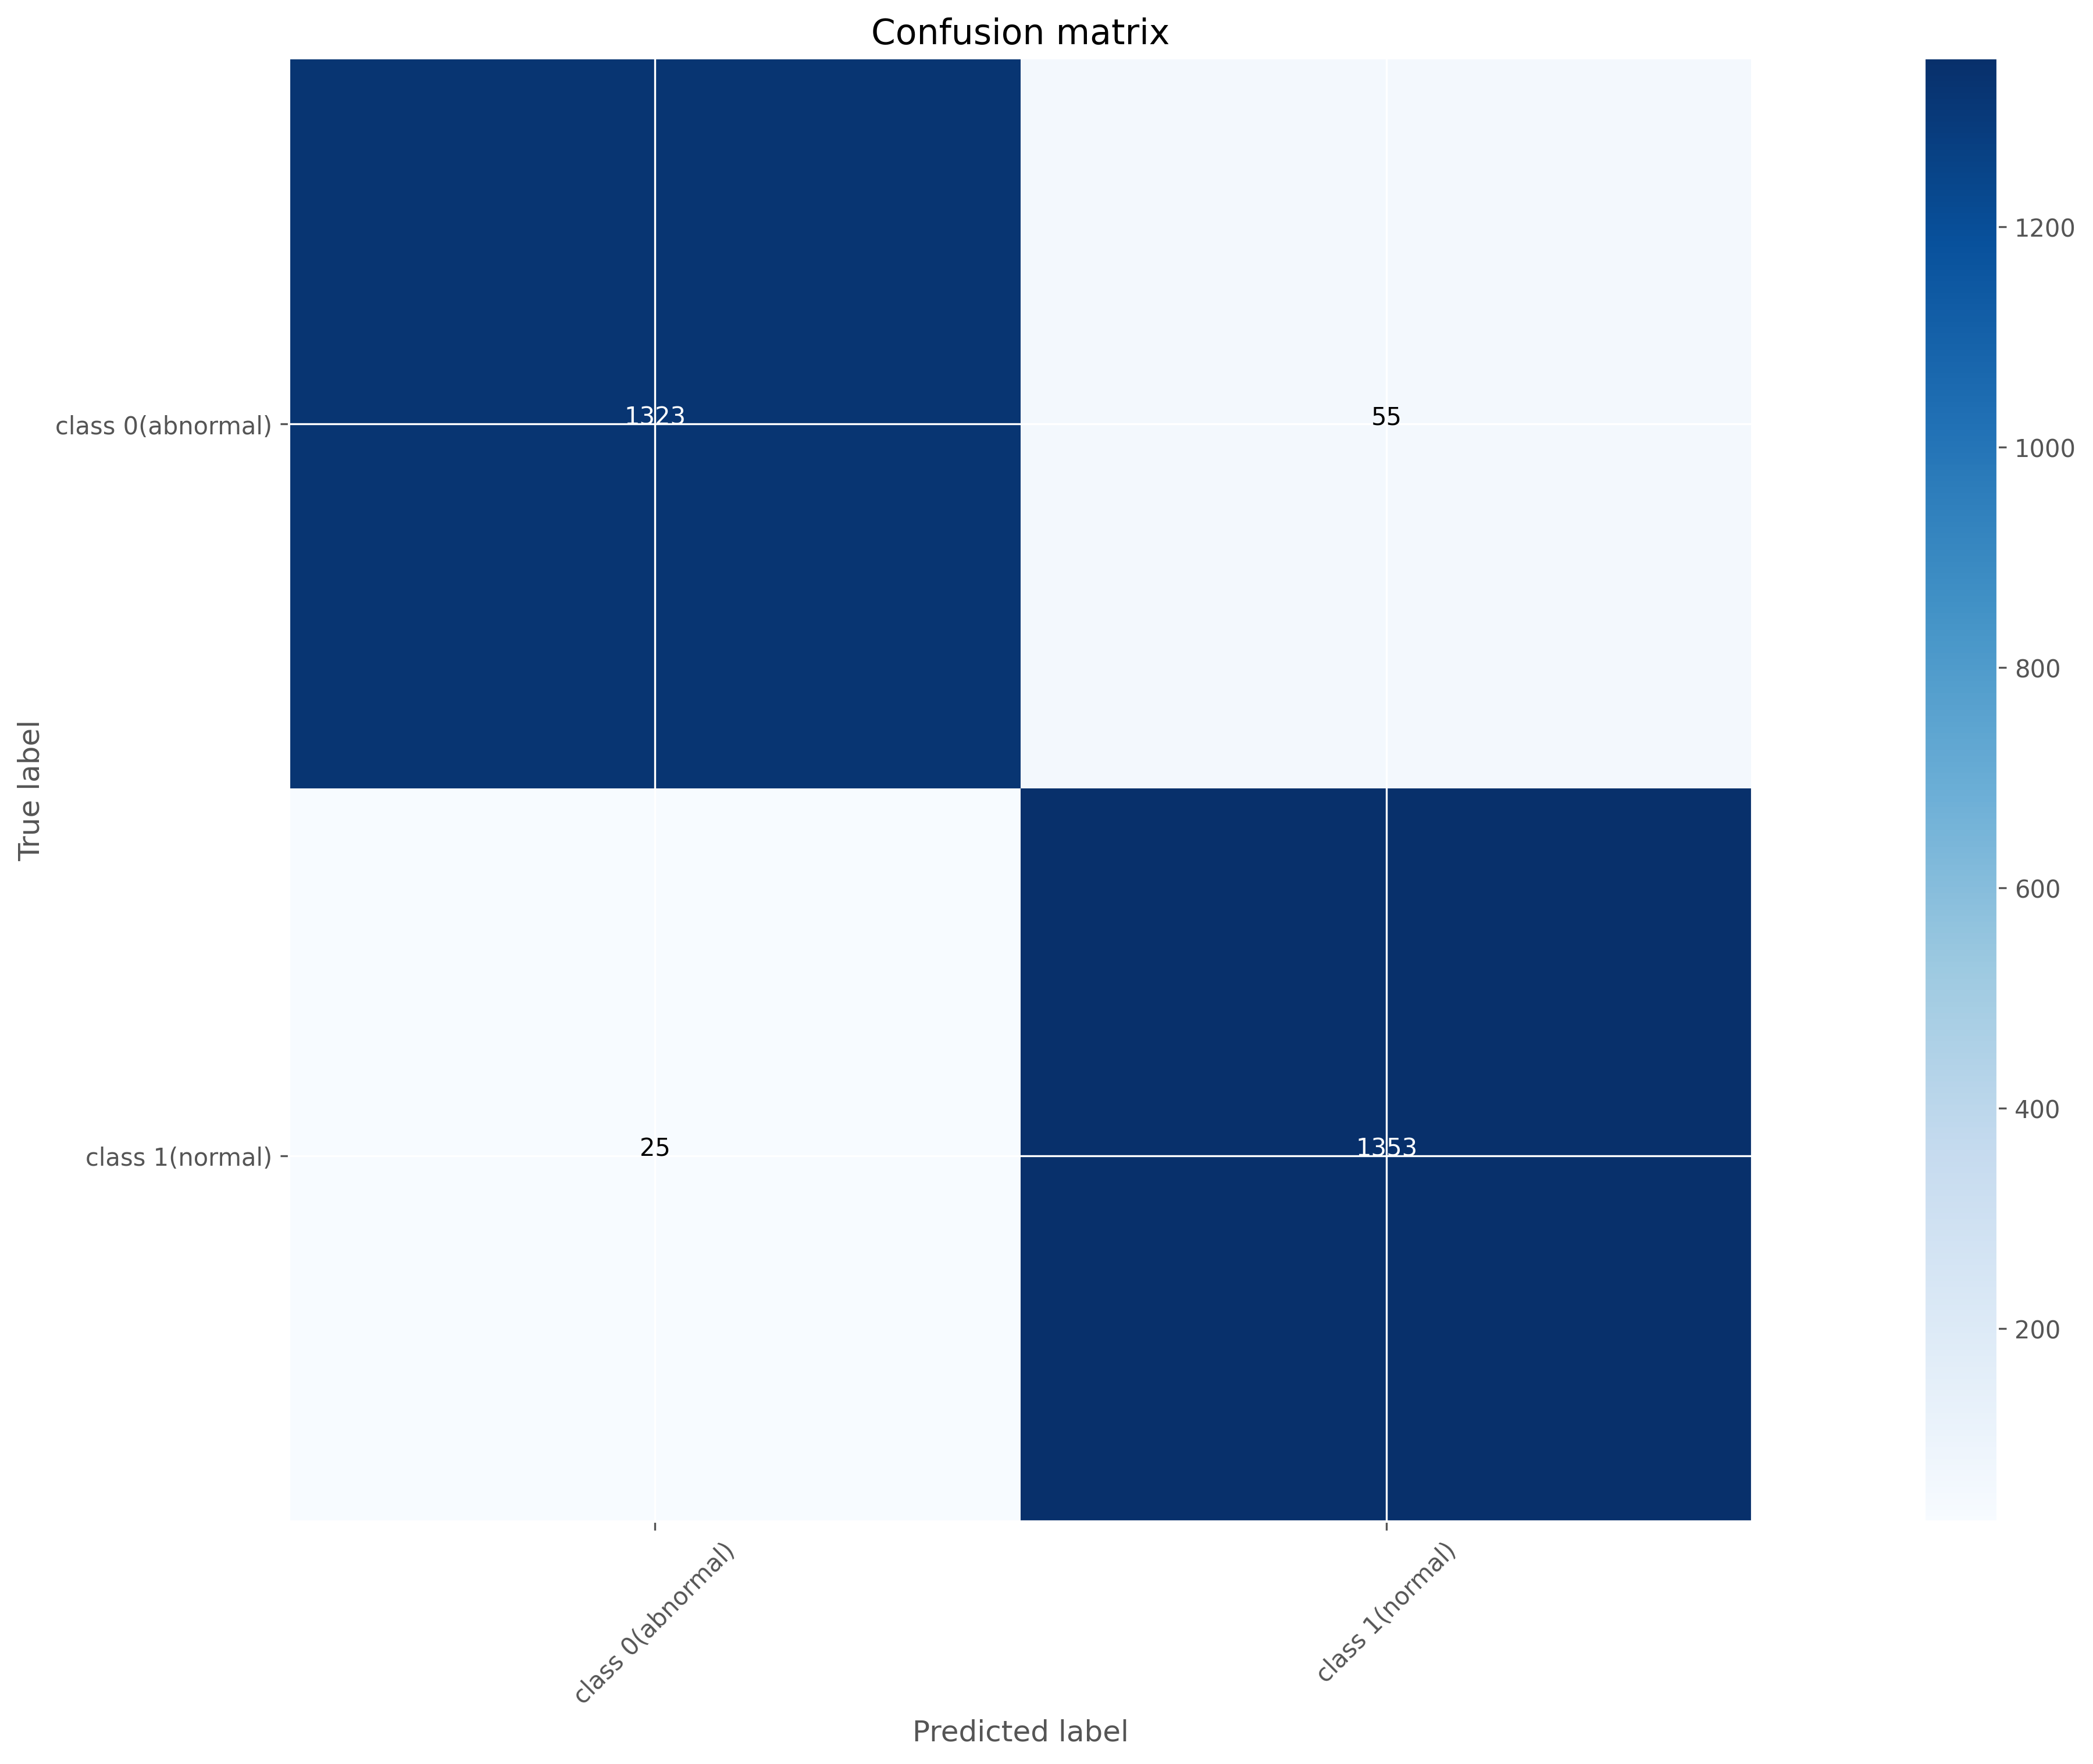

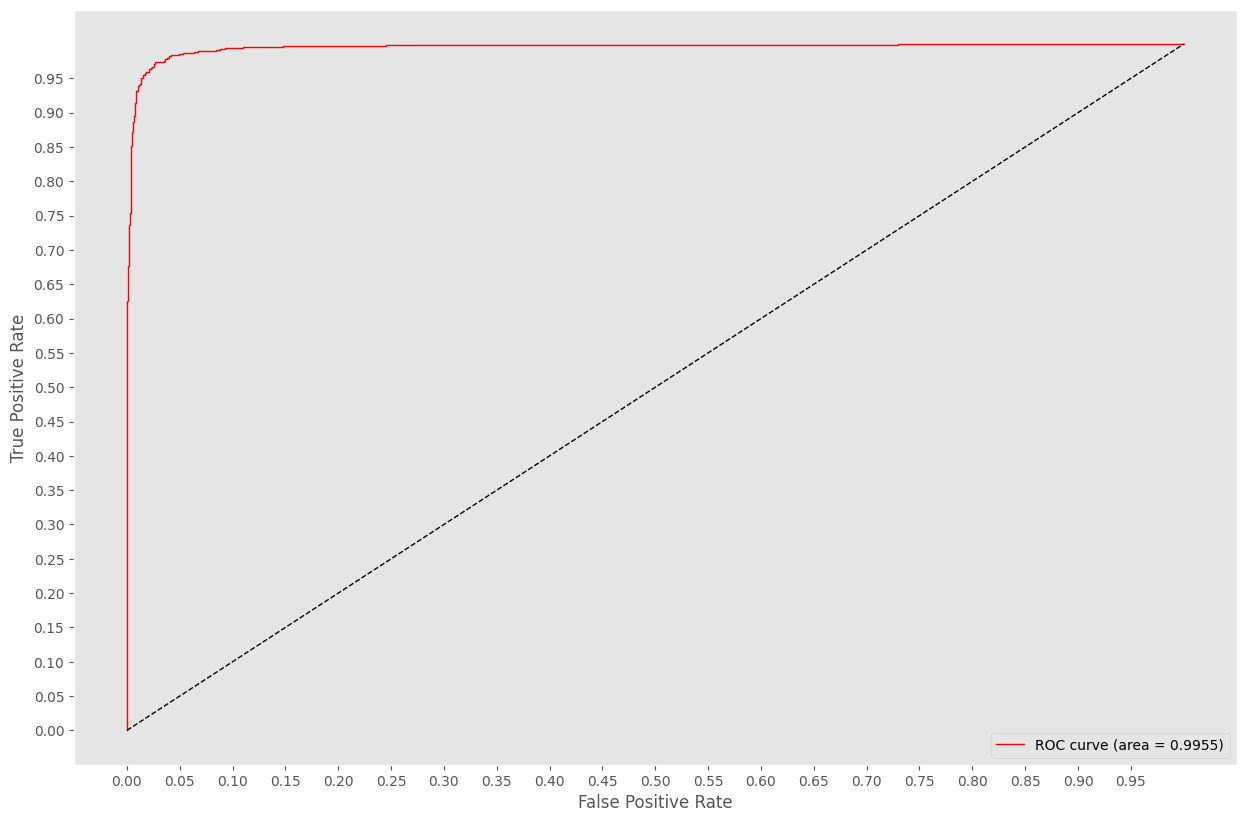

In [281]:
#%% Pair B 

pair_B_ensemble_model = ensemble(pair_B, model_input)
pair_B_ensemble_model.save('weights/ensemblemodel_pairB.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
B_ensem_y_pred = pair_B_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
B_ensemble_model_accuracy = accuracy_score(Y_test,B_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair B Ensemble model is: ', B_ensemble_model_accuracy)

#evaluate mean squared error
B_ensemble_model_custom_mse = mean_squared_error(Y_test,B_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair B Ensemble model is: ', B_ensemble_model_custom_mse)

#evaluate mean squared log error
B_ensemble_model_custom_msle = mean_squared_log_error(Y_test,B_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair B Ensemble model is: ', B_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)']
print(classification_report(Y_test,B_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,B_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, B_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_41')>]
The Ensemble Model is Saved
The accuracy of the Pair C Ensemble model is:  0.9738751814223512
The Mean Squared Error of the Pair C Ensemble model is:  0.026124818577648767
The Mean Squared Log Error of the Pair C Ensemble model is:  0.012551747823697569
                   precision    recall  f1-score   support

class 0(abnormal)     0.9844    0.9630    0.9736      1378
  class 1(normal)     0.9638    0.9848    0.9742      1378

         accuracy                         0.9739      2756
        macro avg     0.9741    0.9739    0.9739      2756
     weighted avg     0.9741    0.9739    0.9739      2756

Confusion matrix, without normalization
[[1327   51]
 [  21 1357]]


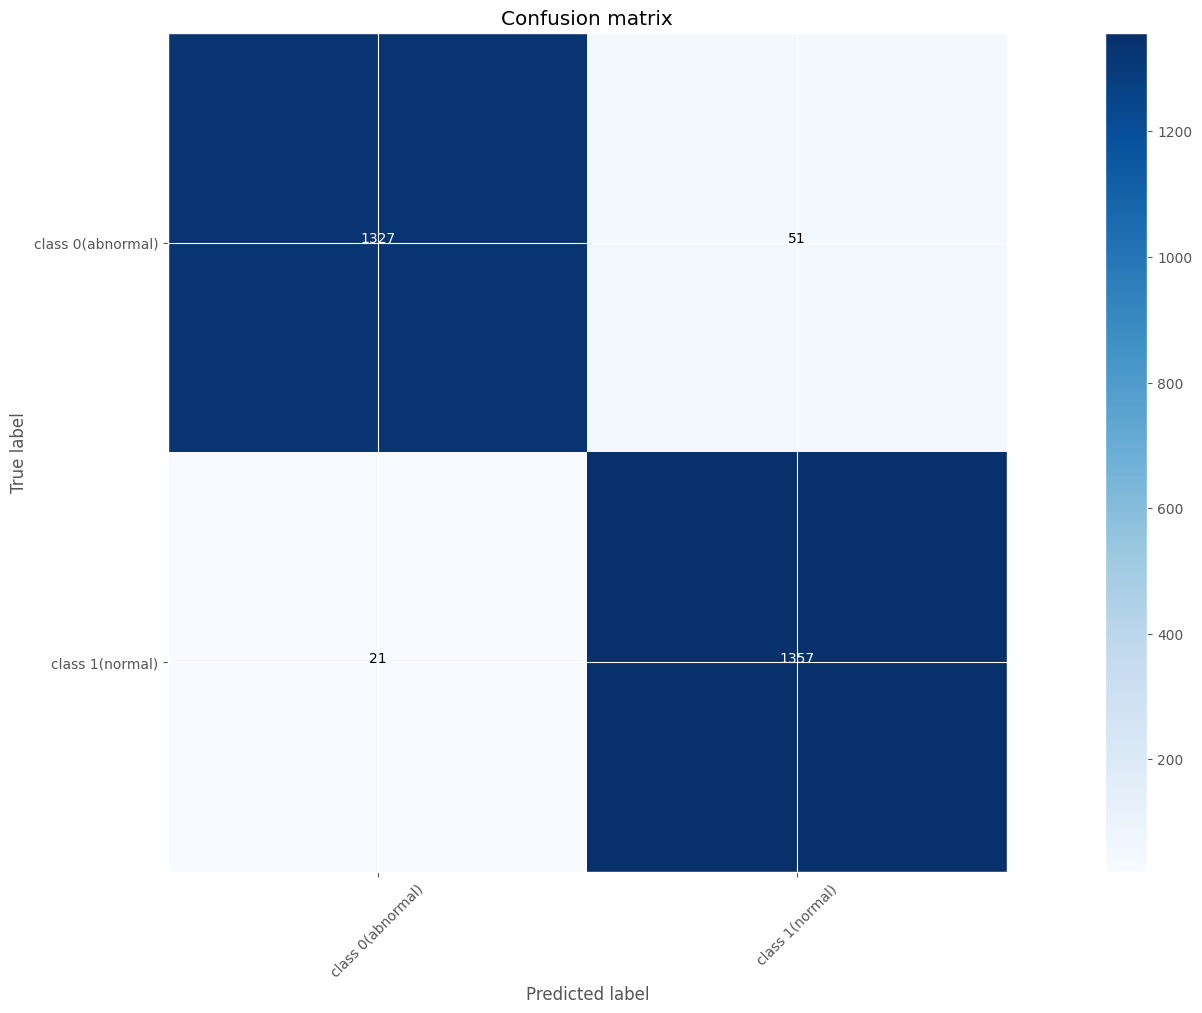

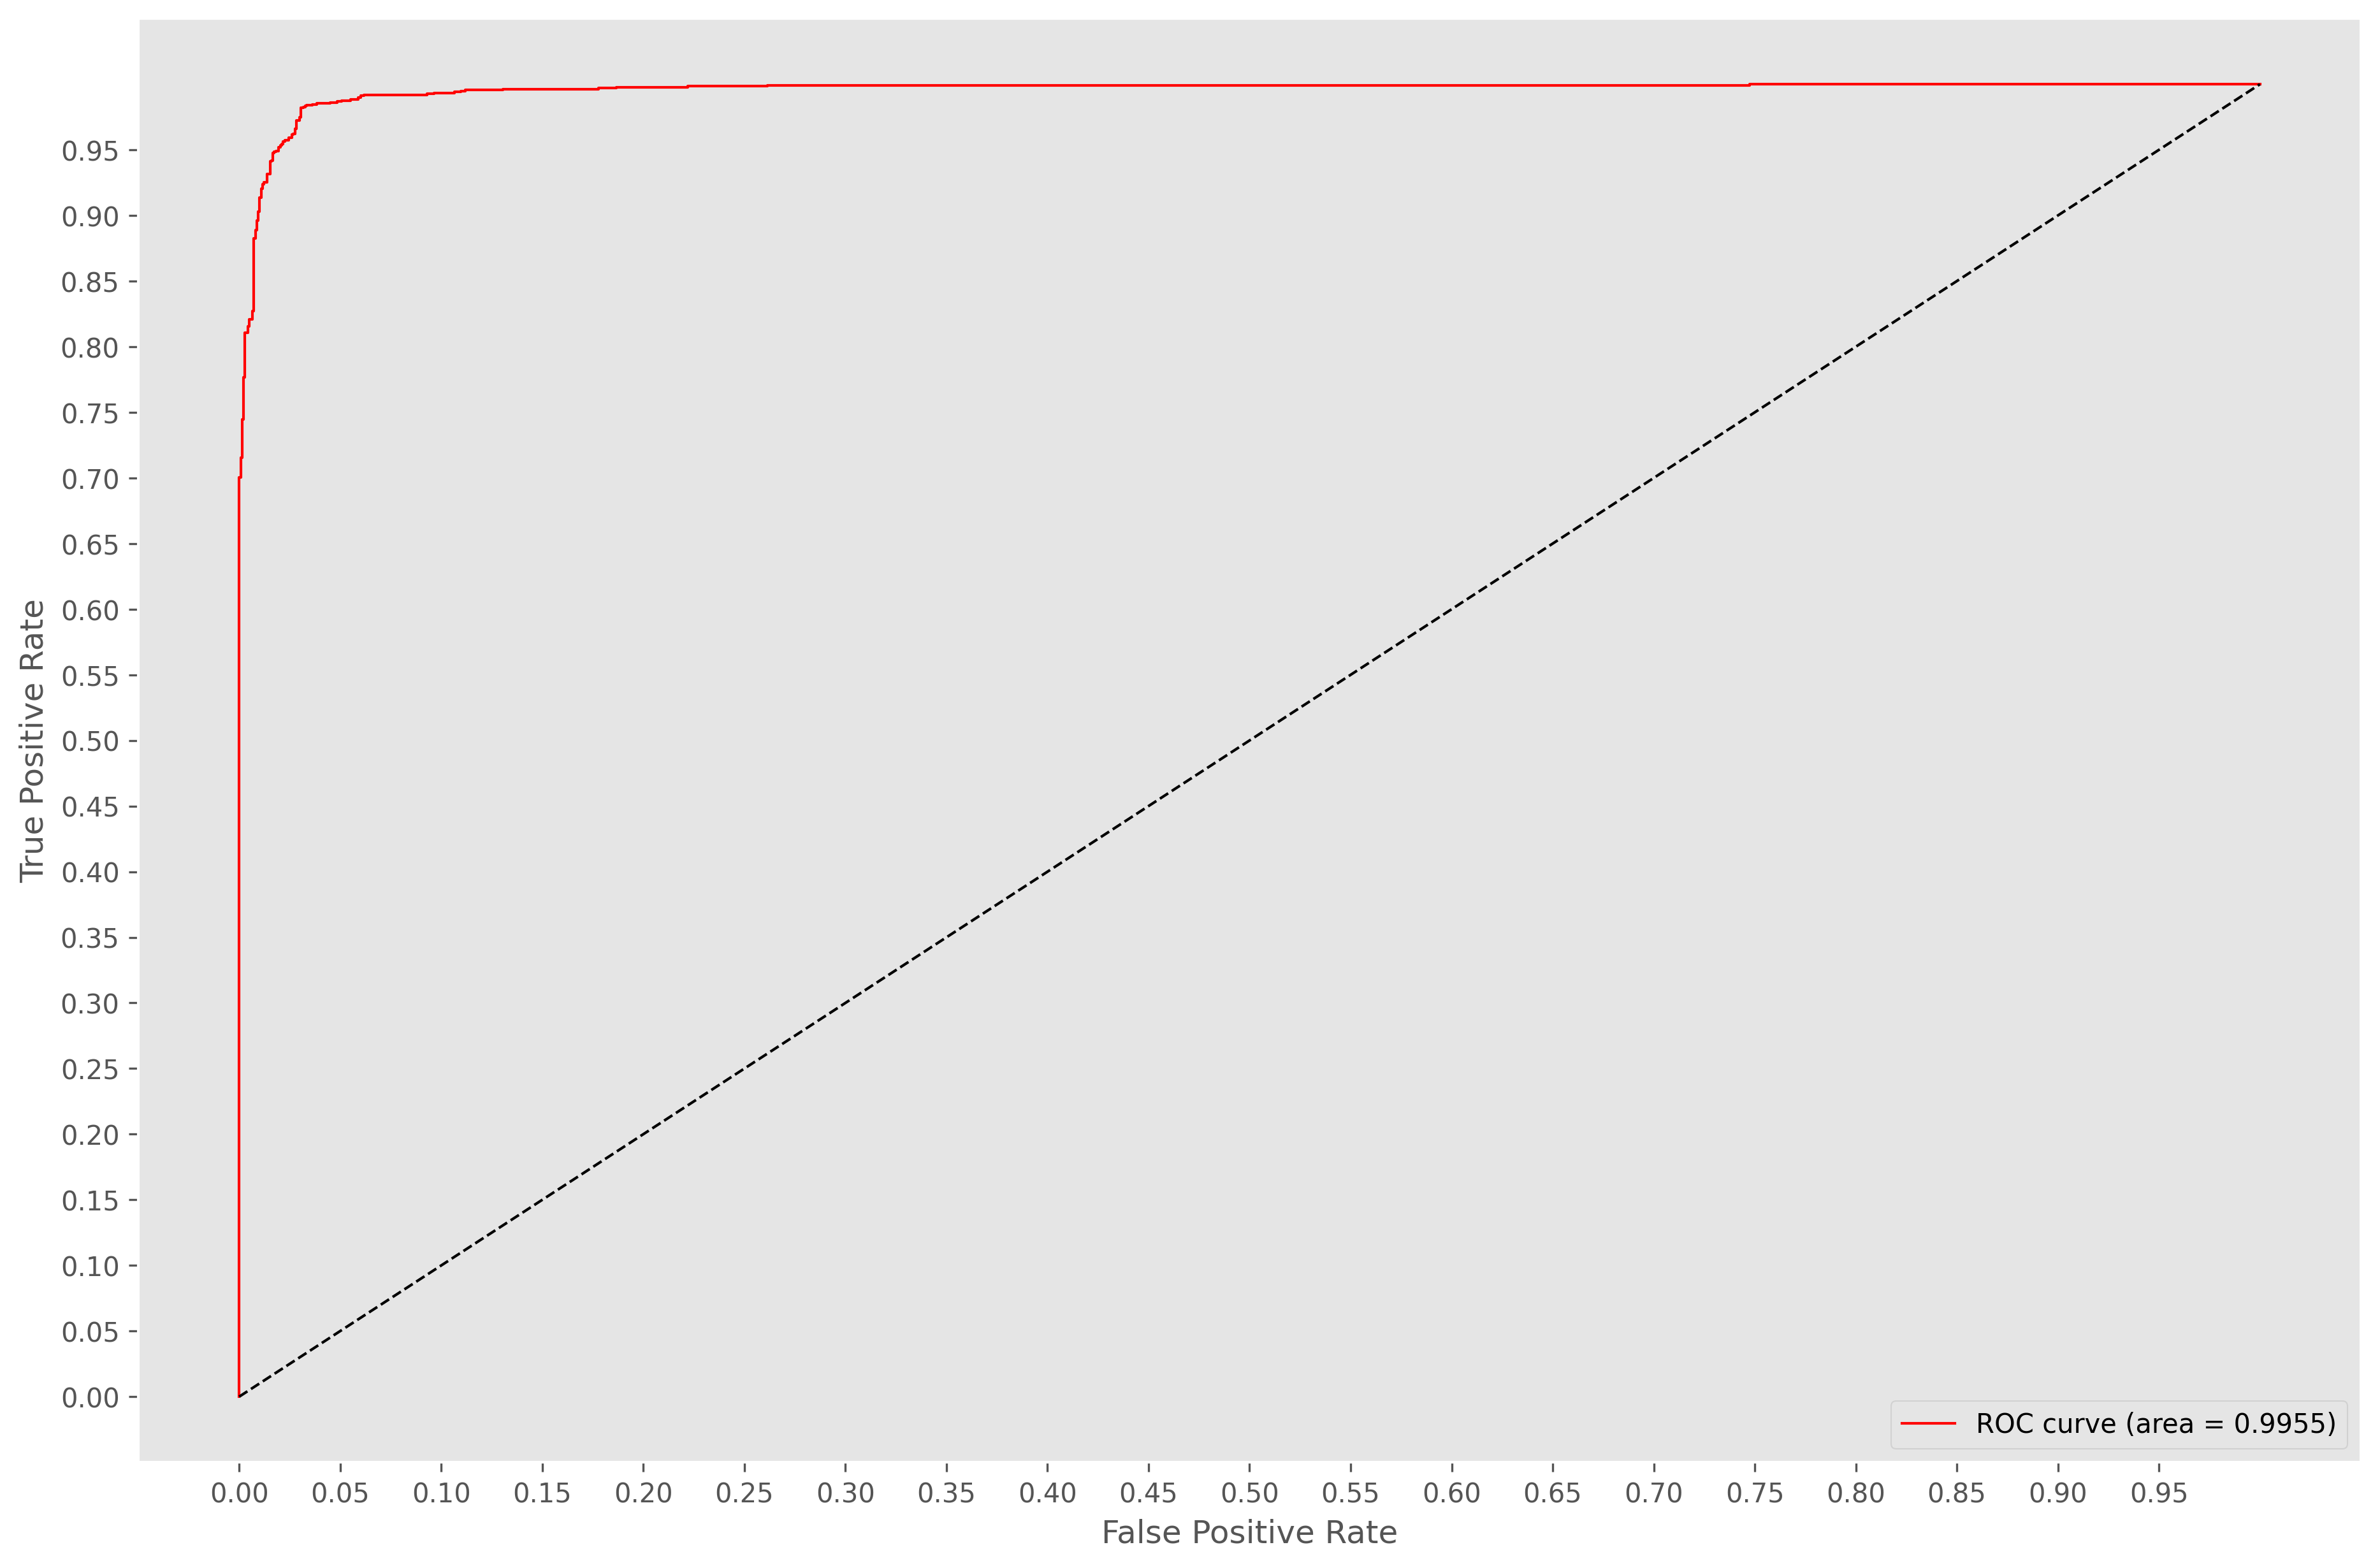

In [282]:
#%% Pair C

pair_C_ensemble_model = ensemble(pair_C, model_input)
pair_C_ensemble_model.save('weights/ensemblemodel_pairC.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
C_ensem_y_pred = pair_C_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
C_ensemble_model_accuracy = accuracy_score(Y_test,C_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair C Ensemble model is: ', C_ensemble_model_accuracy)

#evaluate mean squared error
C_ensemble_model_custom_mse = mean_squared_error(Y_test,C_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair C Ensemble model is: ', C_ensemble_model_custom_mse)

#evaluate mean squared log error
C_ensemble_model_custom_msle = mean_squared_log_error(Y_test,C_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair C Ensemble model is: ', C_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,C_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,C_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=100)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, C_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_39')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_40')>]
The Ensemble Model is Saved
The accuracy of the Pair D_ Ensemble model is:  0.9764150943396226
The Mean Squared Error of the Pair D_ Ensemble model is:  0.02358490566037736
The Mean Squared Log Error of the Pair D_ Ensemble model is:  0.011331439007504749
                   precision    recall  f1-score   support

class 0(abnormal)     0.9810    0.9717    0.9763      1378
  class 1(normal)     0.9720    0.9811    0.9765      1378

         accuracy                         0.9764      2756
        macro avg     0.9765    0.9764    0.9764      2756
     weighted avg     0.9765    0.9764    0.9764      2756

Confusion matrix, without normalization
[[1339   39]
 [  26 1352]]


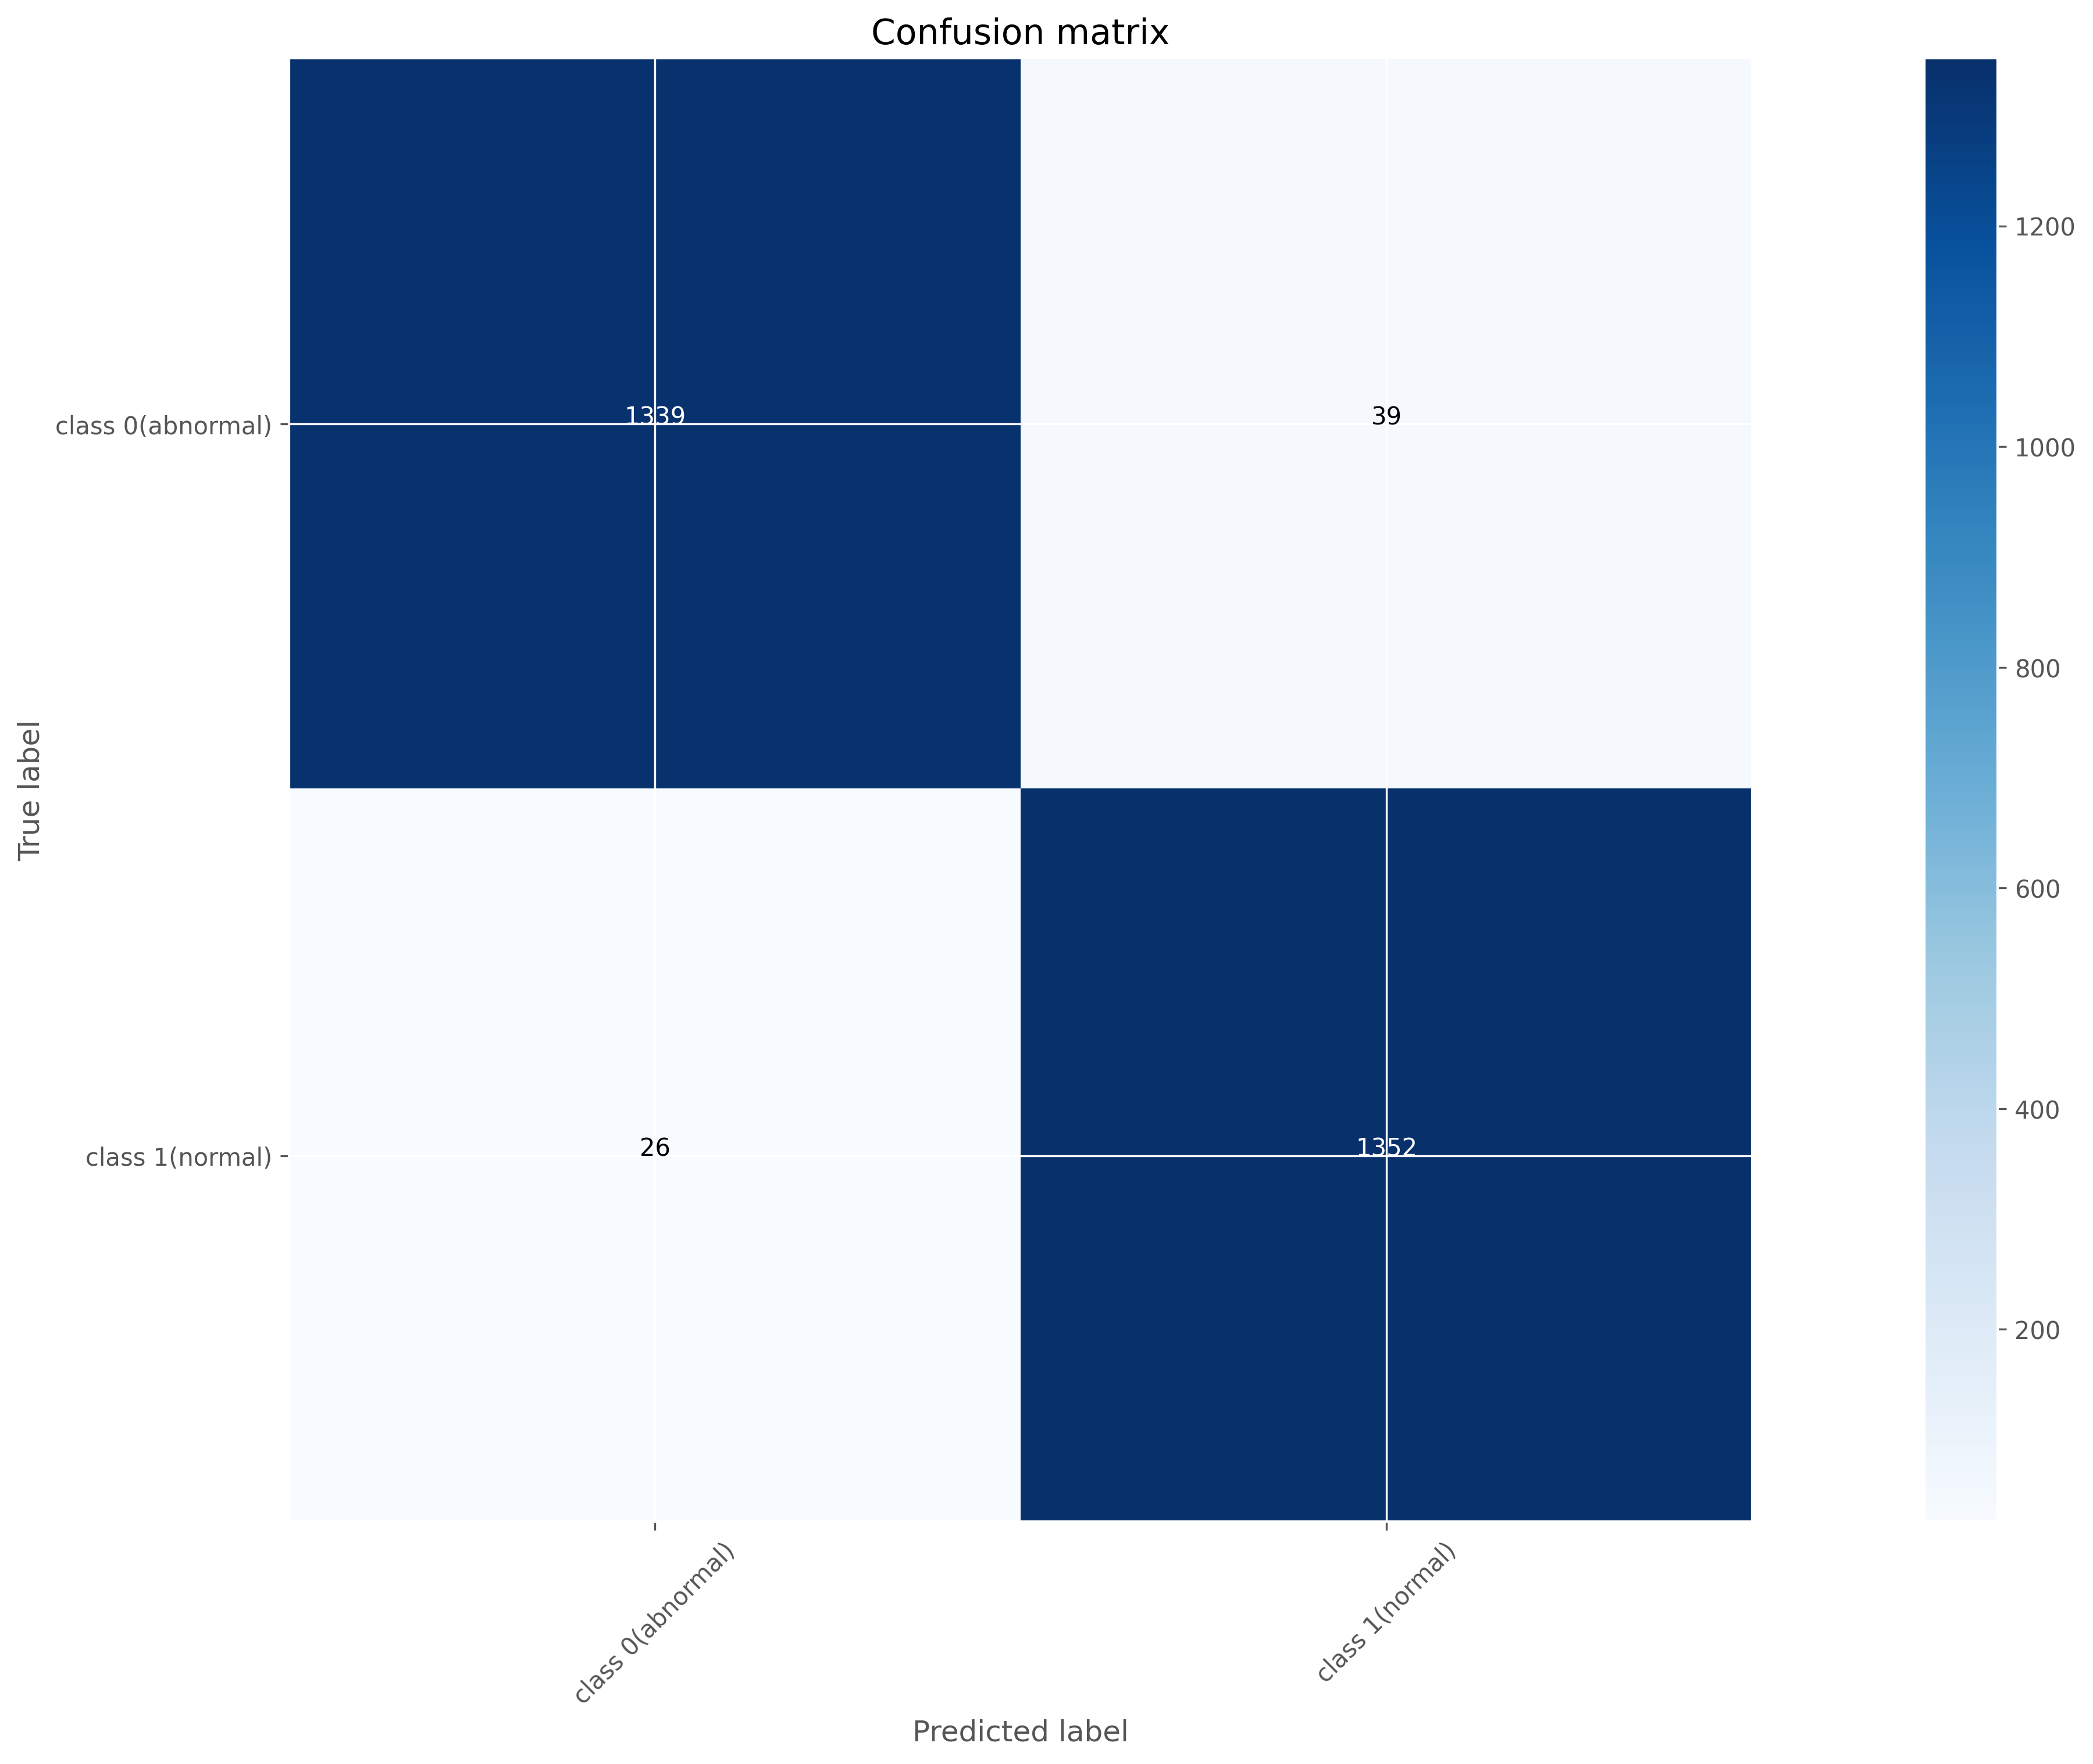

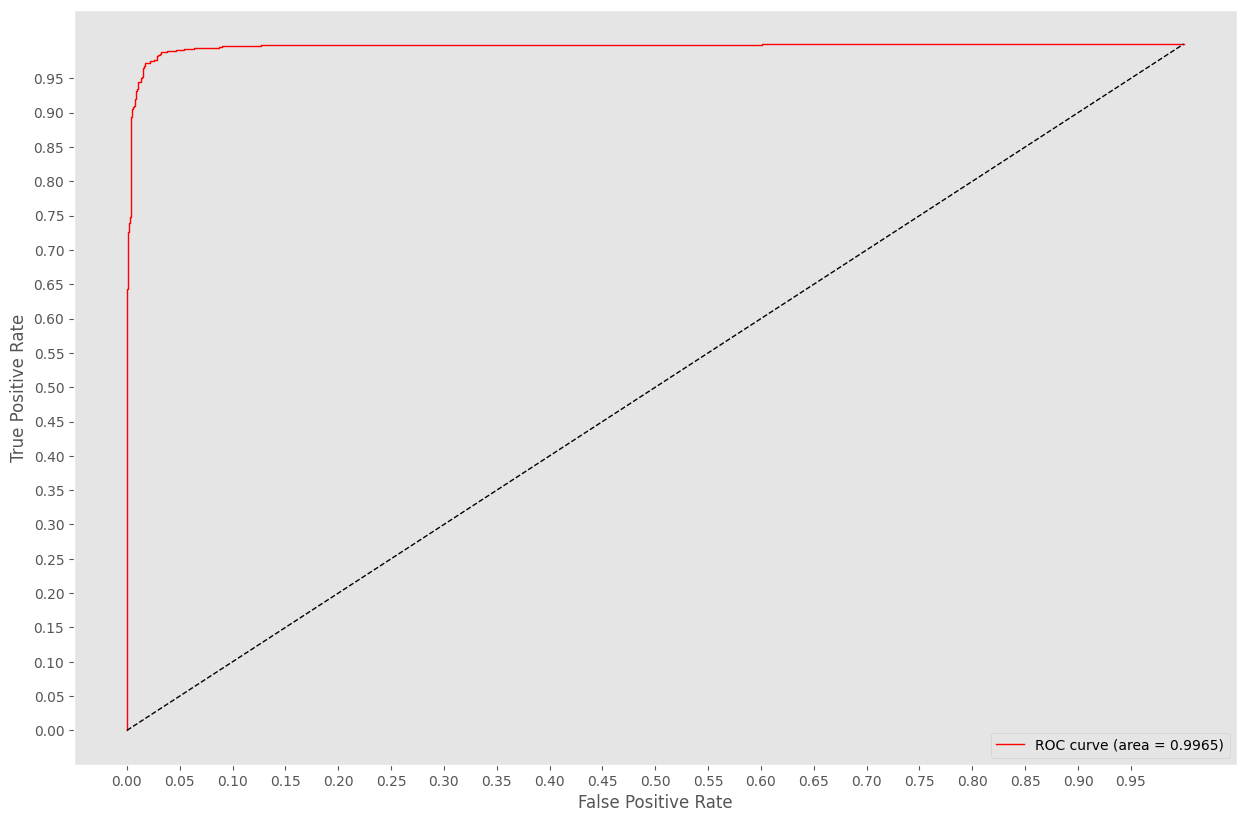

In [283]:
#%% Pair D

pair_D_ensemble_model = ensemble(pair_D, model_input)
pair_D_ensemble_model.save('weights/ensemblemodel_pairD.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
D_ensem_y_pred = pair_D_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
D_ensemble_model_accuracy = accuracy_score(Y_test,D_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair D_ Ensemble model is: ', D_ensemble_model_accuracy)

#evaluate mean squared error
D_ensemble_model_custom_mse = mean_squared_error(Y_test,D_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair D_ Ensemble model is: ', D_ensemble_model_custom_mse)

#evaluate mean squared log error
D_ensemble_model_custom_msle = mean_squared_log_error(Y_test,D_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair D_ Ensemble model is: ', D_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,D_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,D_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, D_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_39')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_41')>]
The Ensemble Model is Saved
The accuracy of the Pair E_ Ensemble model is:  0.9753265602322206
The Mean Squared Error of the Pair E Ensemble model is:  0.02467343976777939
The Mean Squared Log Error of the Pair E Ensemble model is:  0.011854428500158814
                   precision    recall  f1-score   support

class 0(abnormal)     0.9845    0.9659    0.9751      1378
  class 1(normal)     0.9665    0.9848    0.9756      1378

         accuracy                         0.9753      2756
        macro avg     0.9755    0.9753    0.9753      2756
     weighted avg     0.9755    0.9753    0.9753      2756

Confusion matrix, without normalization
[[1331   47]
 [  21 1357]]


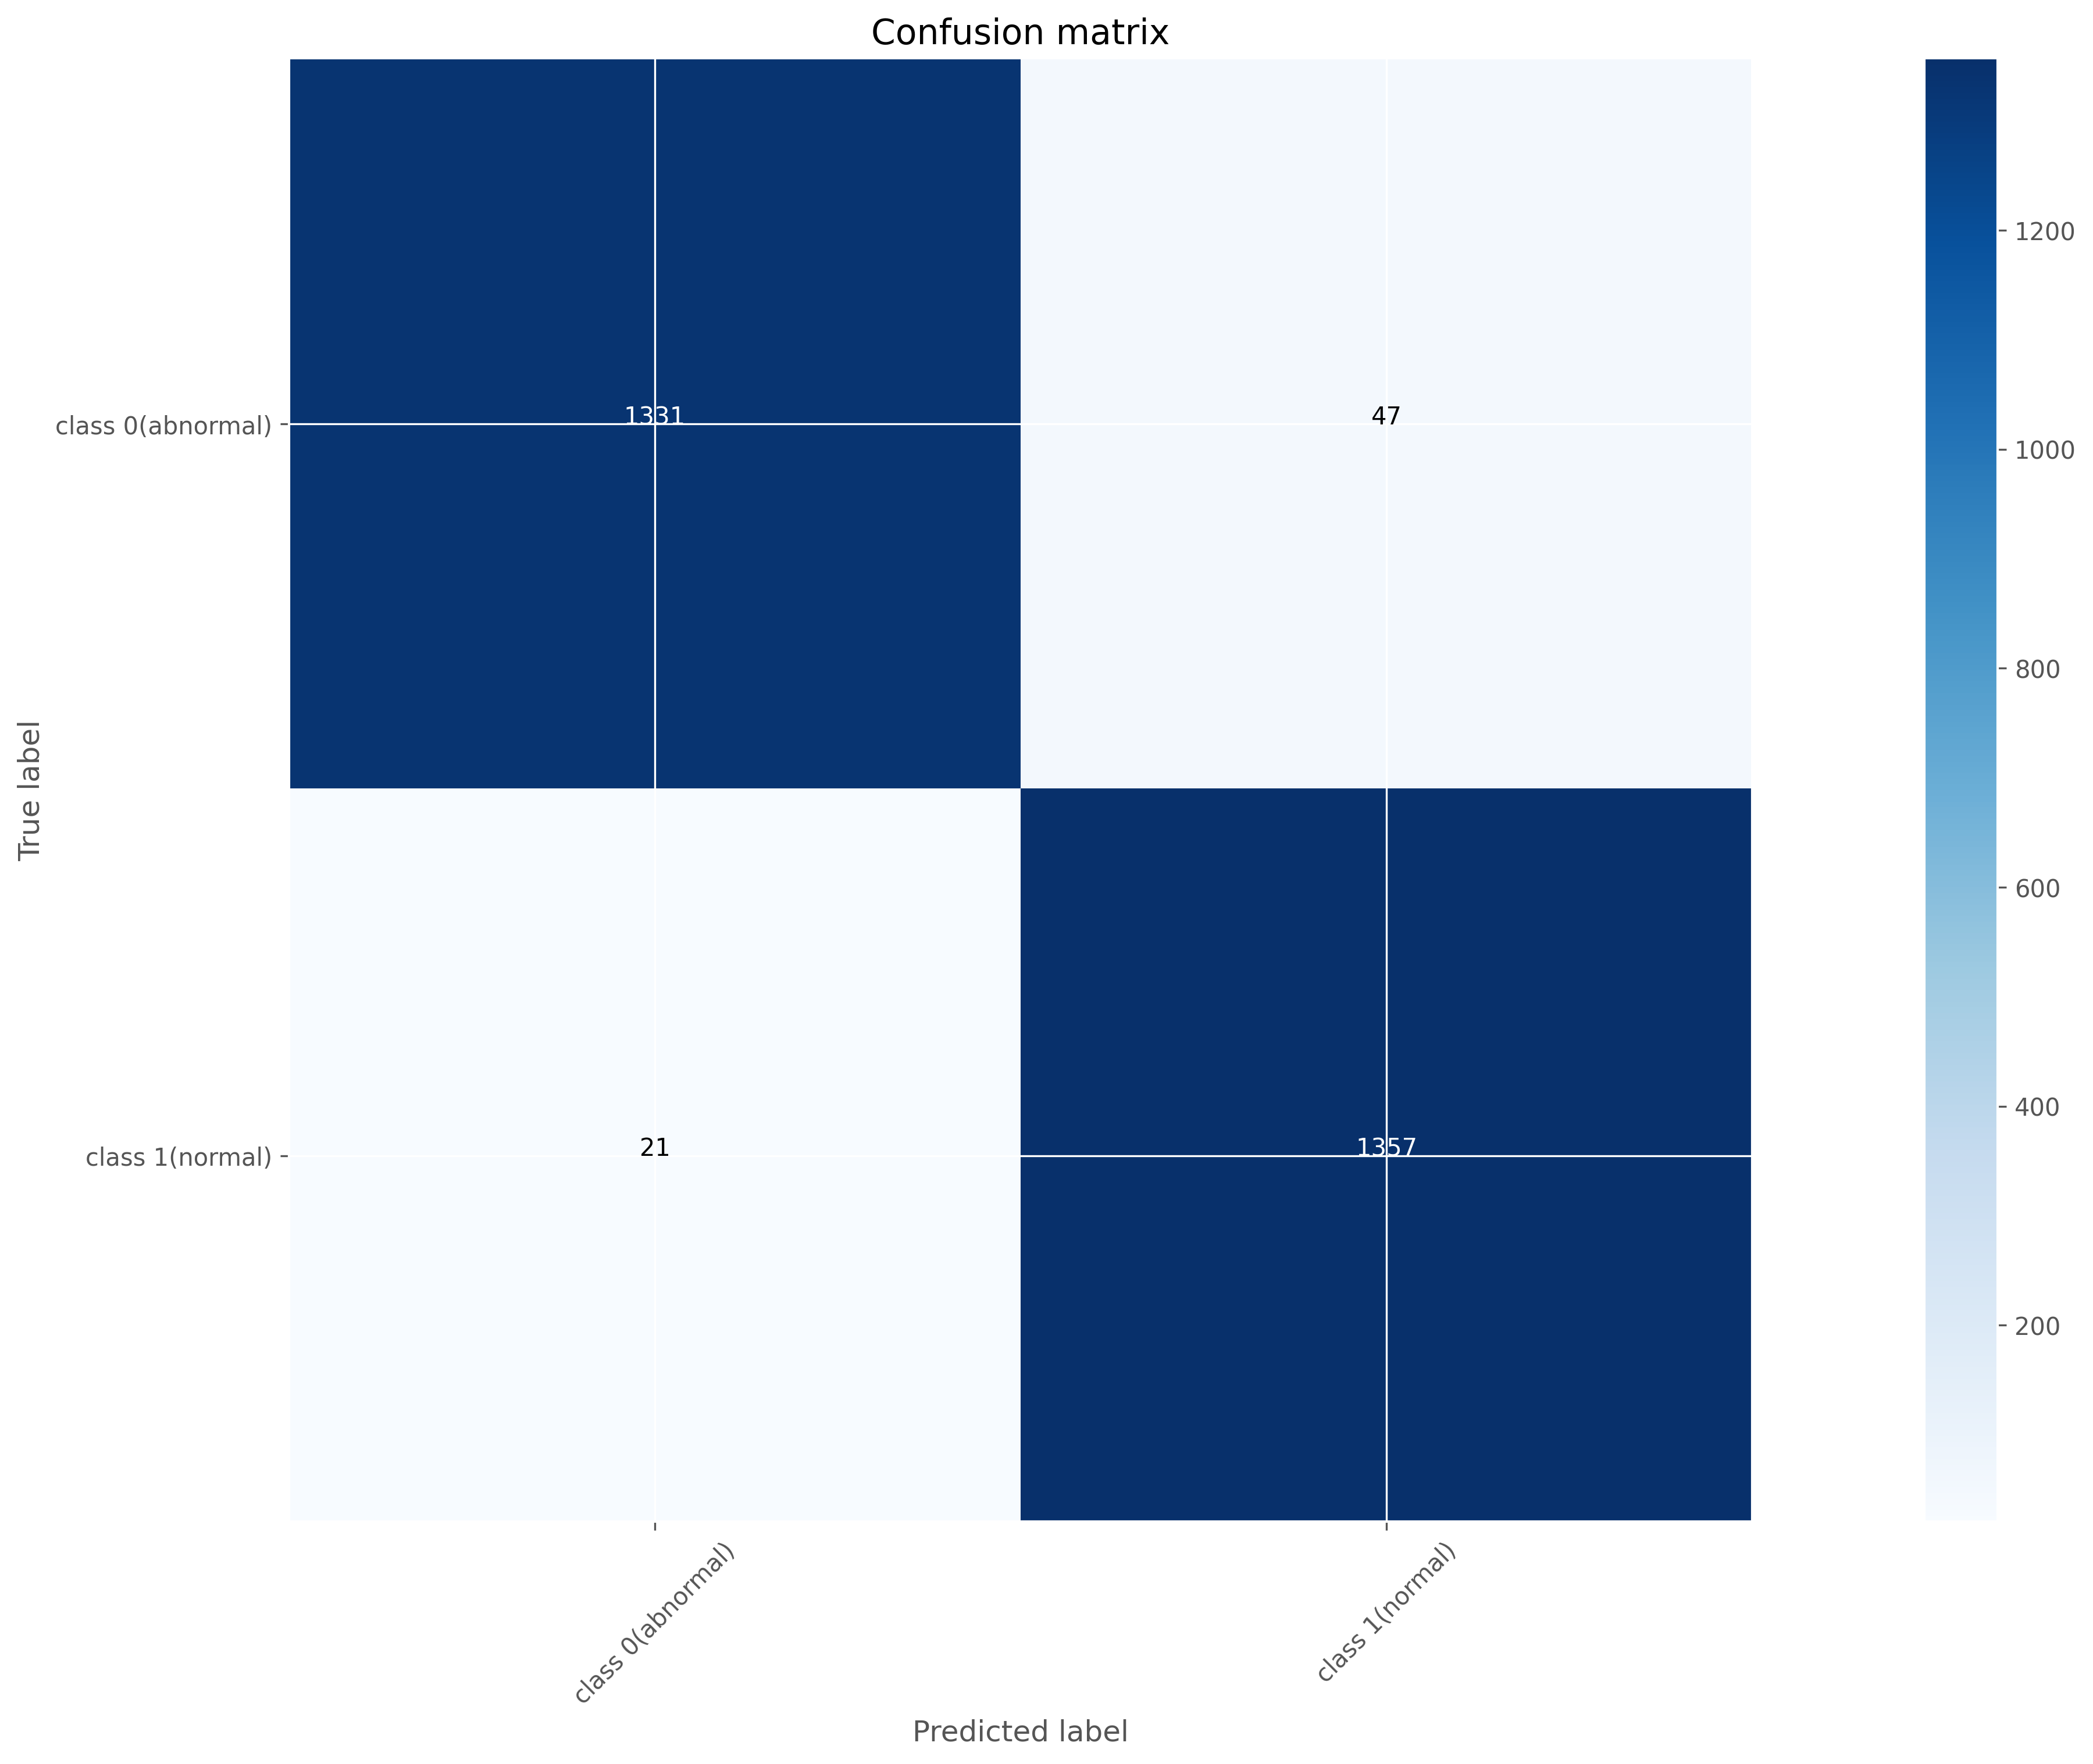

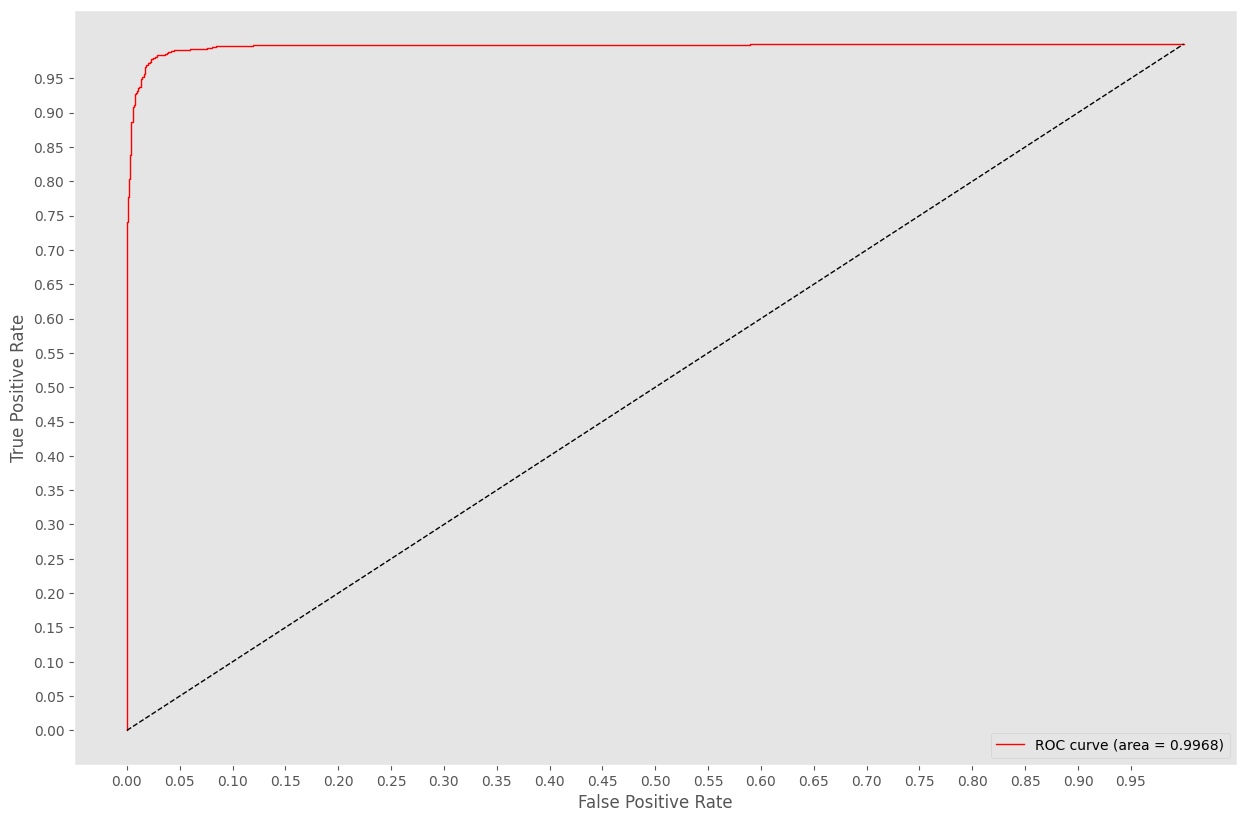

In [284]:
 #%% Pair E

pair_E_ensemble_model = ensemble(pair_E, model_input)
pair_E_ensemble_model.save('weights/ensemblemodel_pairE.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
E_ensem_y_pred = pair_E_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
E_ensemble_model_accuracy = accuracy_score(Y_test,E_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair E_ Ensemble model is: ', E_ensemble_model_accuracy)

#evaluate mean squared error
E_ensemble_model_custom_mse = mean_squared_error(Y_test,E_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair E Ensemble model is: ', E_ensemble_model_custom_mse)

#evaluate mean squared log error
E_ensemble_model_custom_msle = mean_squared_log_error(Y_test,E_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair E Ensemble model is: ', E_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,E_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, E_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_40')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_41')>]
The Ensemble Model is Saved
The accuracy of the Pair F_ Ensemble model is:  0.9731494920174165
The Mean Squared Error of the Pair F_ Ensemble model is:  0.026850507982583455
The Mean Squared Log Error of the Pair F_Ensemble model is:  0.012900407485466945
                   precision    recall  f1-score   support

class 0(abnormal)     0.9808    0.9652    0.9729      1378
  class 1(normal)     0.9657    0.9811    0.9734      1378

         accuracy                         0.9731      2756
        macro avg     0.9733    0.9731    0.9731      2756
     weighted avg     0.9733    0.9731    0.9731      2756

Confusion matrix, without normalization
[[1330   48]
 [  26 1352]]


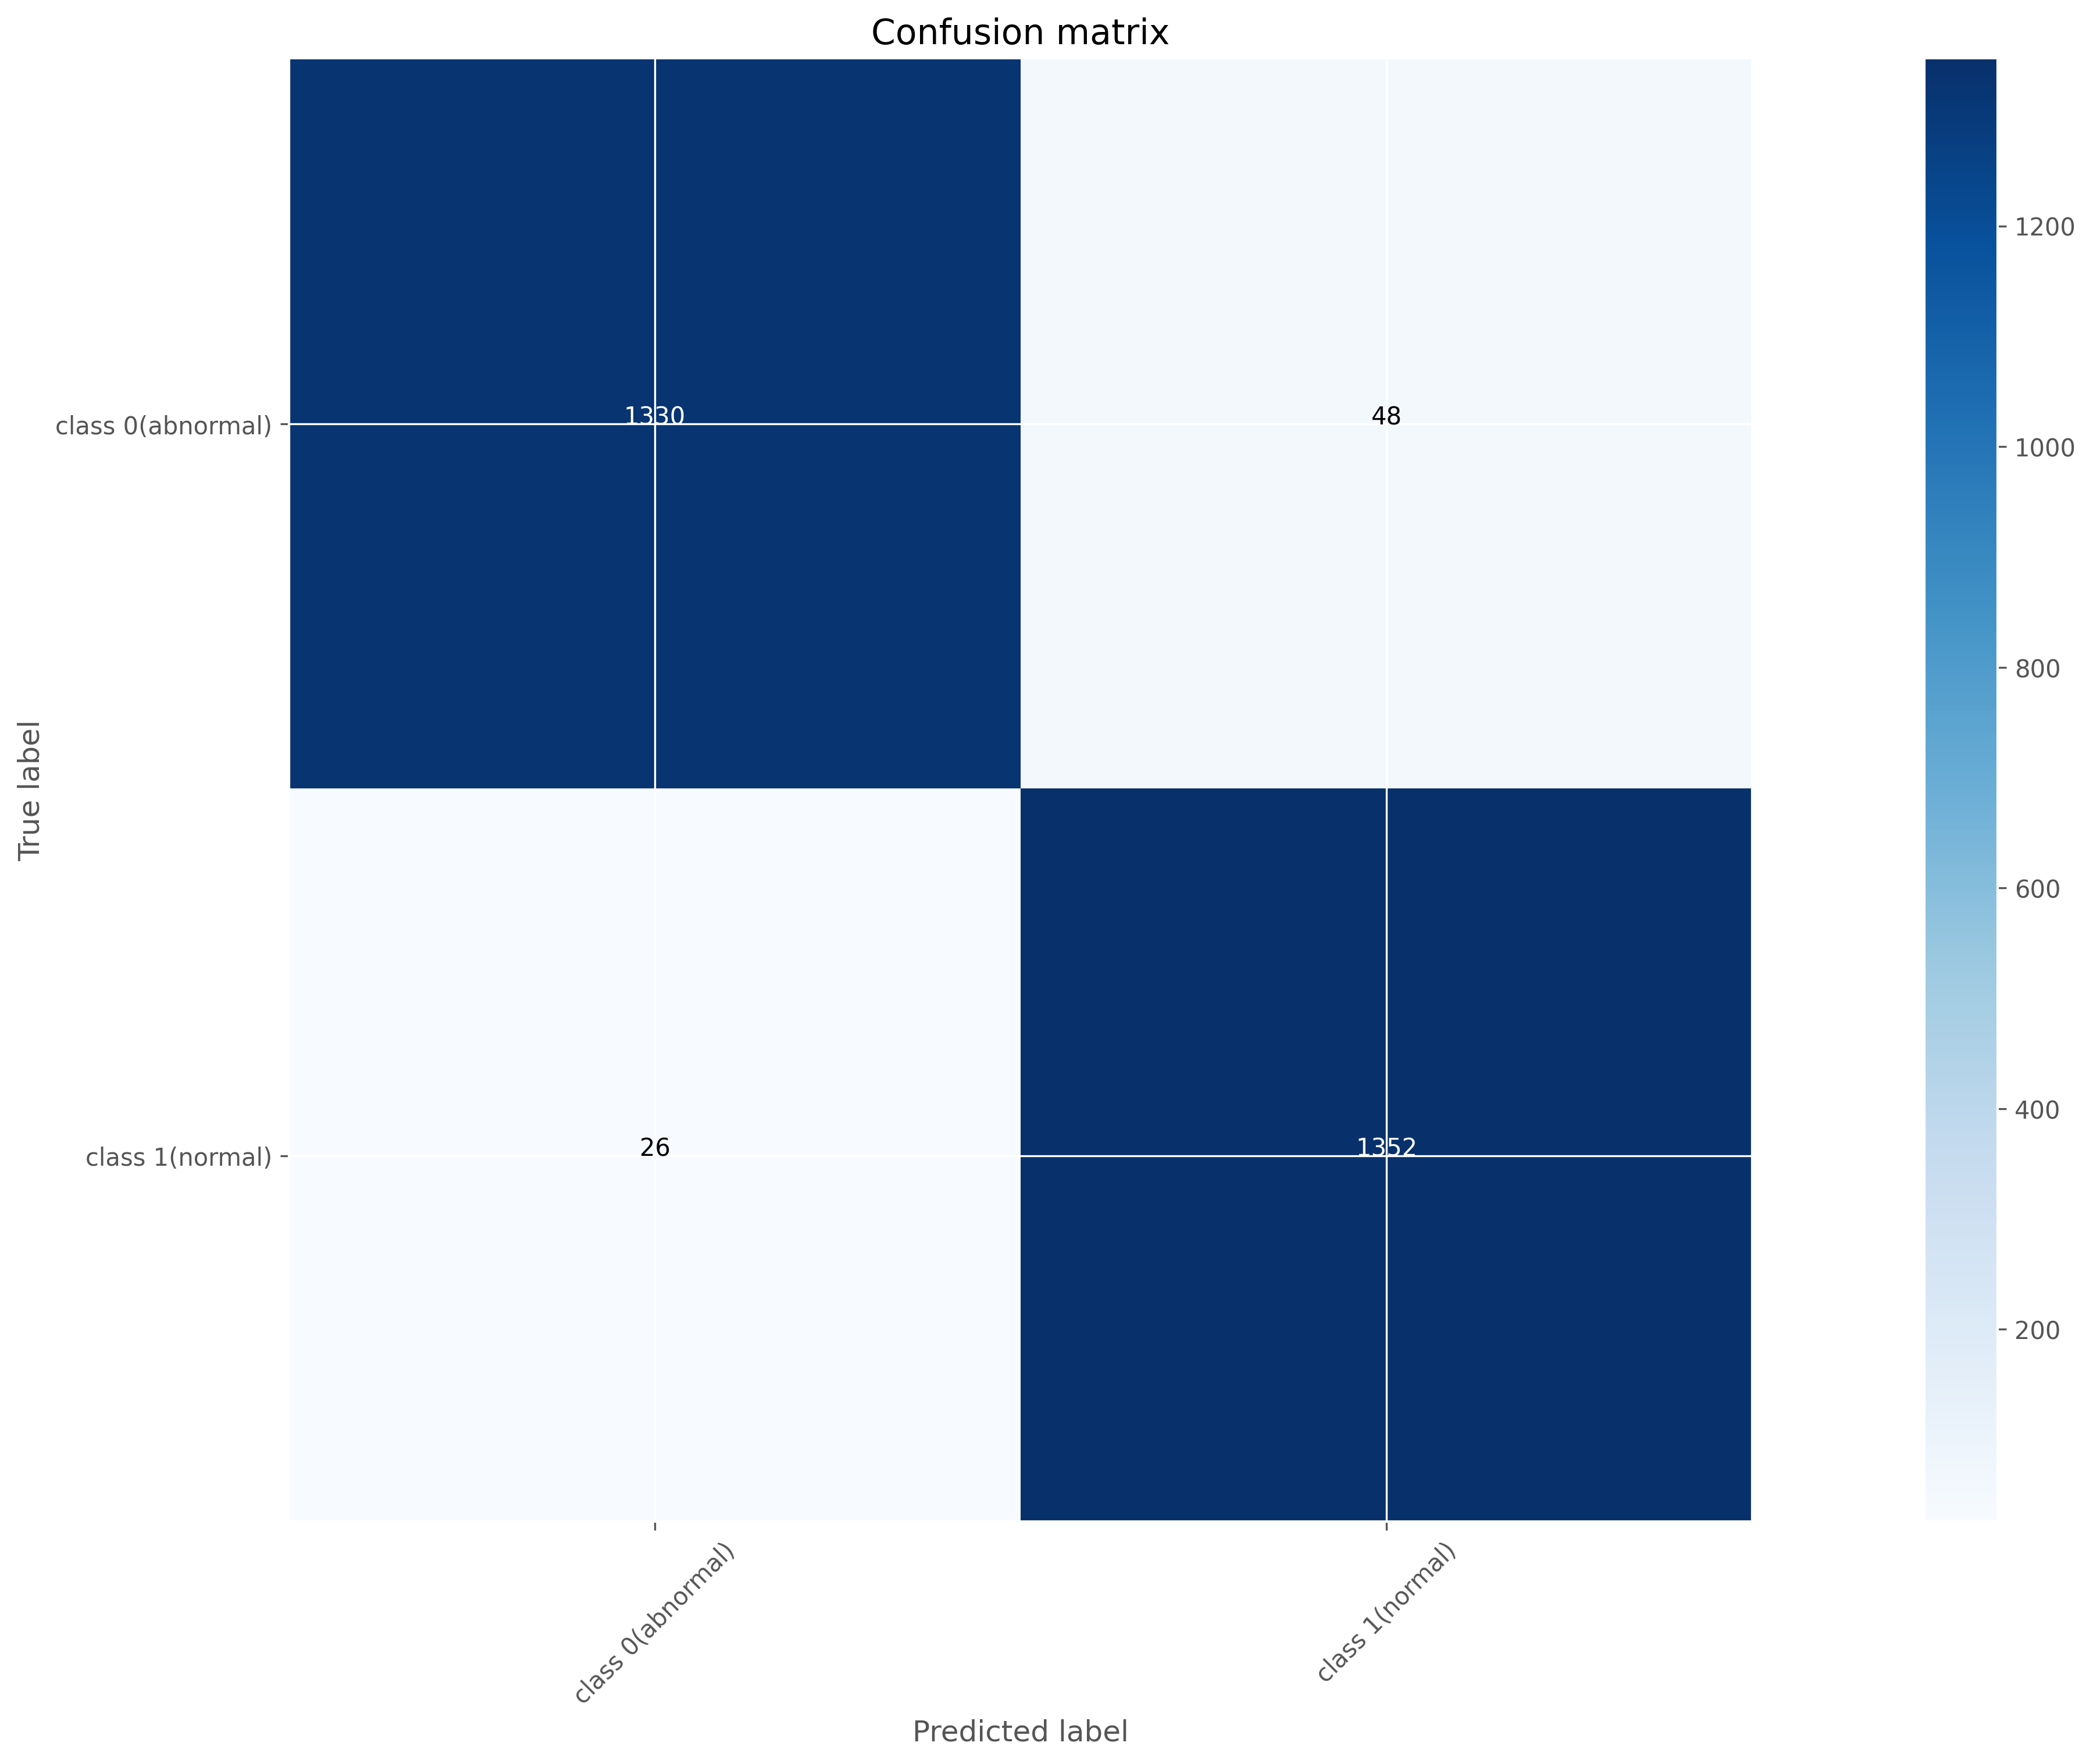

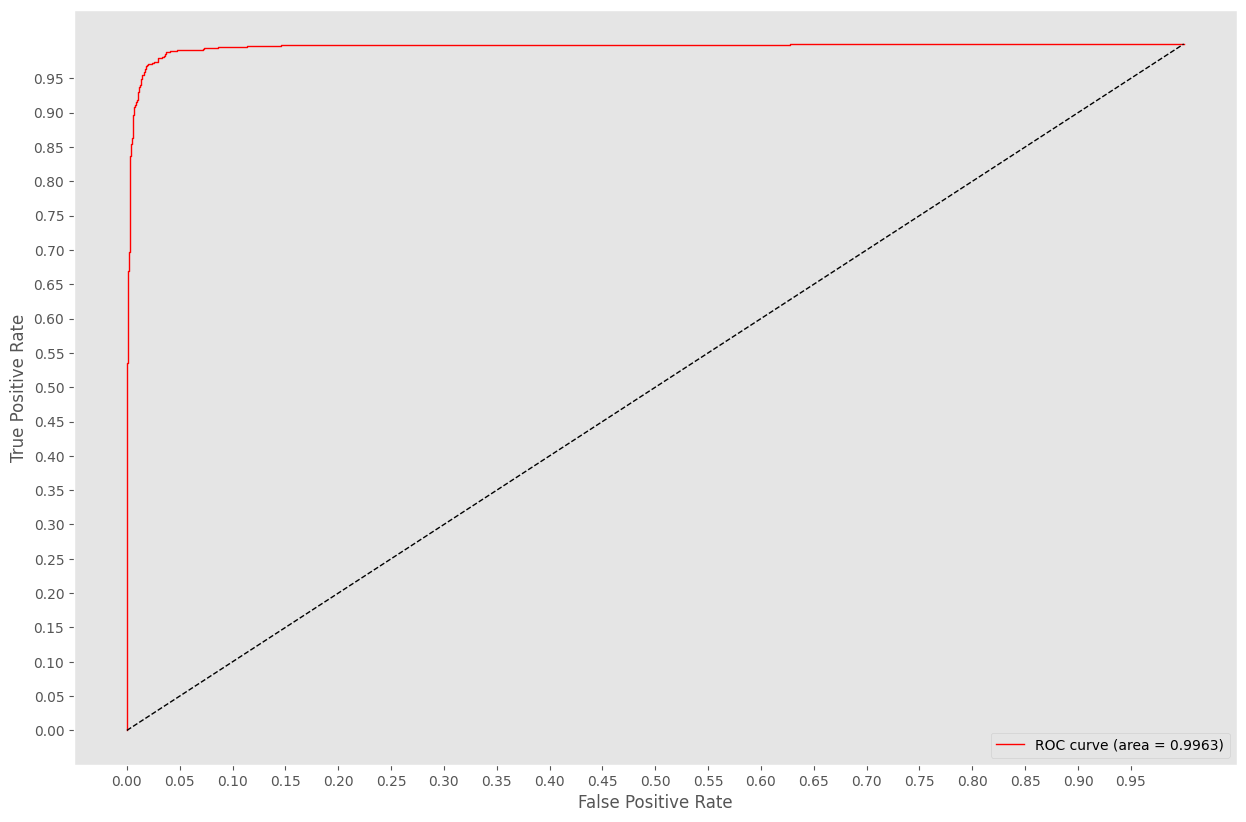

In [285]:
 #%% Pair F

pair_F_ensemble_model = ensemble(pair_F, model_input)
pair_F_ensemble_model.save('weights/ensemblemodel_pairF.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
F_ensem_y_pred = pair_F_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
F_ensemble_model_accuracy = accuracy_score(Y_test,F_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair F_ Ensemble model is: ', F_ensemble_model_accuracy)

#evaluate mean squared error
F_ensemble_model_custom_mse = mean_squared_error(Y_test,F_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair F_ Ensemble model is: ', F_ensemble_model_custom_mse)

#evaluate mean squared log error
F_ensemble_model_custom_msle = mean_squared_log_error(Y_test,F_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair F_Ensemble model is: ', F_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,F_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,F_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, F_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_39')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_40')>]
The Ensemble Model is Saved
The accuracy of the Pair G_ Ensemble model is:  0.974600870827286
The Mean Squared Error of the Pair G_ Ensemble model is:  0.02539912917271408
The Mean Squared Log Error of the Pair G_ Ensemble model is:  0.012203088161928192
                   precision    recall  f1-score   support

class 0(abnormal)     0.9845    0.9659    0.9751      1378
  class 1(normal)     0.9665    0.9848    0.9756      1378

         accuracy                         0.9753      2756
        macro avg     0.9755    0.9753    0.9753      2756
     weighted avg     0.9755    0.9753    0.9753      2756

Confusion matrix, without normalization
[[1334   44]
 [  26 1352]]


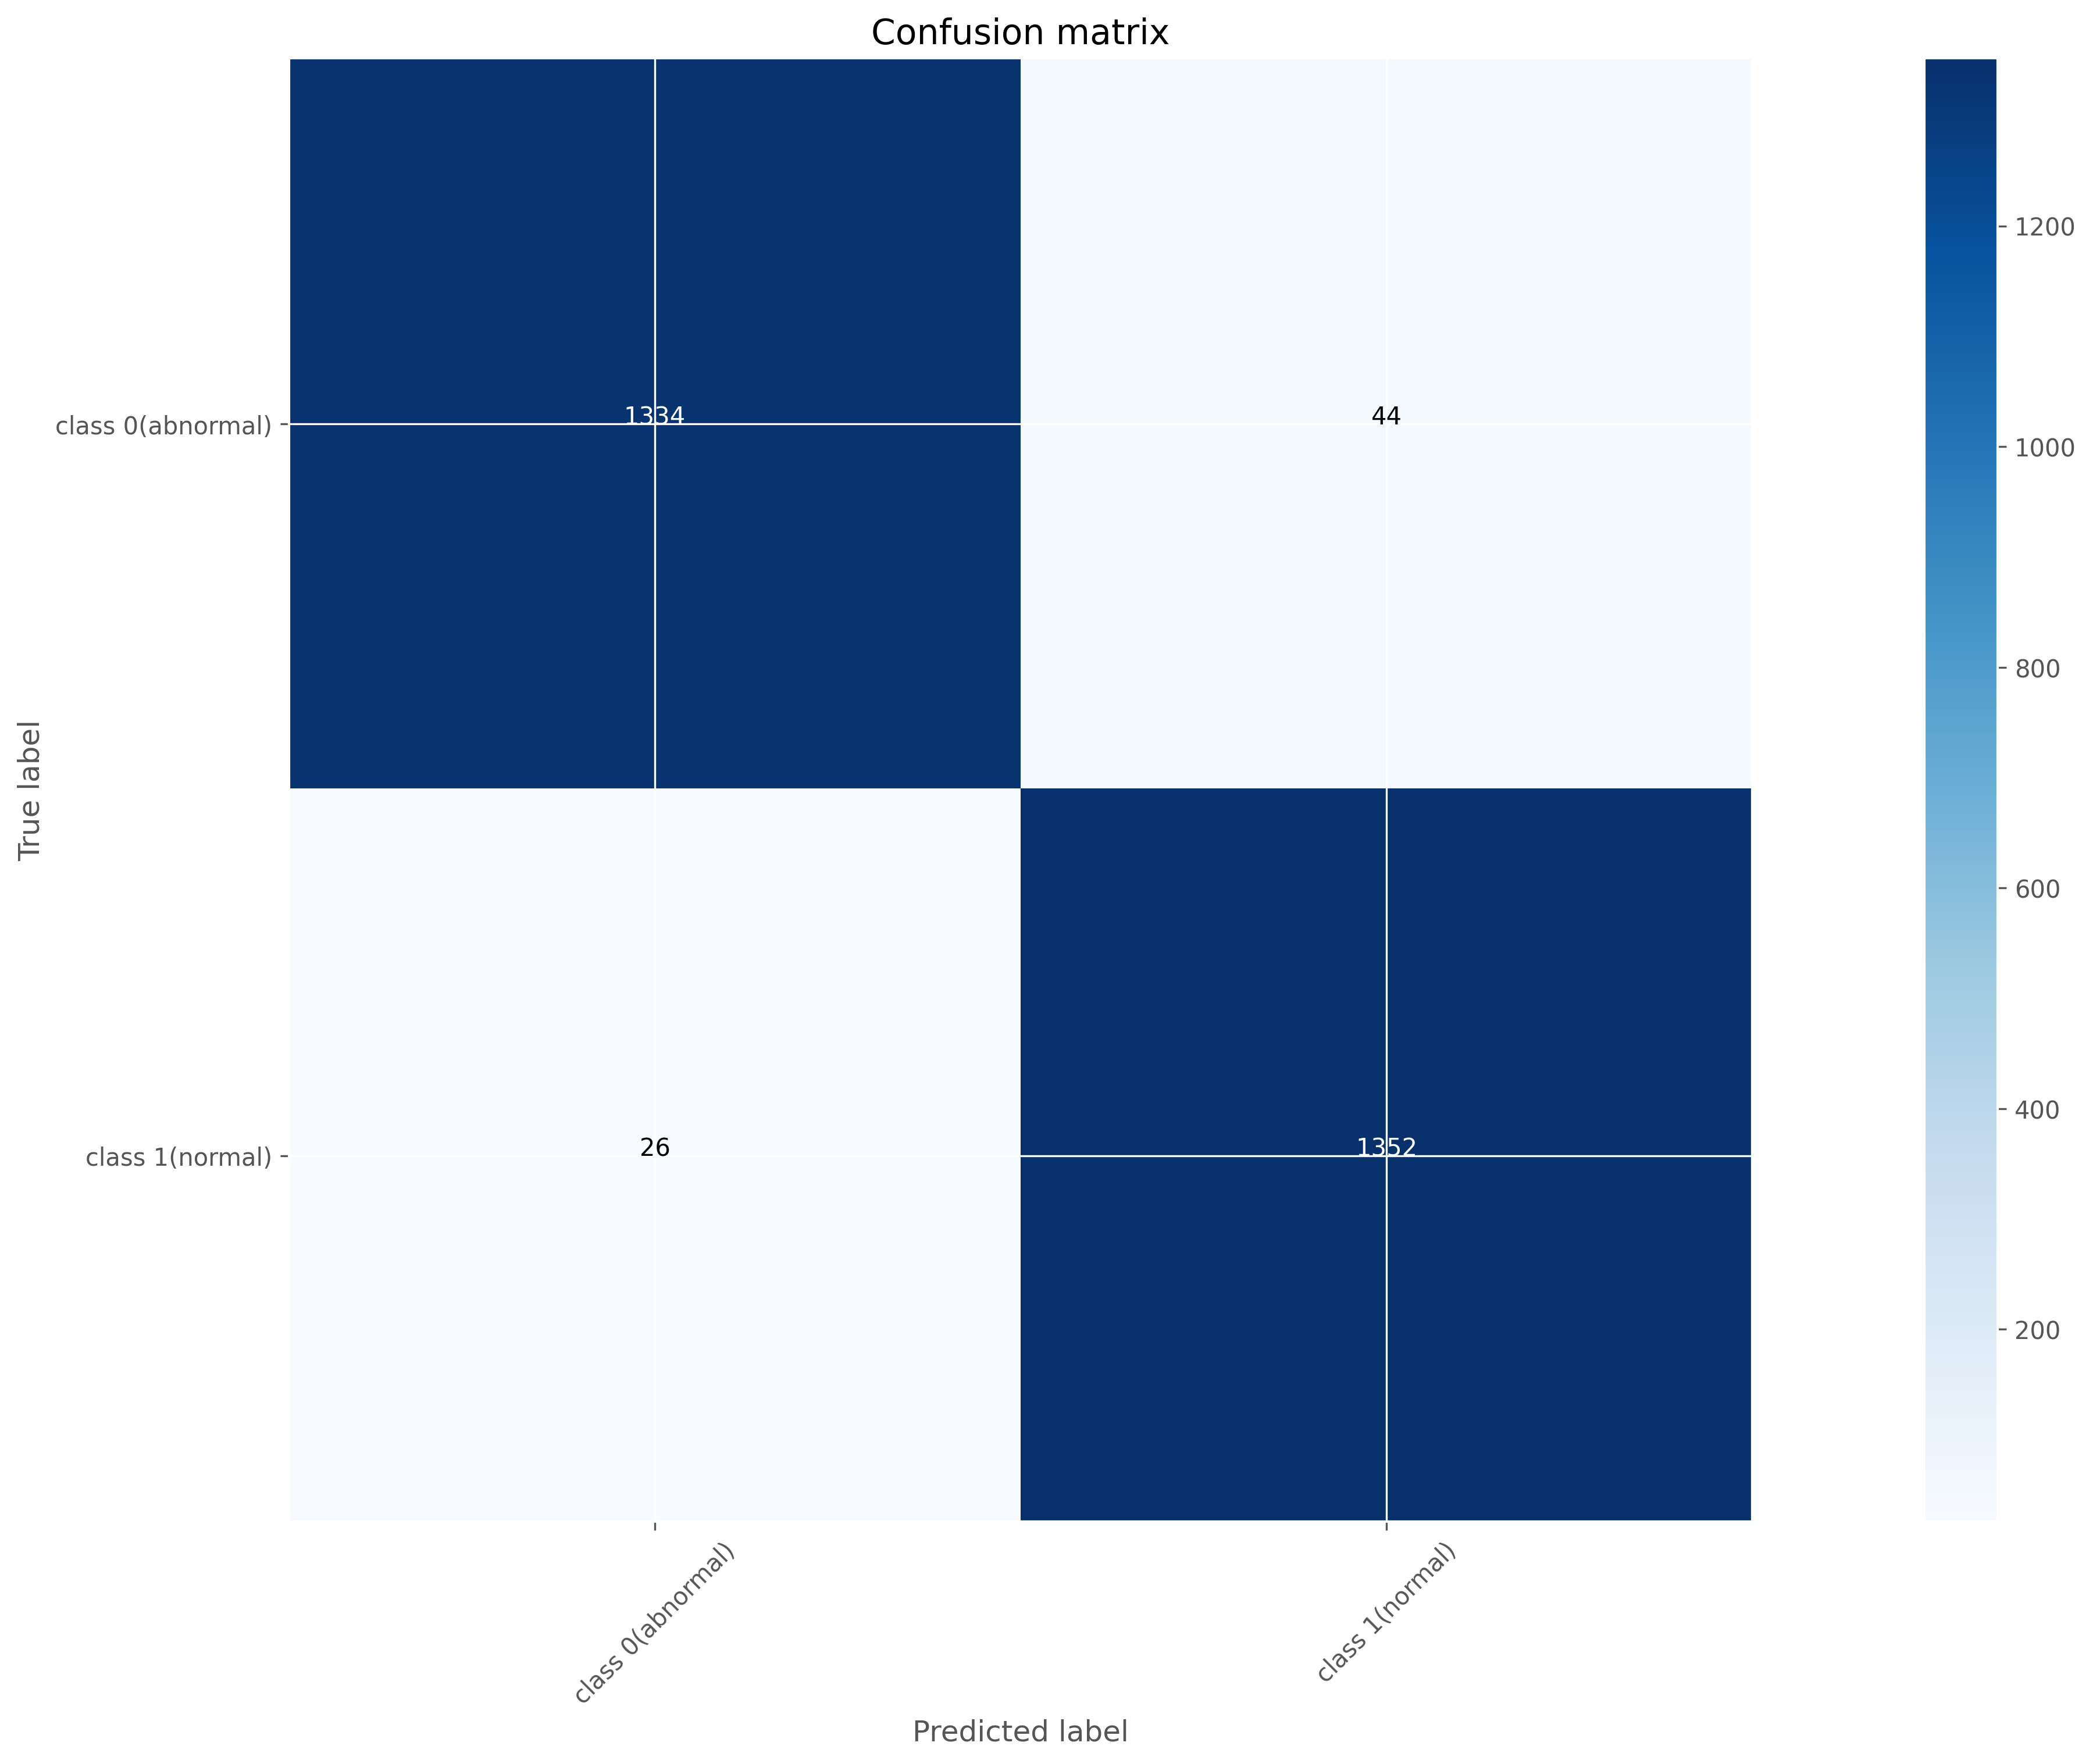

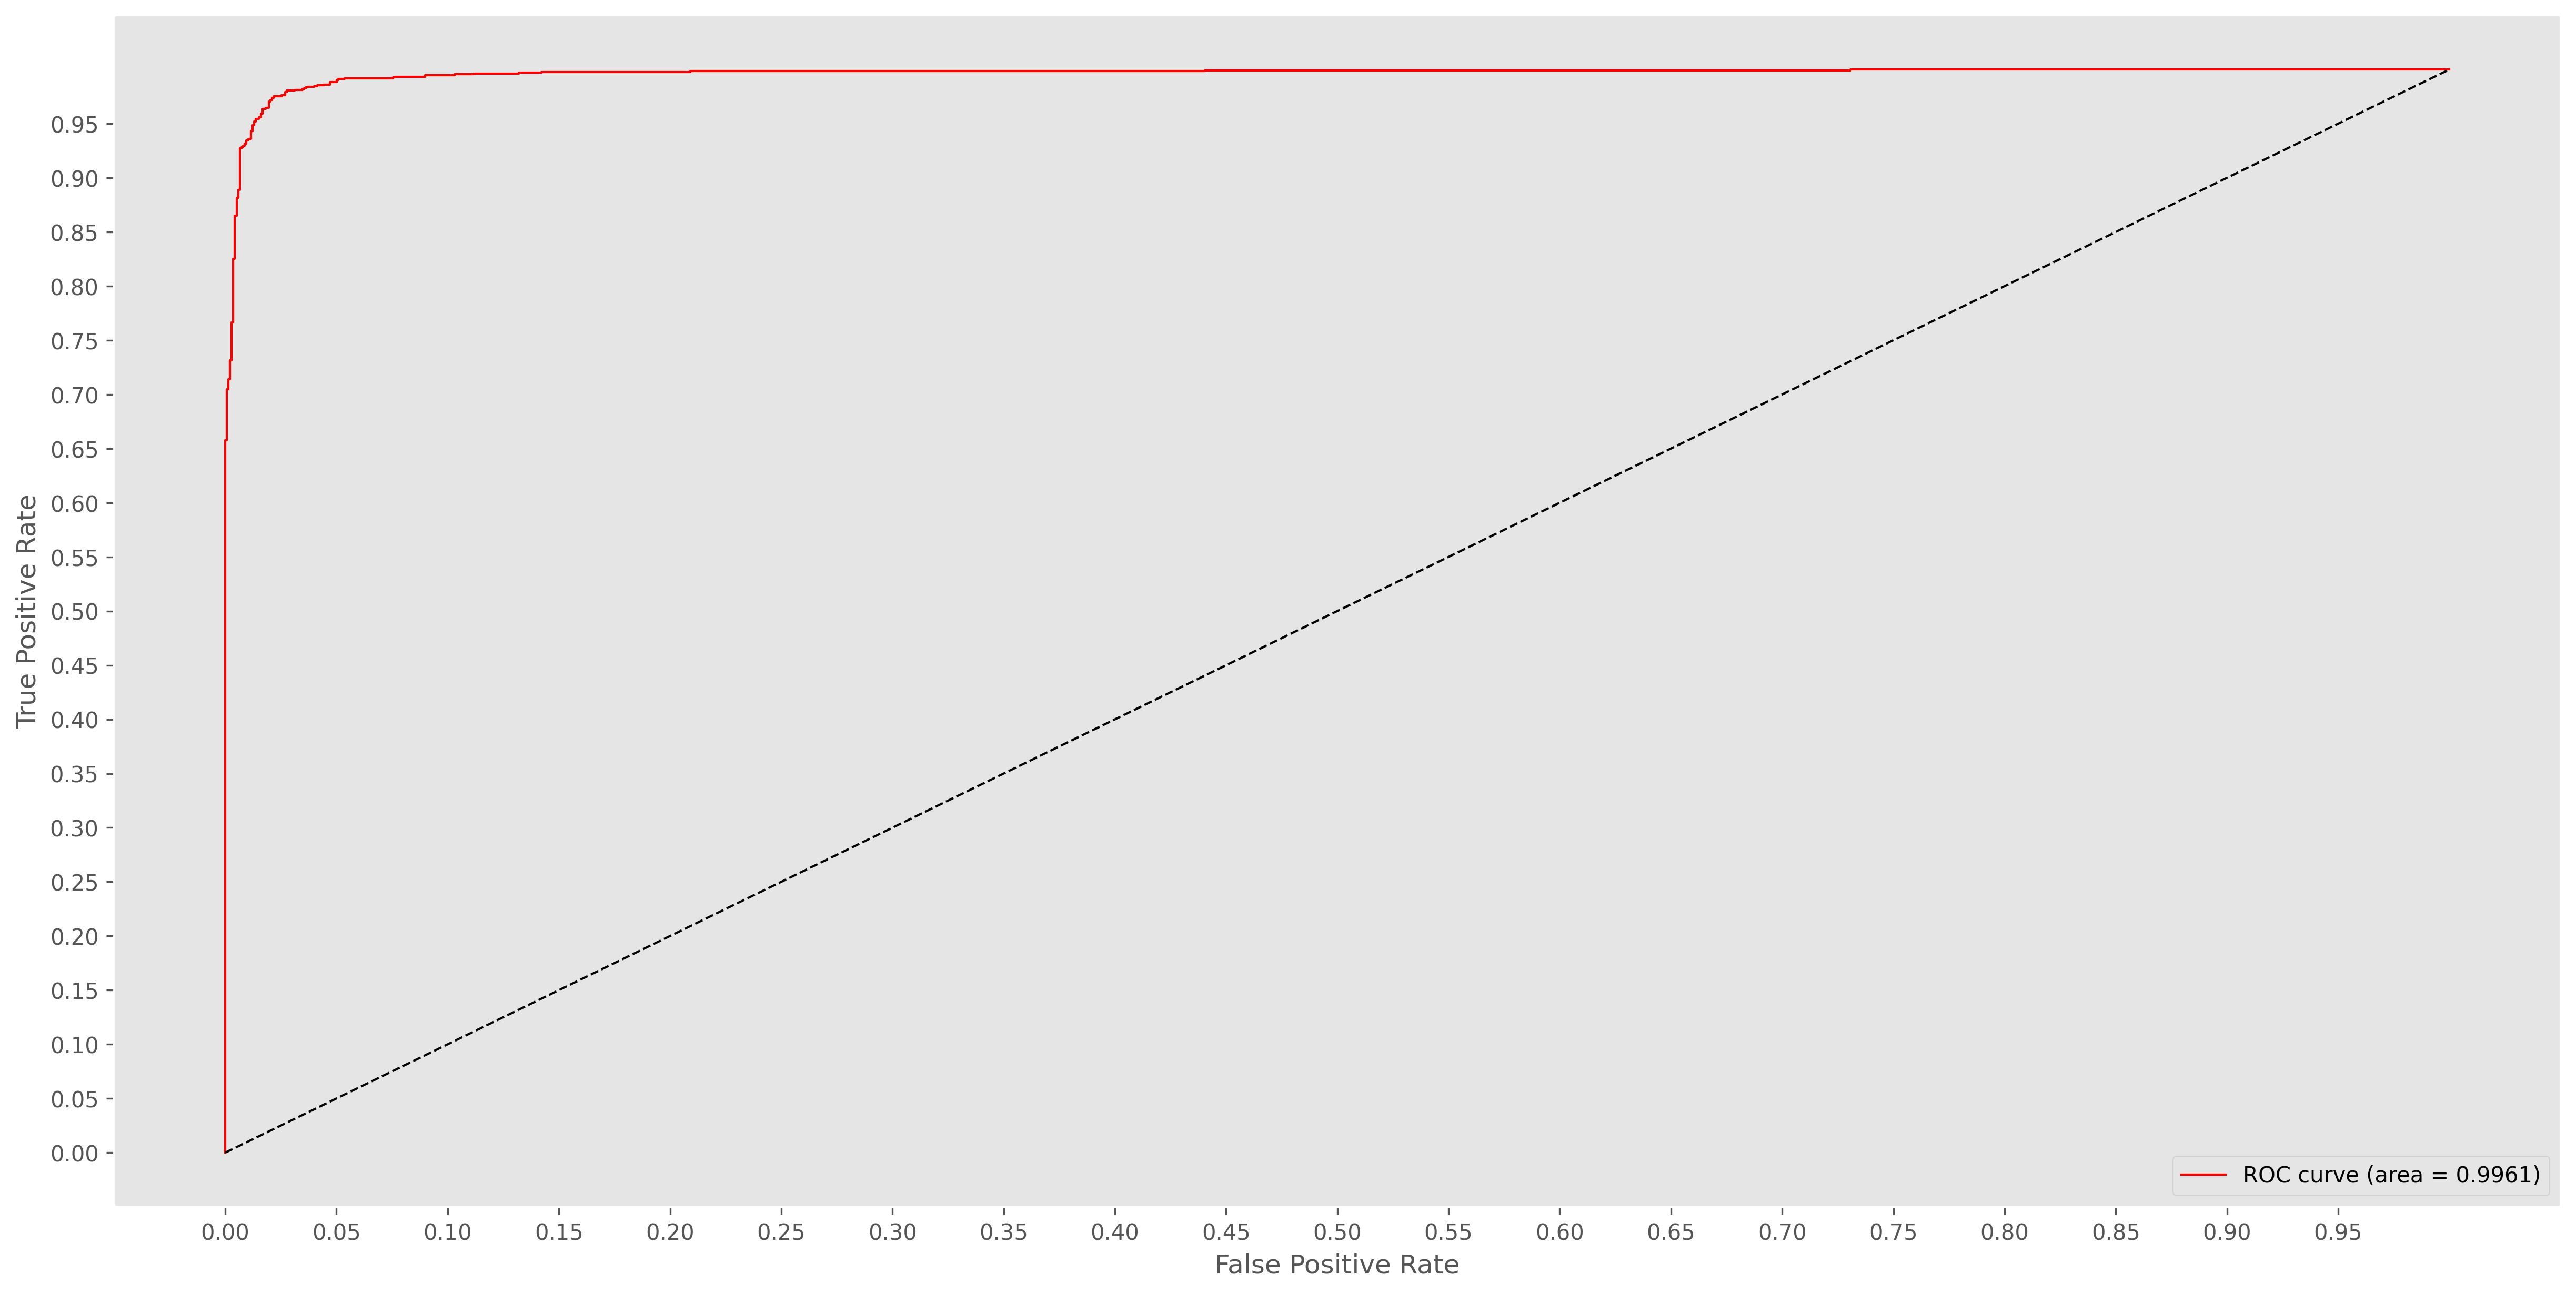

In [286]:
 #%% Pair G

pair_G_ensemble_model = ensemble(pair_G, model_input)
pair_G_ensemble_model.save('weights/ensemblemodel_pairG.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
G_ensem_y_pred = pair_G_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
G_ensemble_model_accuracy = accuracy_score(Y_test,G_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair G_ Ensemble model is: ', G_ensemble_model_accuracy)

#evaluate mean squared error
G_ensemble_model_custom_mse = mean_squared_error(Y_test,G_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair G_ Ensemble model is: ', G_ensemble_model_custom_mse)

#evaluate mean squared log error
G_ensemble_model_custom_msle = mean_squared_log_error(Y_test,G_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair G_ Ensemble model is: ', G_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,G_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, G_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_39')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_41')>]
The Ensemble Model is Saved
The accuracy of the Pair H_ Ensemble model is:  0.974600870827286
The Mean Squared Error of the Pair H_ Ensemble model is:  0.02539912917271408
The Mean Squared Log Error of the Pair H_ Ensemble model is:  0.012203088161928192
                   precision    recall  f1-score   support

class 0(abnormal)     0.9845    0.9659    0.9751      1378
  class 1(normal)     0.9665    0.9848    0.9756      1378

         accuracy                         0.9753      2756
        macro avg     0.9755    0.9753    0.9753      2756
     weighted avg     0.9755    0.9753    0.9753      2756

Confusion matrix, without normalization
[[1330   48]
 [  22 1356]]


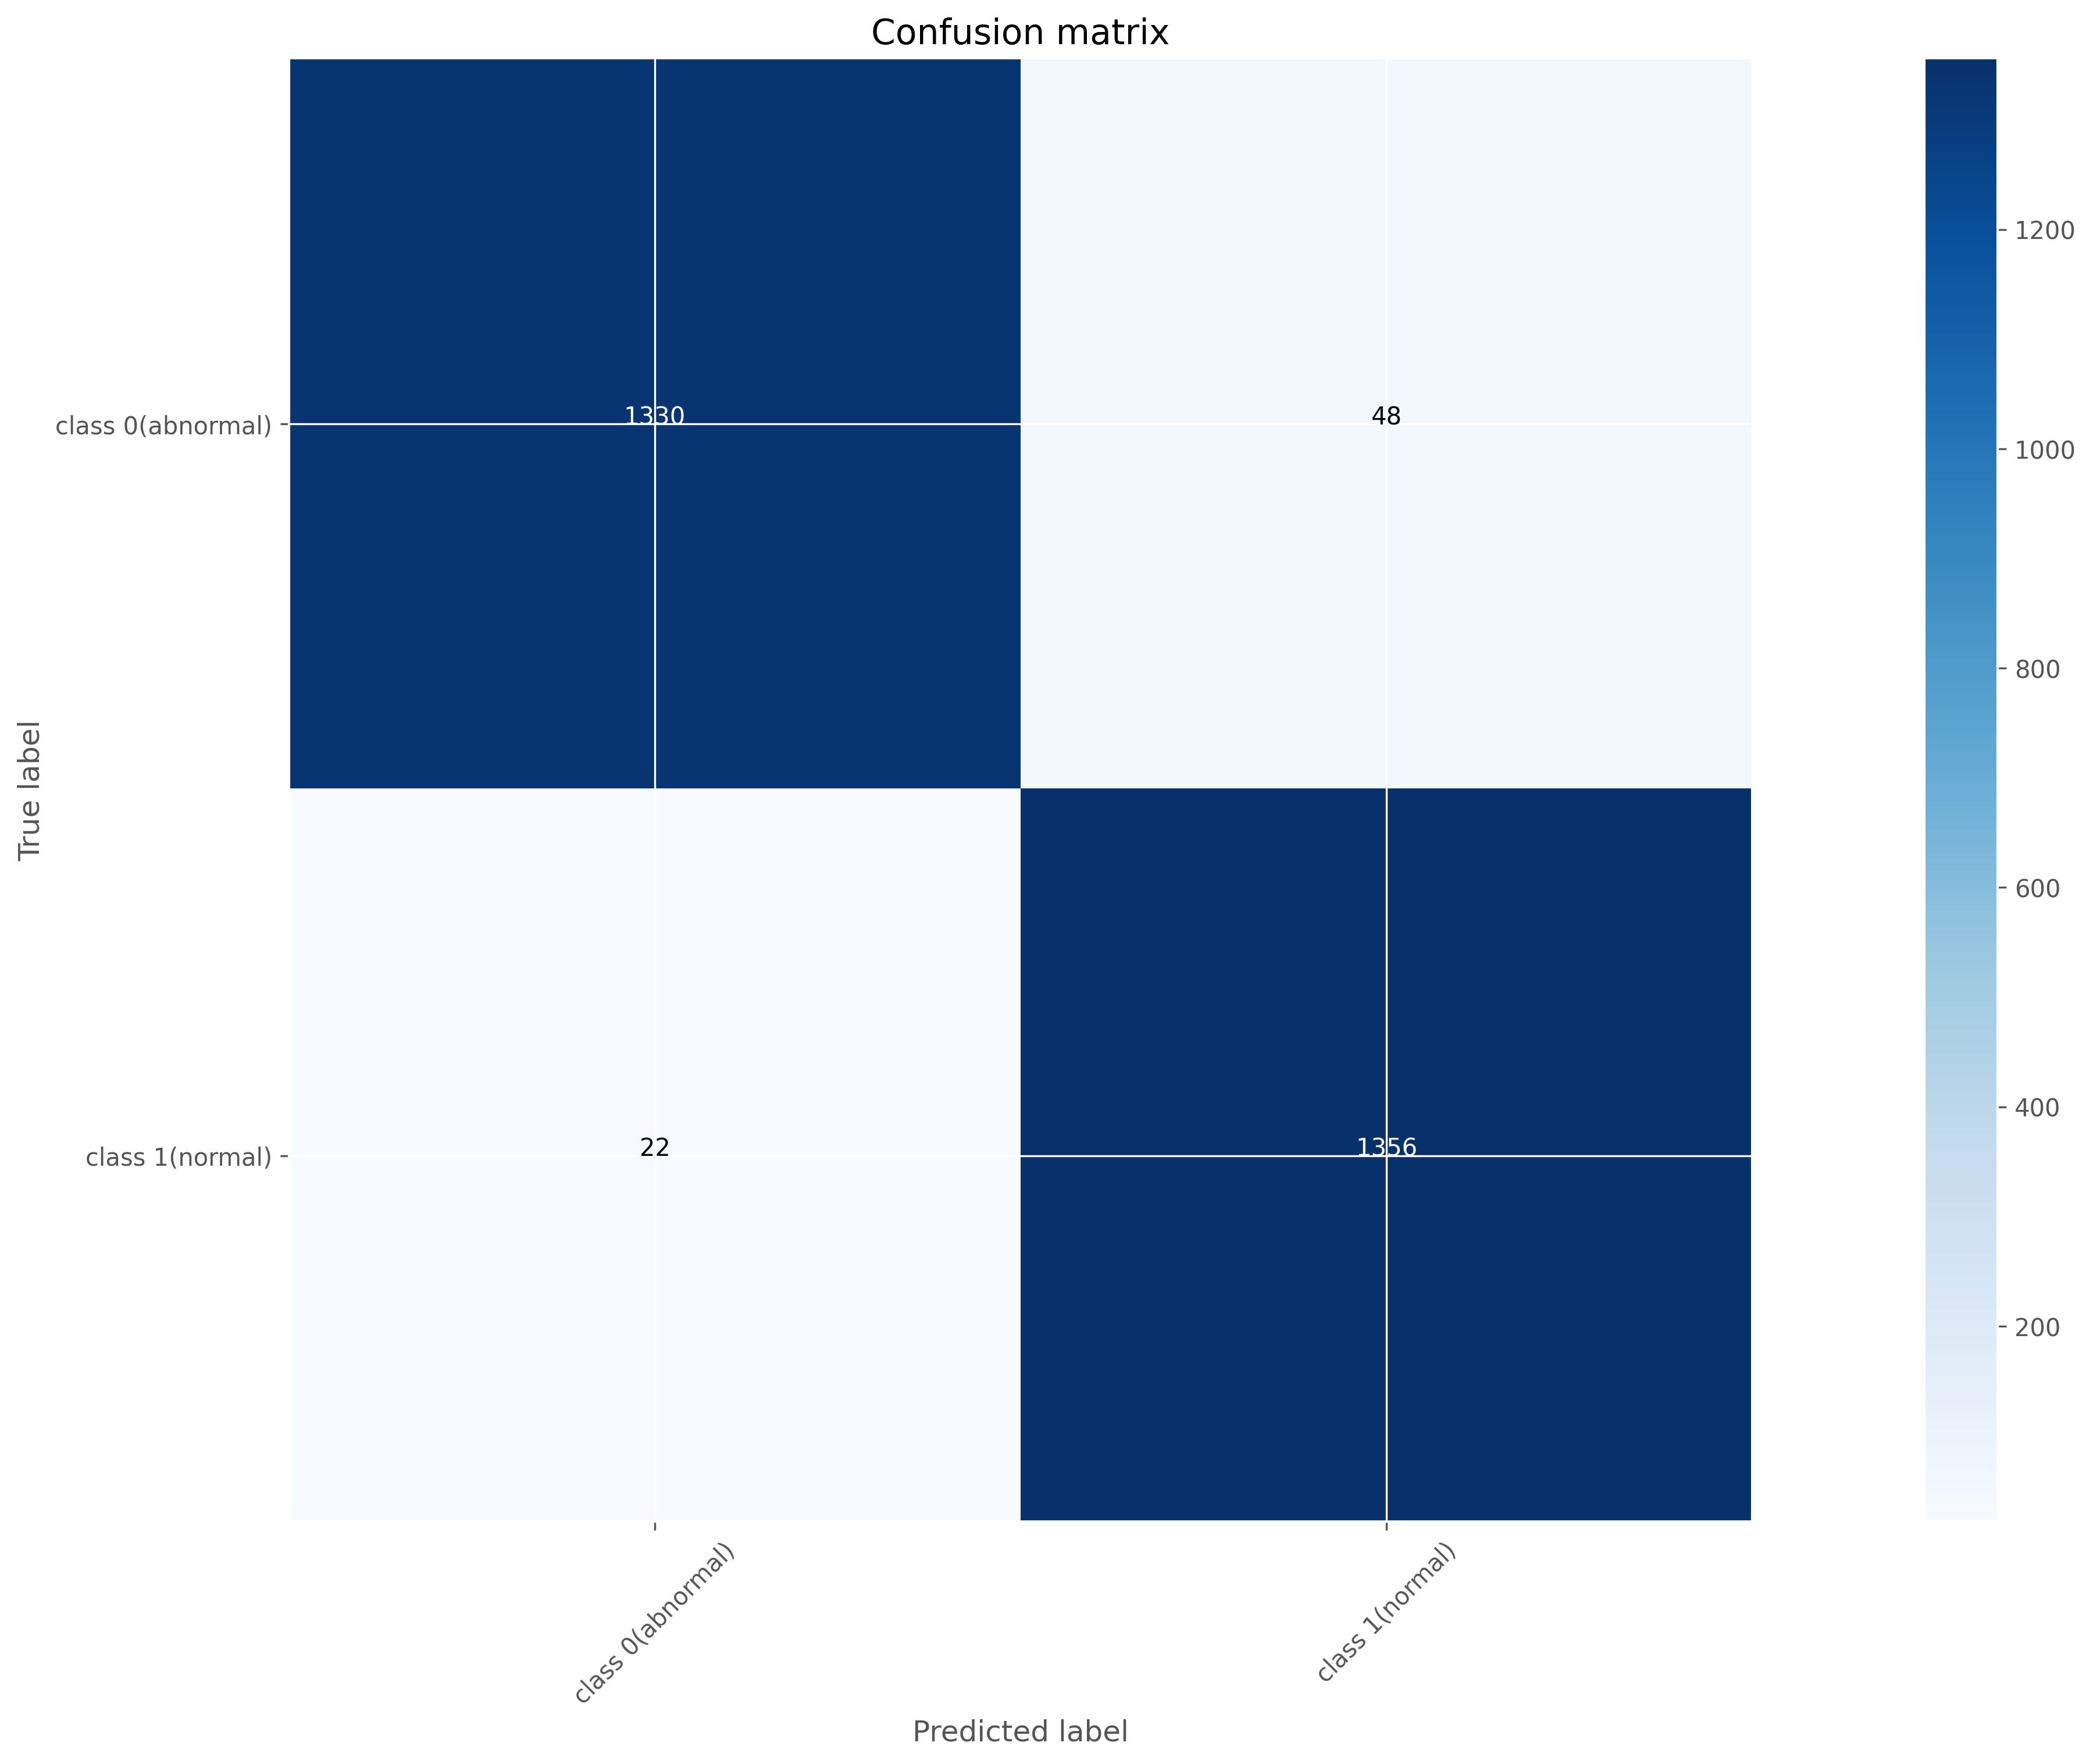

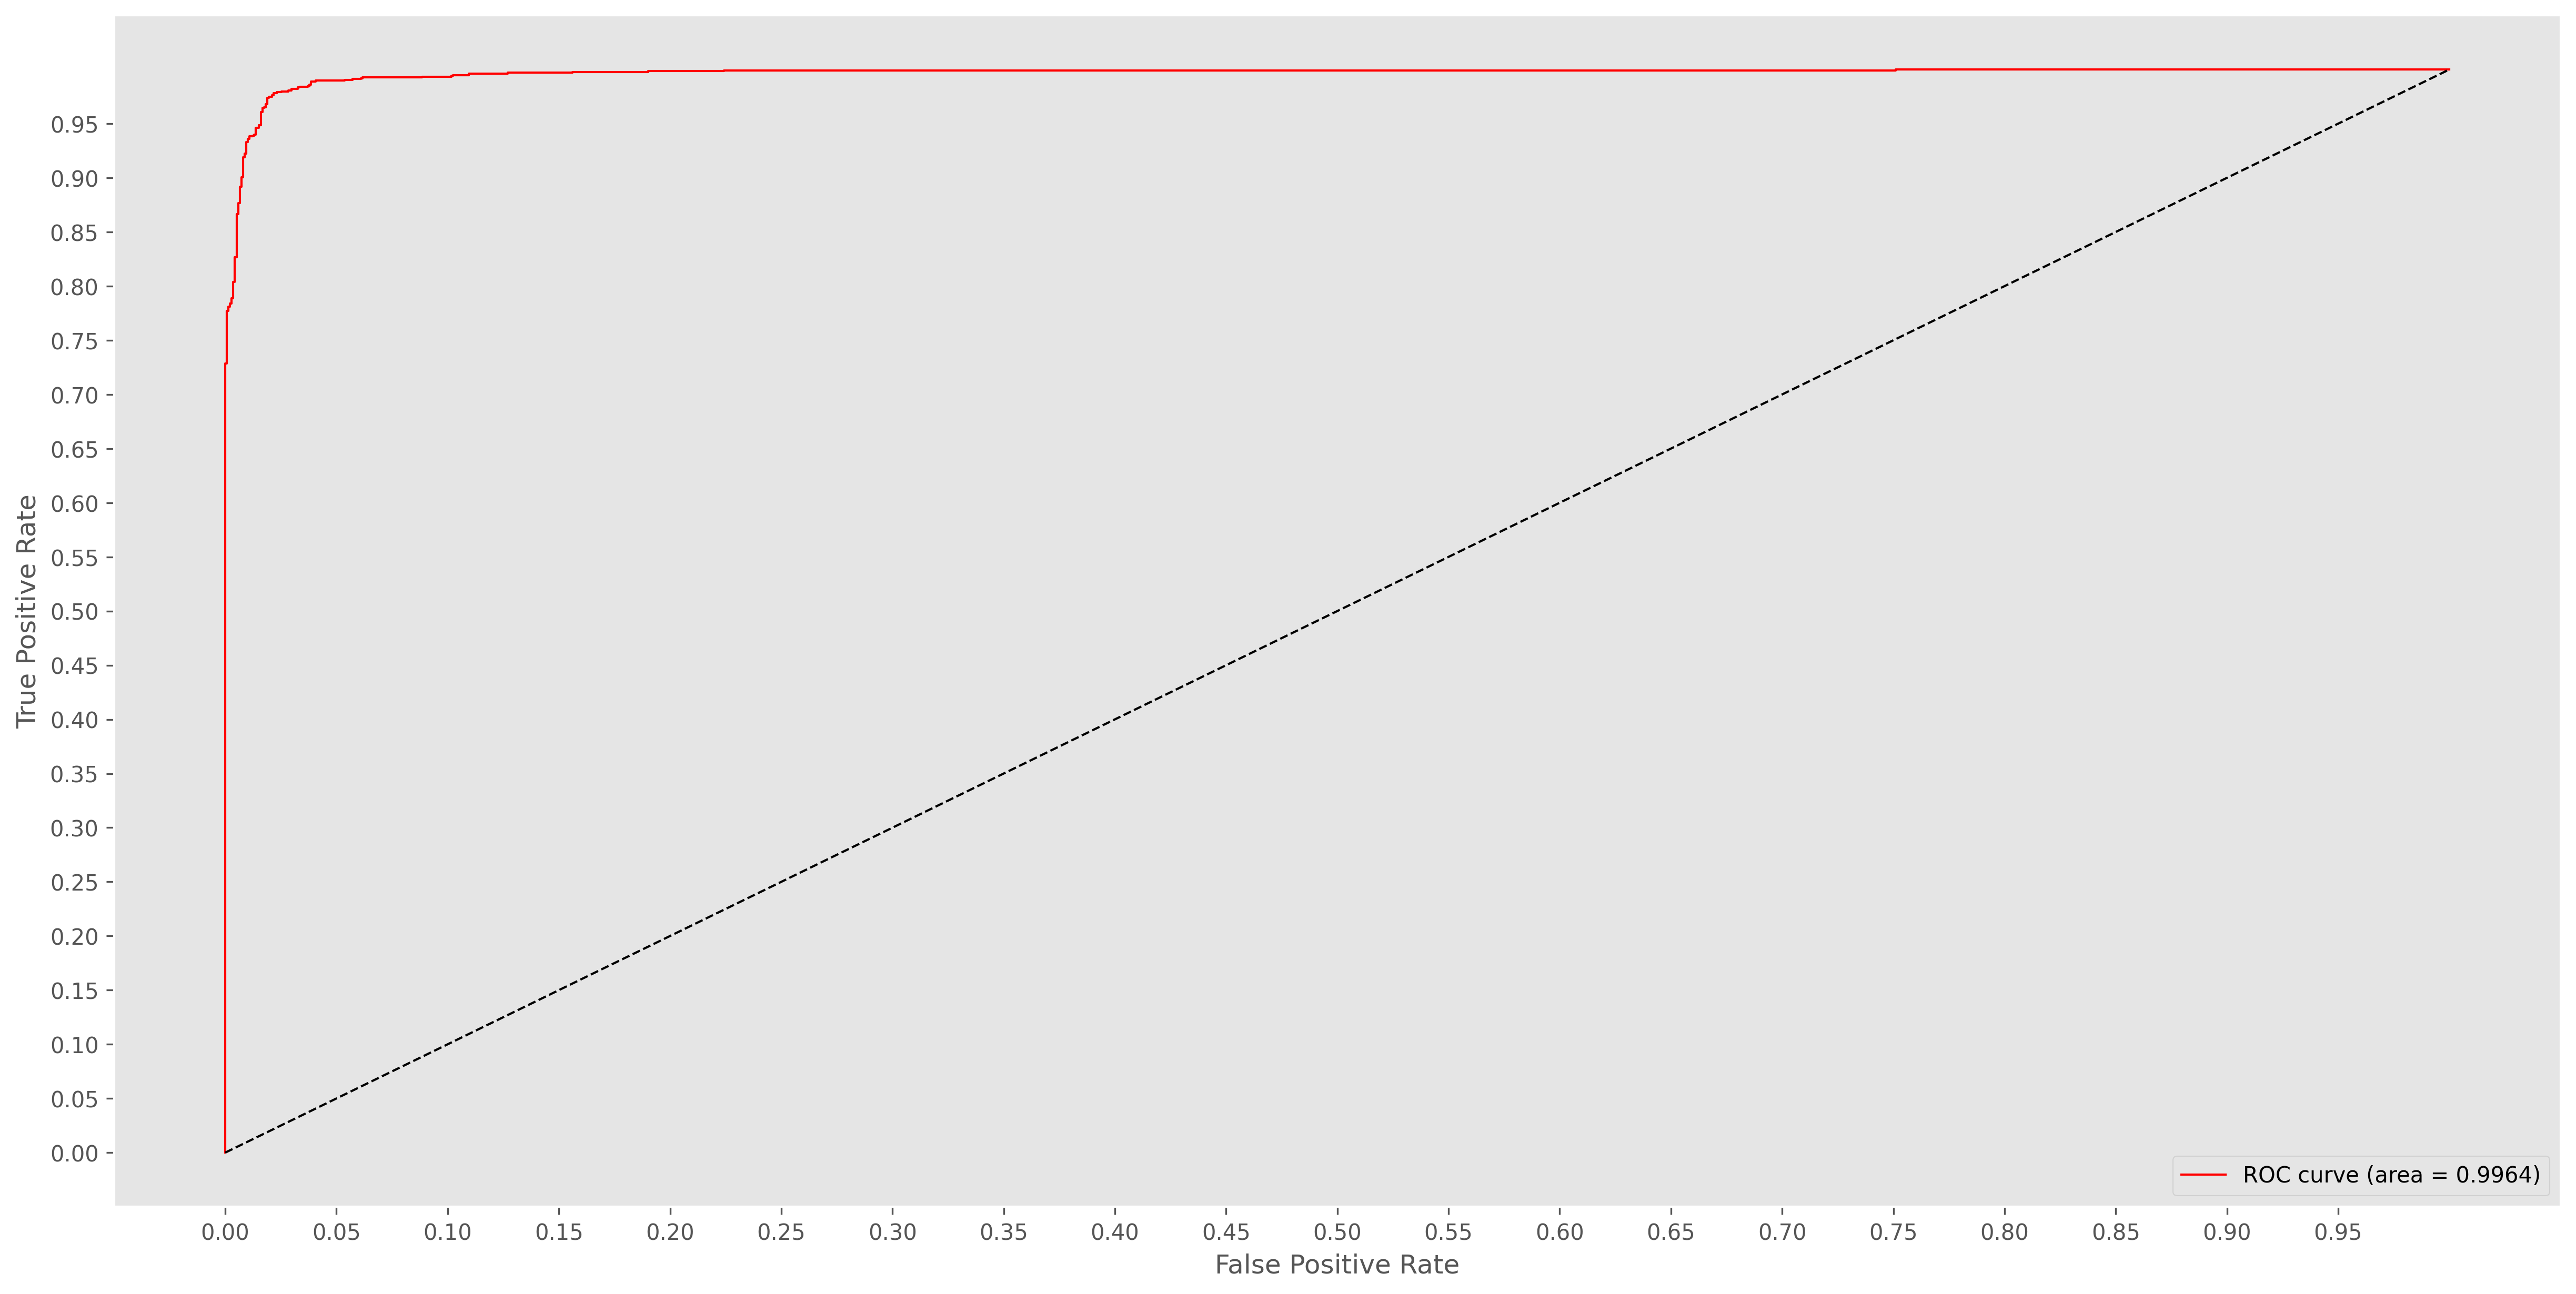

In [287]:
#%% Pair H

pair_H_ensemble_model = ensemble(pair_H, model_input)
pair_H_ensemble_model.save('weights/ensemblemodel_pairH.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
H_ensem_y_pred = pair_H_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
H_ensemble_model_accuracy = accuracy_score(Y_test,H_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair H_ Ensemble model is: ', H_ensemble_model_accuracy)

#evaluate mean squared error
H_ensemble_model_custom_mse = mean_squared_error(Y_test,H_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair H_ Ensemble model is: ', H_ensemble_model_custom_mse)

#evaluate mean squared log error
H_ensemble_model_custom_msle = mean_squared_log_error(Y_test,H_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair H_ Ensemble model is: ', H_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,H_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, H_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_39')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_40')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_41')>]
The Ensemble Model is Saved
The accuracy of the Pair I_ Ensemble model is:  0.9775036284470247
The Mean Squared Error of the Pair I_ Ensemble model is:  0.022496371552975326
The Mean Squared Log Error of the Pair I_ Ensemble model is:  0.010808449514850684
                   precision    recall  f1-score   support

class 0(abnormal)     0.9860    0.9688    0.9773      1378
  class 1(normal)     0.9693    0.9862    0.9777      1378

         accuracy                         0.9775      2756
        macro avg     0.9776    0.9775    0.9775      2756
     weighted avg     0.9776    0.9775    0.9775      2756

Confusion matrix, without normalization
[[1335   43]
 [  19 1359]]


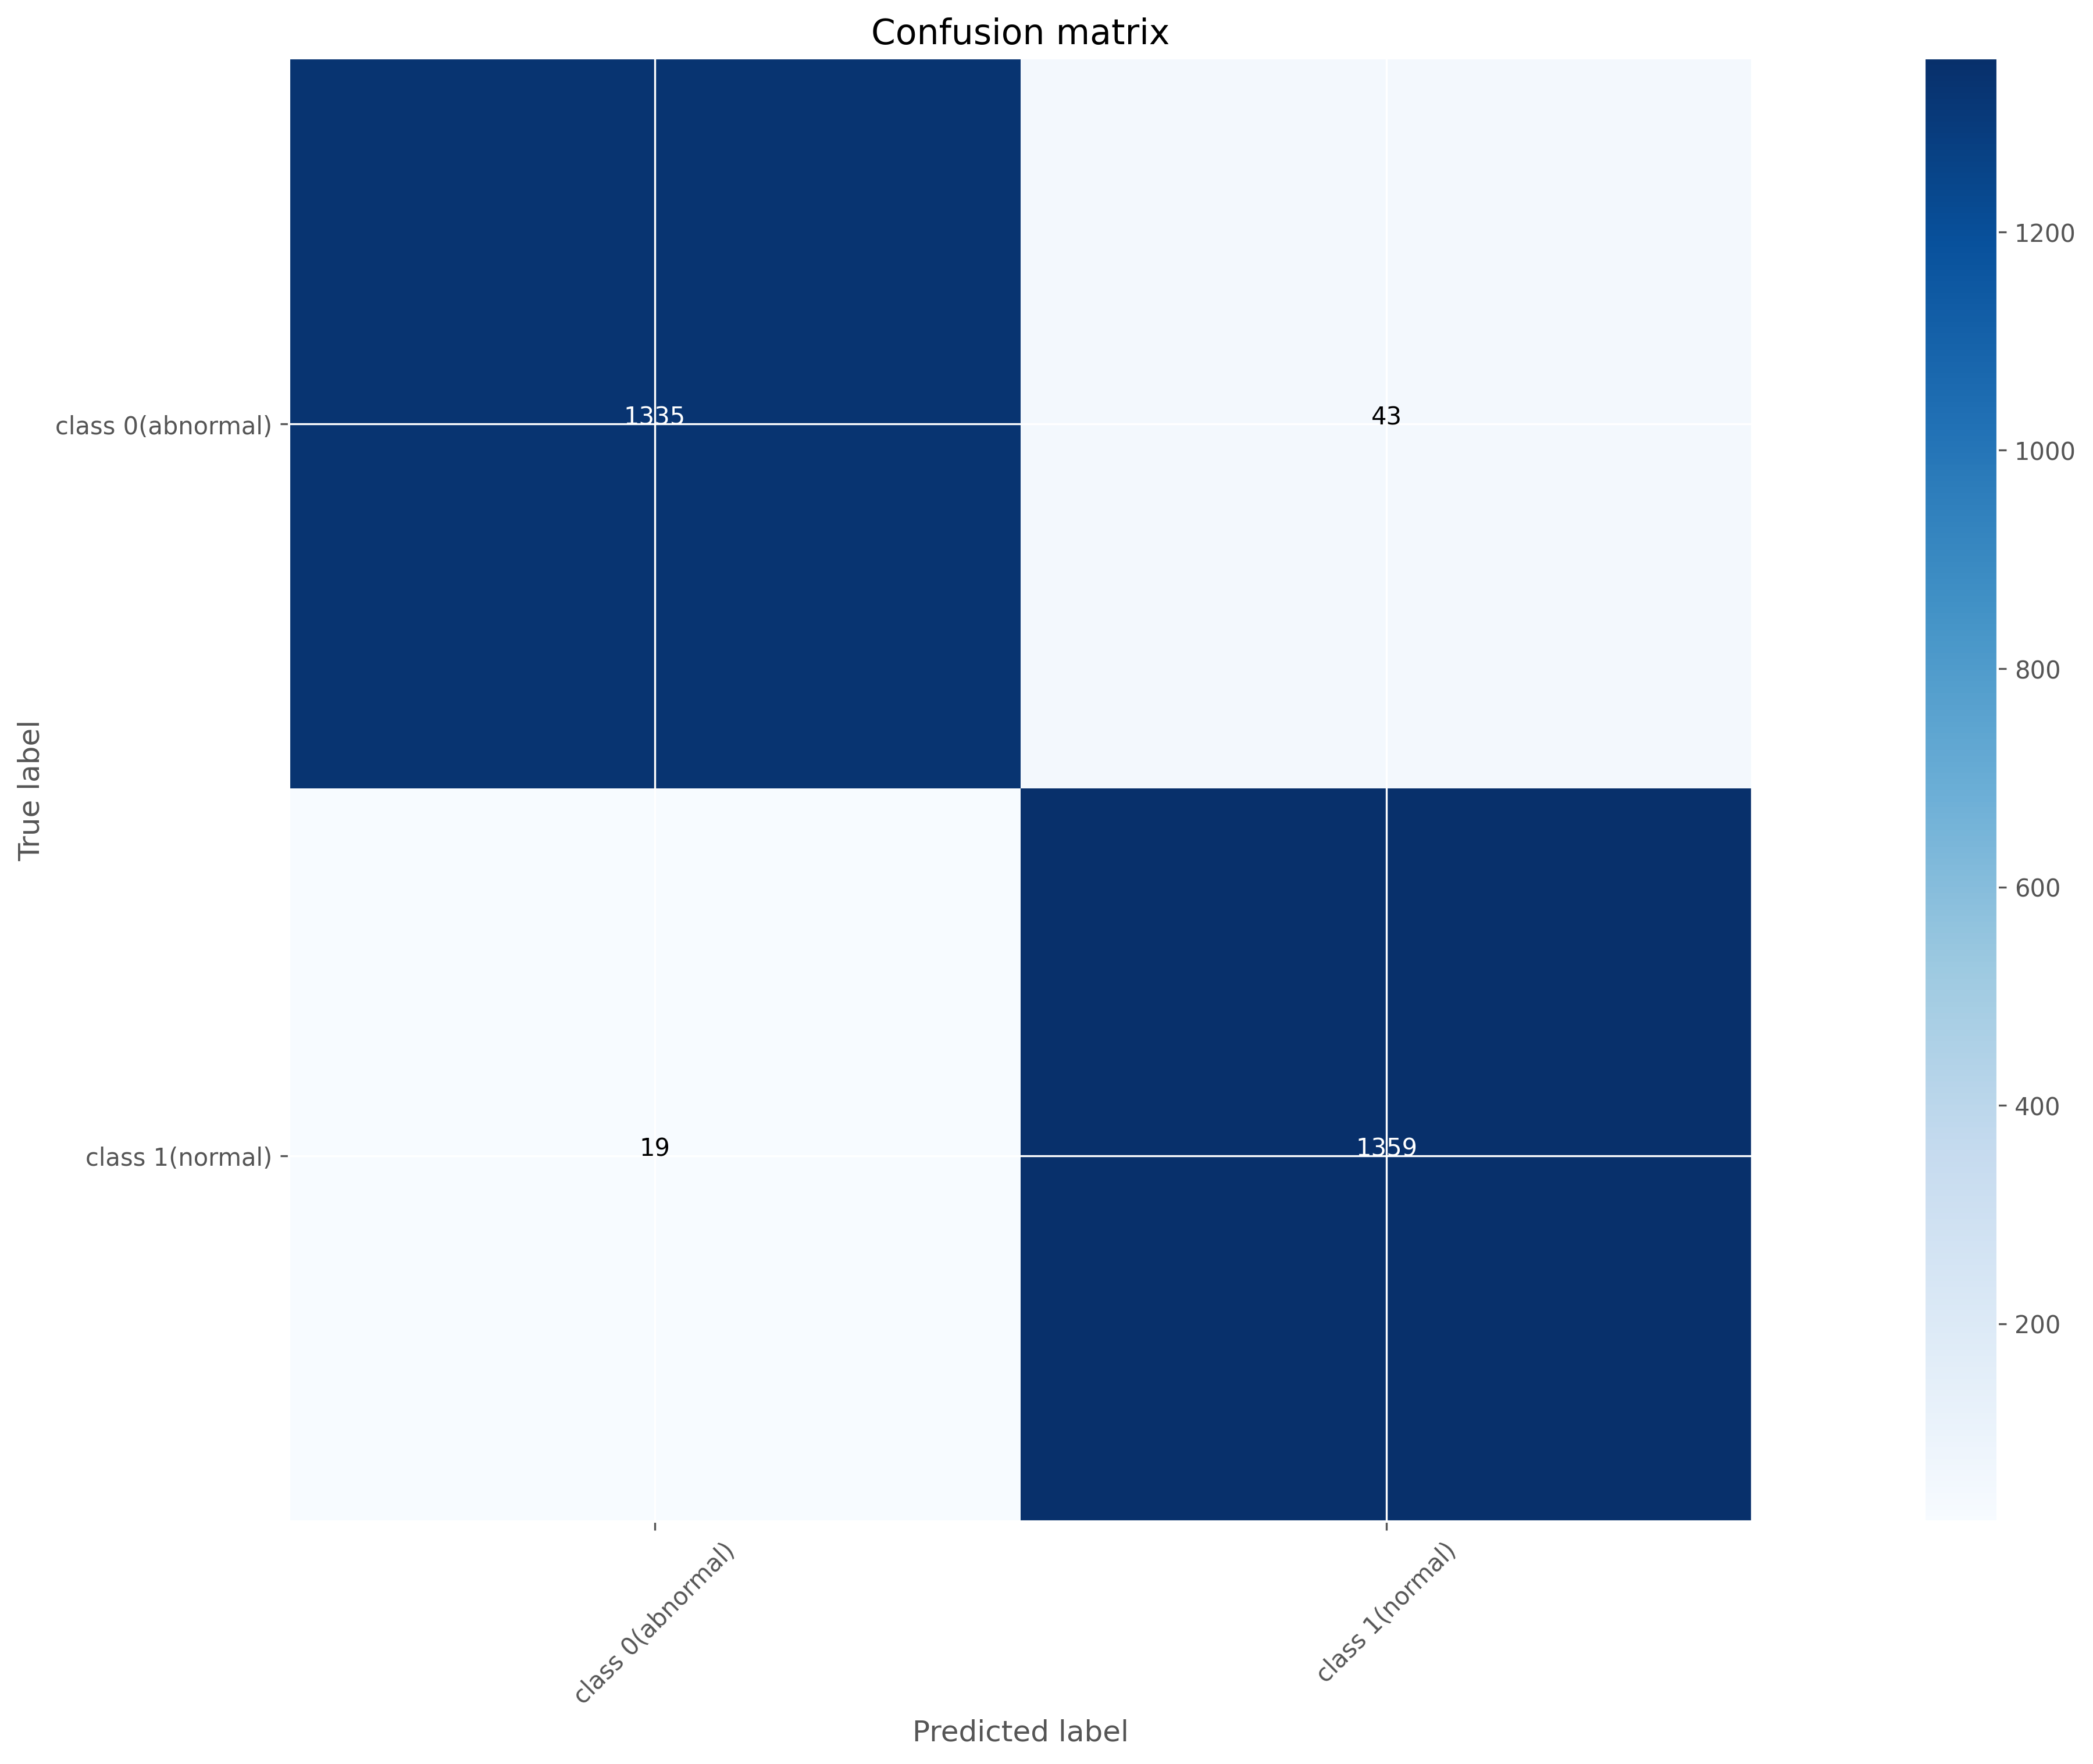

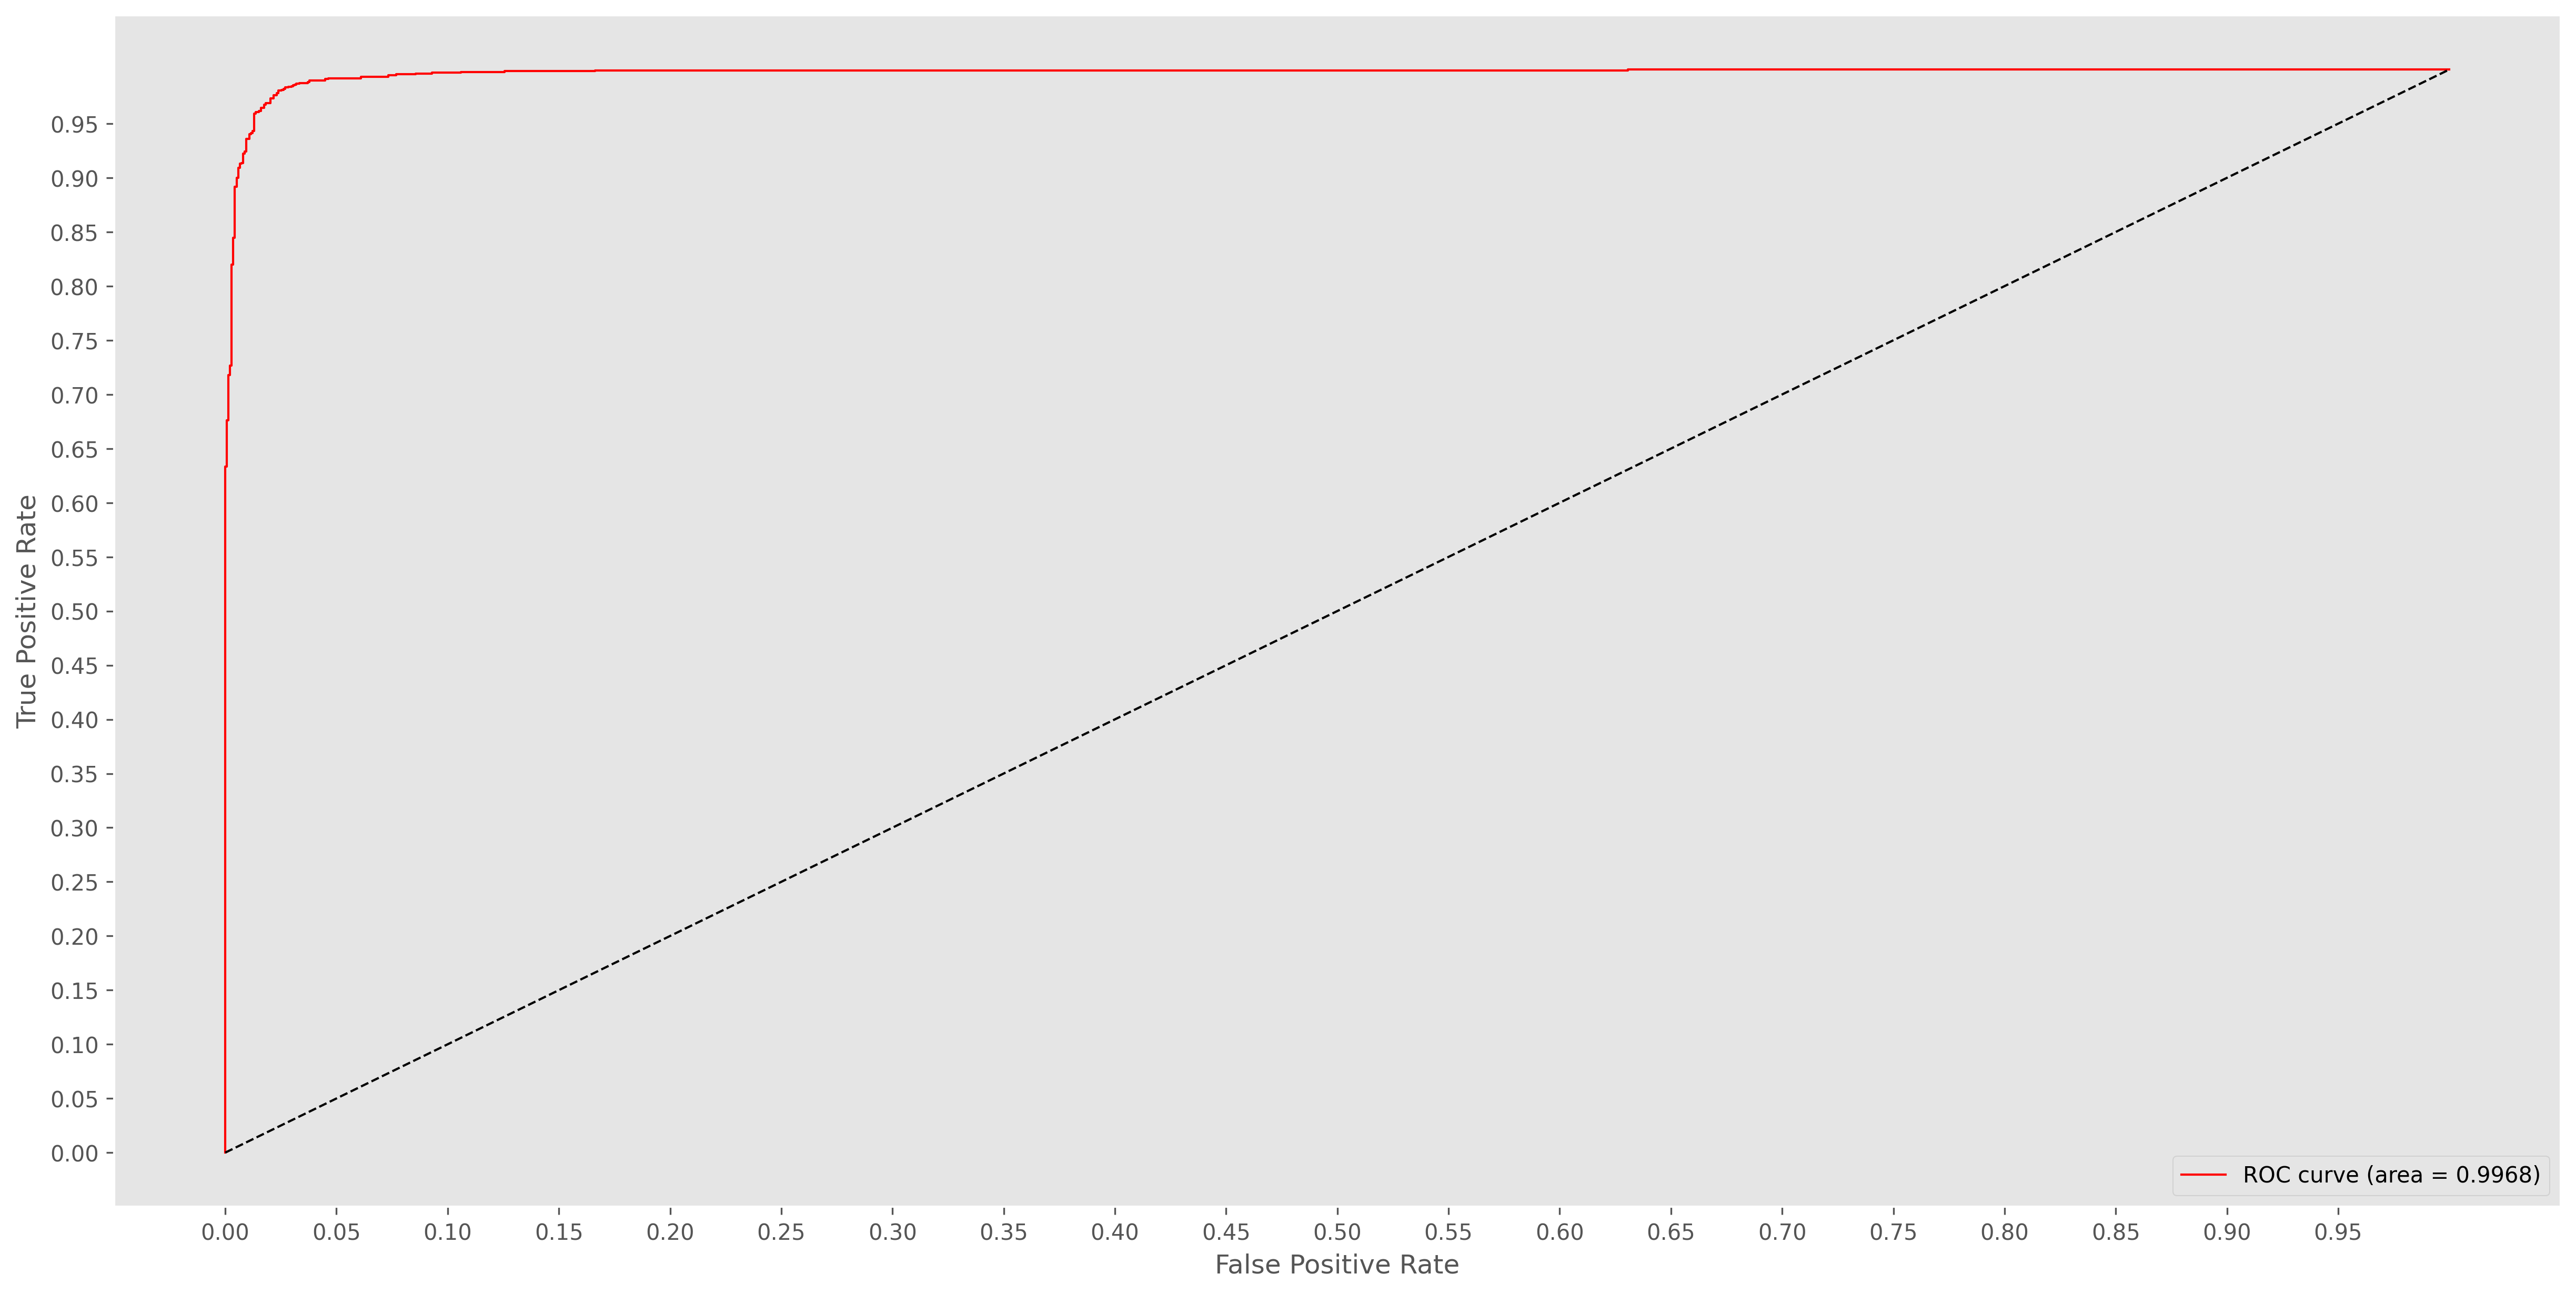

In [288]:
#%% Pair I

pair_I_ensemble_model = ensemble(pair_I, model_input)
pair_I_ensemble_model.save('weights/ensemblemodel_pairI.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
I_ensem_y_pred = pair_I_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
I_ensemble_model_accuracy = accuracy_score(Y_test,I_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair I_ Ensemble model is: ', I_ensemble_model_accuracy)

#evaluate mean squared error
I_ensemble_model_custom_mse = mean_squared_error(Y_test,I_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair I_ Ensemble model is: ', I_ensemble_model_custom_mse)

#evaluate mean squared log error
I_ensemble_model_custom_msle = mean_squared_log_error(Y_test,I_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair I_ Ensemble model is: ', I_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,I_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,I_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, I_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()